In [102]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os
from tqdm import tqdm
from lmfit.models import GaussianModel

from scipy import optimize as optim

import sys
sys.path.append('../Library')

import image_analysis as ia # module with most of the code
import drop_detection_tools as ddt

from importlib import reload

import uncertainties as unc
import uplotlib as uplt


plot_dir = '../../../Report/Plots/i/'
plot_dir.rstrip('/')


# reload(plt)
%matplotlib notebook

In [2]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Extract frames from video

This needs to be done only once for every video

In [3]:
path = '../../../T-data/2-12/'
video_name = 'B-ol2-aq2-spf1.wmv'

folder = ia.extract_frames(path, video_name)

Frames already extracted :)


## Get arrays from video

In [4]:
pars = video_name.rsplit('.', 1)[0].split('-')
chip_name = pars[0]
liq1 = pars[1][:2]
flux1 = float(pars[1][2:])
liq2 = pars[2][:2]
flux2 = float(pars[2][2:])
spf = float(pars[3][3:])

print(f'chip {chip_name}:\n  {liq1}: {flux1}\n  {liq2}: {flux2}\n  spf: {spf}\n')

name = path.rstrip('/').rsplit('/',1)[1] + '_' + video_name.rsplit('-',1)[0] + '_i'

print(f'{name = }\n')

radius  = 0.3  # capillary radius [mm]
A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux1 + flux2)/A/60   # drops speed [mm/s]

print(f'Expected drop speed {v = :.3f} mm/s')

chip B:
  ol: 2.0
  aq: 2.0
  spf: 1.0

name = '2-12_B-ol2-aq2_i'

Expected drop speed v = 0.943 mm/s


In [5]:
color = 1 # green

arrays, mean_array = ia.get_arrays(folder,color,max_frames=1000)

print(arrays.shape)

Image.fromarray(mean_array).show()

Last frame analyzed: 1000
(1000, 960, 1280)


## Subtract the mean

In [6]:
arrays_sub = ia.subtract_mean(arrays,mean_array, negative=True, verbose=True)

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
m = -82.0, M = 88.0
converting to np.uint8
making the negative
concatenating

DONE! (Phew that was a huge array, you are a kernel serial killer)


In [7]:
# see an example

idx = 214

Image.fromarray(arrays[idx]).show()
Image.fromarray(arrays_sub[idx]).show()

# Image.fromarray(arrays[idx]).save(f'{plot_dir}/gray.png')
# Image.fromarray(arrays_sub[idx]).save(f'{plot_dir}/neg.png')

In [8]:
# optional

# see the corresponding negative image

neg = 255 - arrays_sub[idx]
Image.fromarray(neg).show()

# Image.fromarray(neg).save(f'{plot_dir}/sub.png')

## Rotation and gaussian filter

In [9]:
# test on one image

rotation = 19
filter_size = 0 # y and x sigmas for the filter

img = ia.preprocess(arrays_sub[idx], rotation=rotation, filter_size=filter_size)
img.show()

# img.save(f'{plot_dir}/rot.png')

In [10]:
# apply to all images
imgs = []
for array_sub in tqdm(arrays_sub):
    imgs.append(ia.preprocess(array_sub, rotation=rotation, filter_size=filter_size))

imgs = np.array(imgs,dtype=Image.Image)
# calibration image
calibr_img = ia.preprocess(arrays[idx], rotation=rotation, filter_size=0) # keep the image sharp

calibr_img.show()

100%|██████████| 1000/1000 [00:04<00:00, 231.63it/s]


## Channel analyzer

### Calibrate

In [11]:
c = ia.Channel_analyzer()

In [ ]:
# optional if object is already calibrated
fig = c.calibrate(calibr_img,15, cmap='gist_gray')

In [ ]:
# fig.savefig(f'{plot_dir}/channel.png')

In [ ]:
# optional if object is already calibrated
fig = c.find_channel(calibr_img, cmap='gist_gray')

<IPython.core.display.Javascript object>


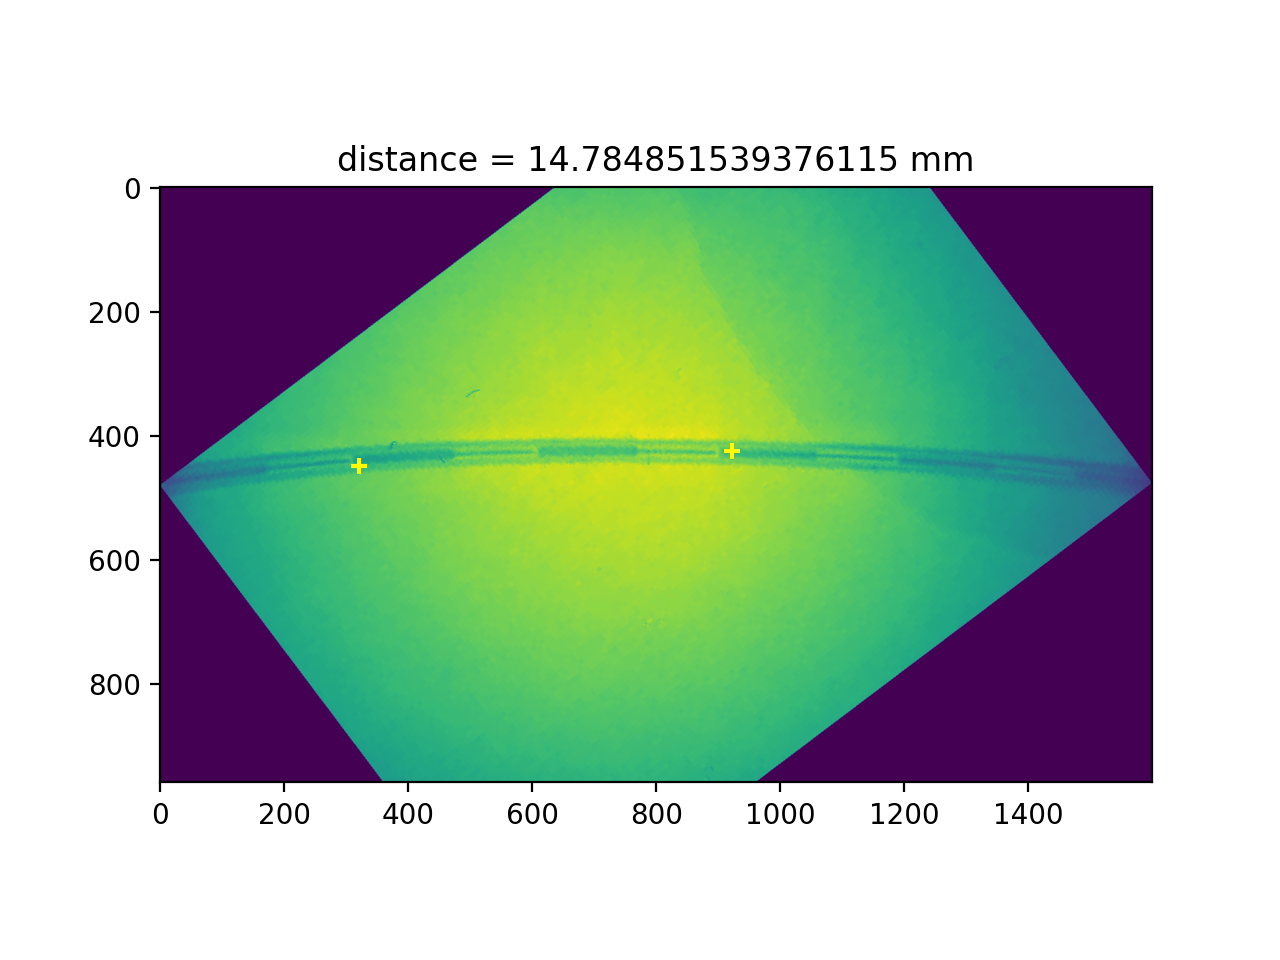

In [9]:
# optional
c.measure_distance(calibr_img)

### Save calibration

In [13]:
c.save(name='calibr_B-ol3-aq7',folder='../../../T-data/2-12/')

../../../T-data/2-12/calibr_B-ol3-aq7 exists: overwrite? [y/n]n


### Load from existing calibration

In [12]:
c.load(name='calibr_B-ol3-aq7',folder='../../../T-data/2-12')

## Waveform extraction

### Try waveform extraction on one image

<IPython.core.display.Javascript object>


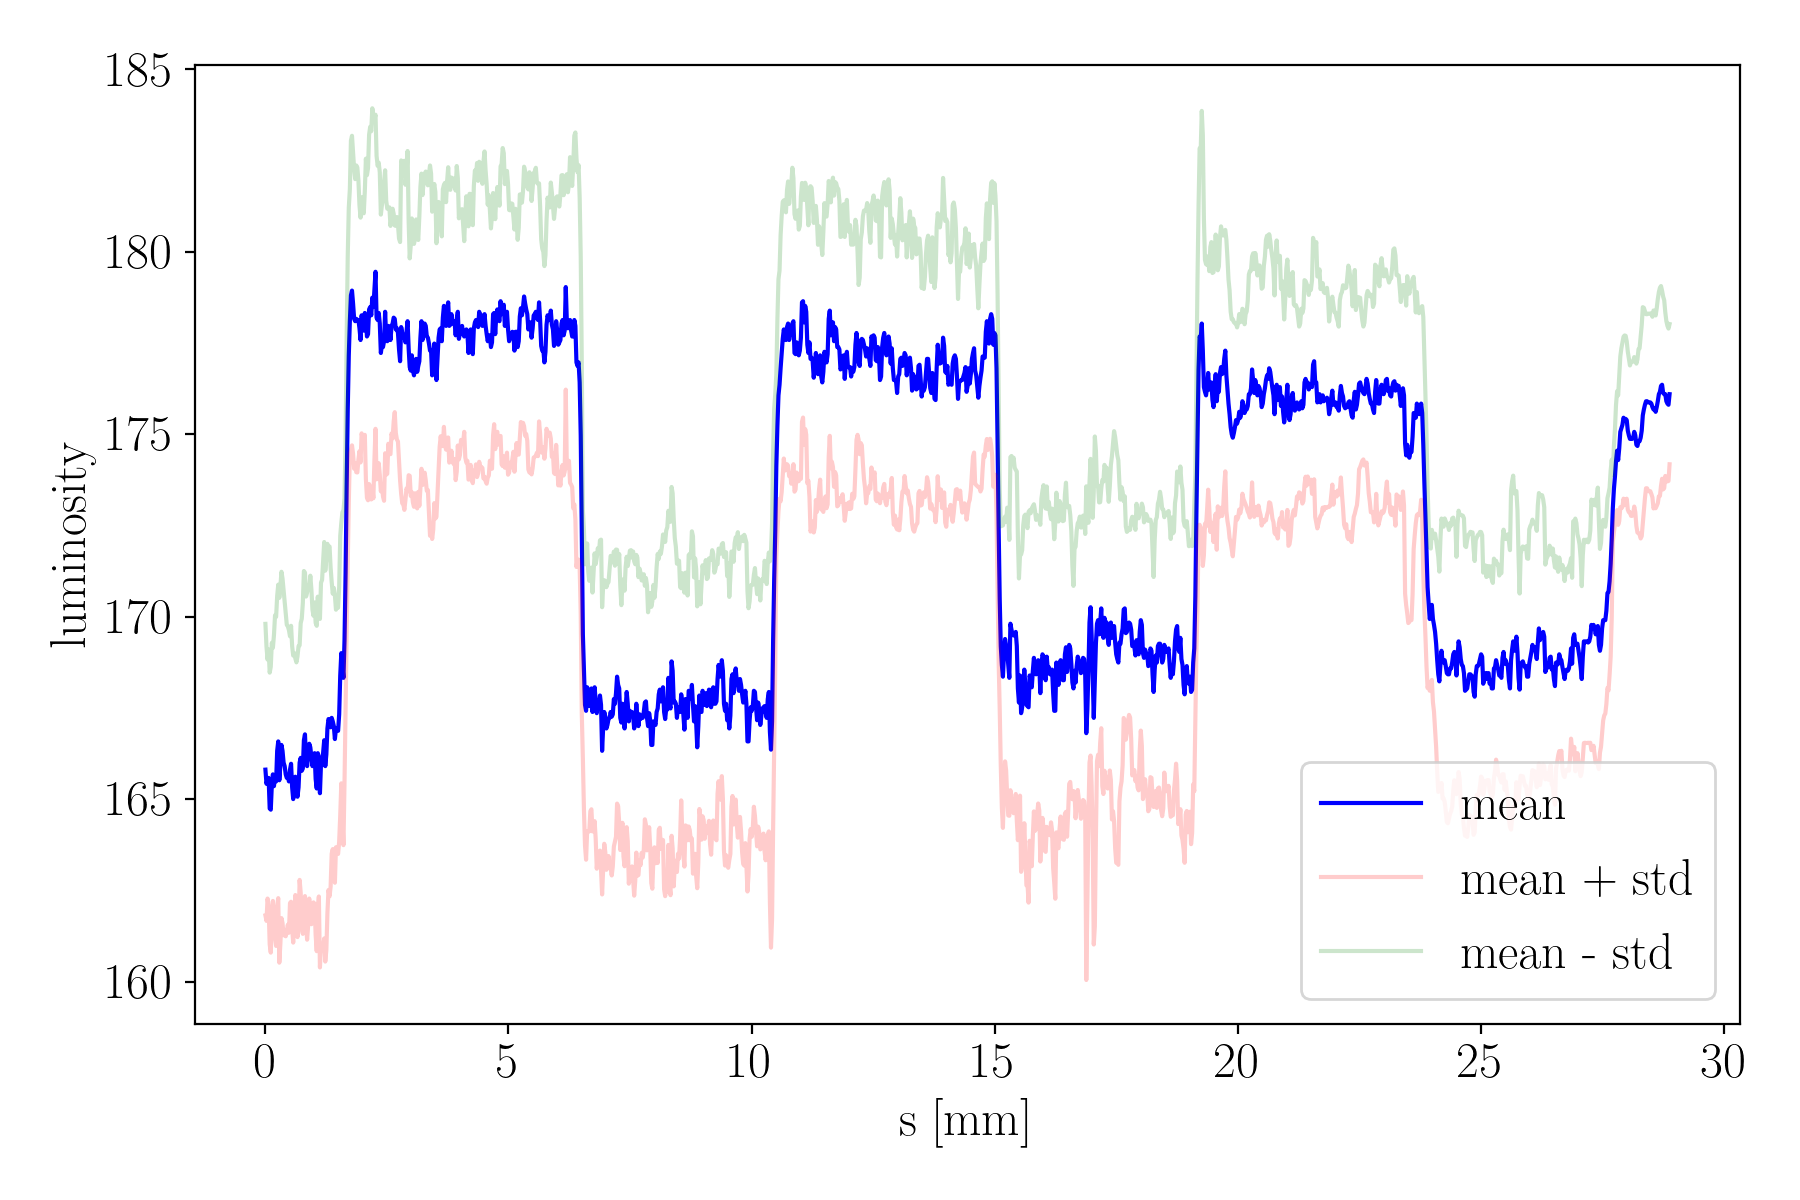

In [13]:
idx = 626

img = imgs[idx]
s, mean, std = c.evaluate(img)

fig,ax = plt.subplots(figsize=(9,6))
plt.plot(s,mean, color='blue', label='mean')
plt.plot(s,mean - std,color='red',alpha=0.2, label='mean + std')
plt.plot(s,mean + std,color='green',alpha=0.2, label = 'mean - std')

plt.xlabel('s [mm]')
plt.ylabel('luminosity')

plt.legend()

fig.tight_layout()

# fig.savefig(f'{plot_dir}/wf_extraction.png')

<IPython.core.display.Javascript object>


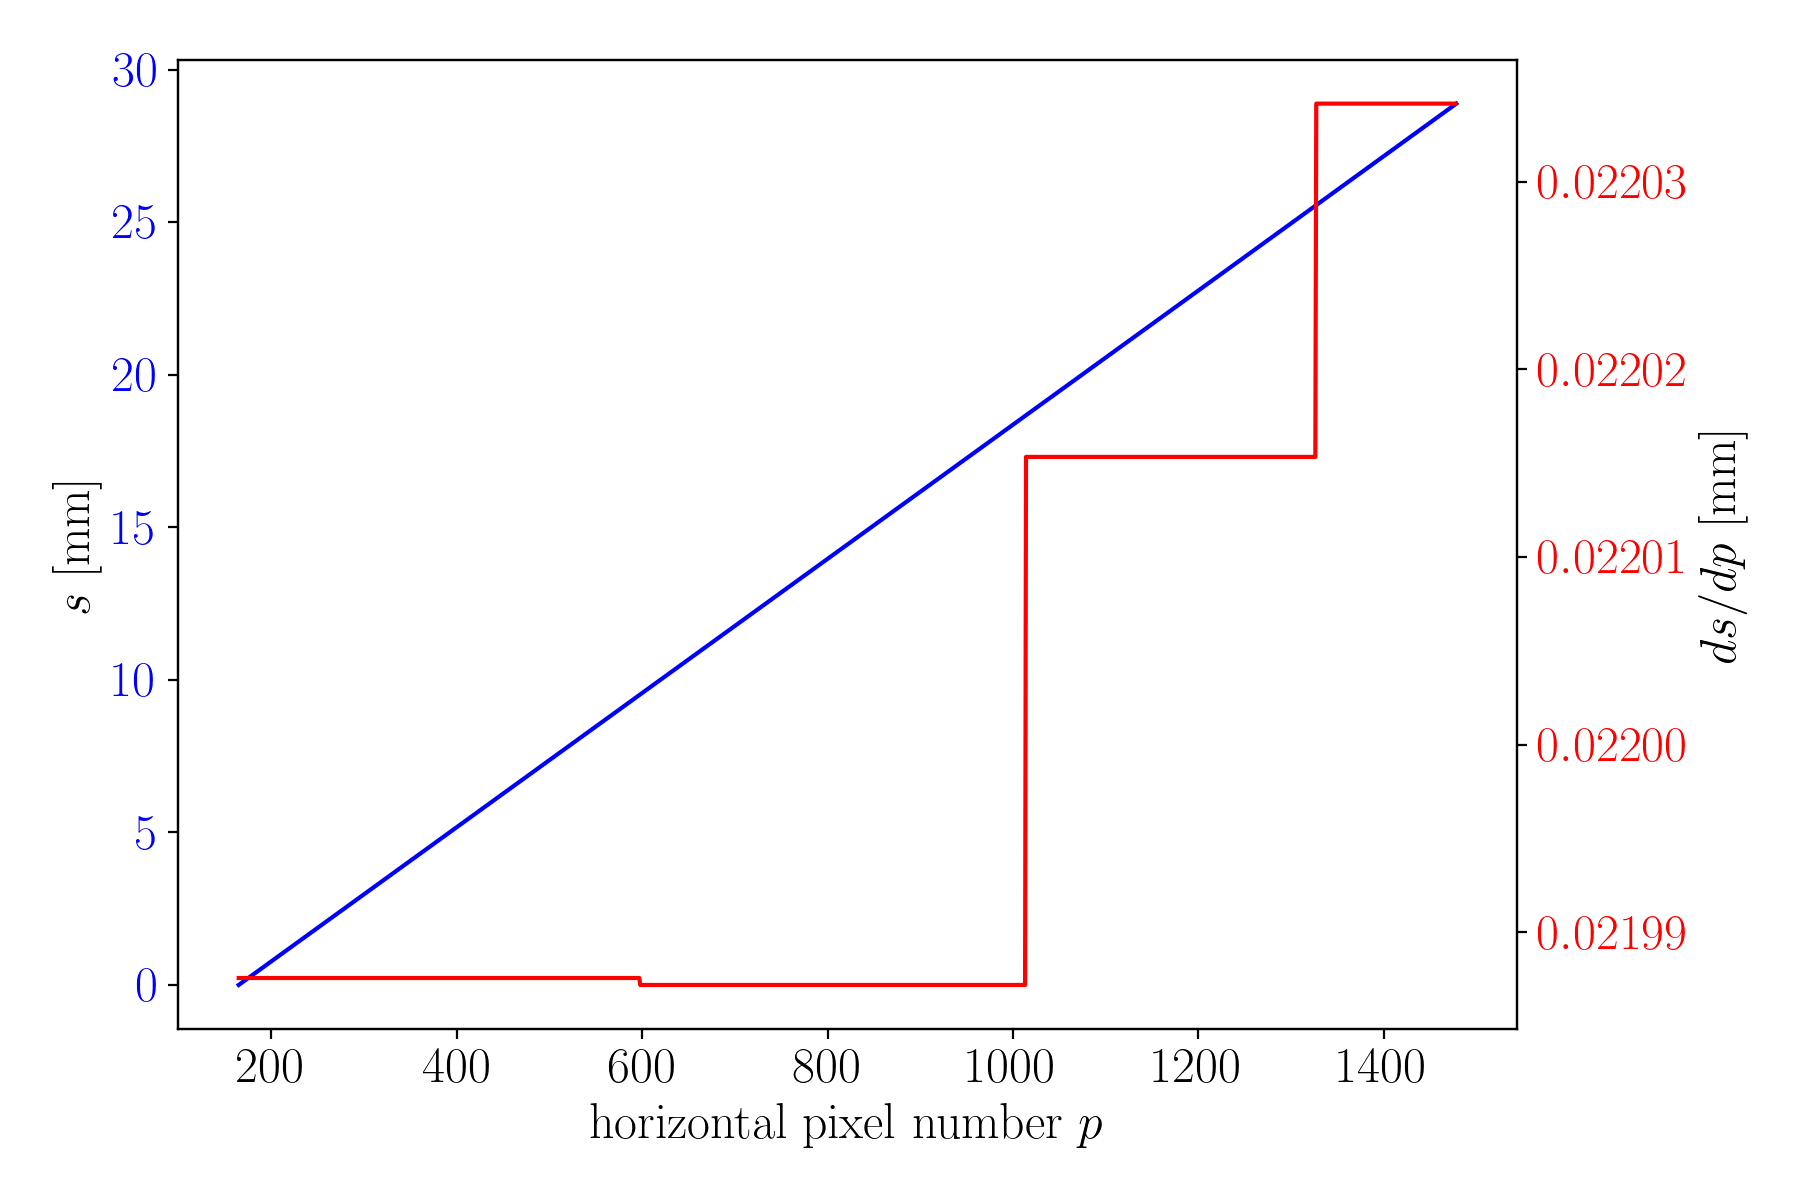

In [34]:
# optional

fig,ax1 = plt.subplots(figsize=(9,6))

ax1.plot(np.arange(c.points[0][0], c.points[-1][0] + 1), s, color='blue')
ax1.set_ylabel('$s$ [mm]')
ax1.tick_params(axis = 'y', labelcolor='blue')
ax1.set_xlabel('horizontal pixel number $p$')

ax2 = ax1.twinx()

ax2.plot(np.arange(c.points[0][0], c.points[-1][0]), s[1:] - s[:-1], color='red')
ax2.set_ylabel('$ds/dp$ [mm]')
ax2.tick_params(axis = 'y', labelcolor='red')

fig.tight_layout()


# fig.savefig(f'{plot_dir}/s_vs_p')

### Improving the waveform

### Rectify

100%|██████████| 1314/1314 [00:00<00:00, 25558.06it/s]


<IPython.core.display.Javascript object>


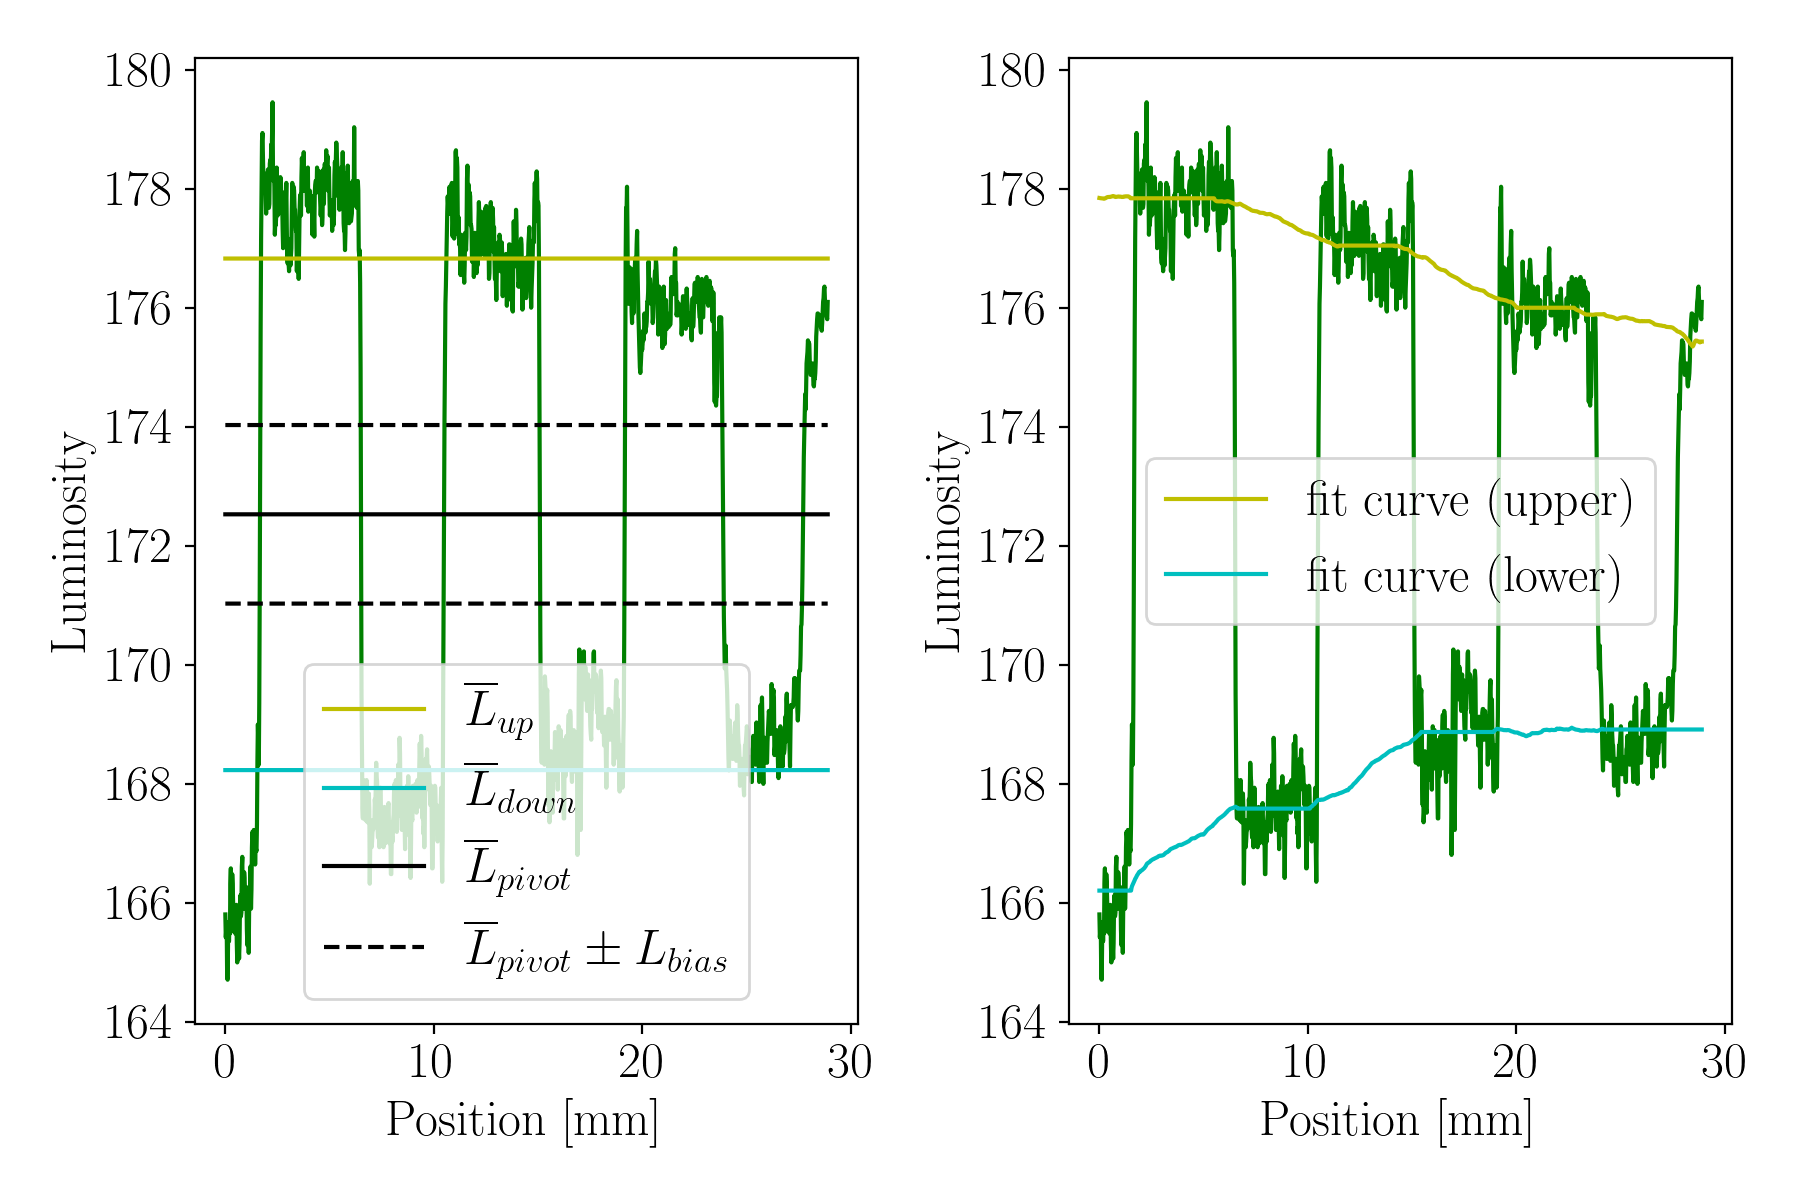

<IPython.core.display.Javascript object>


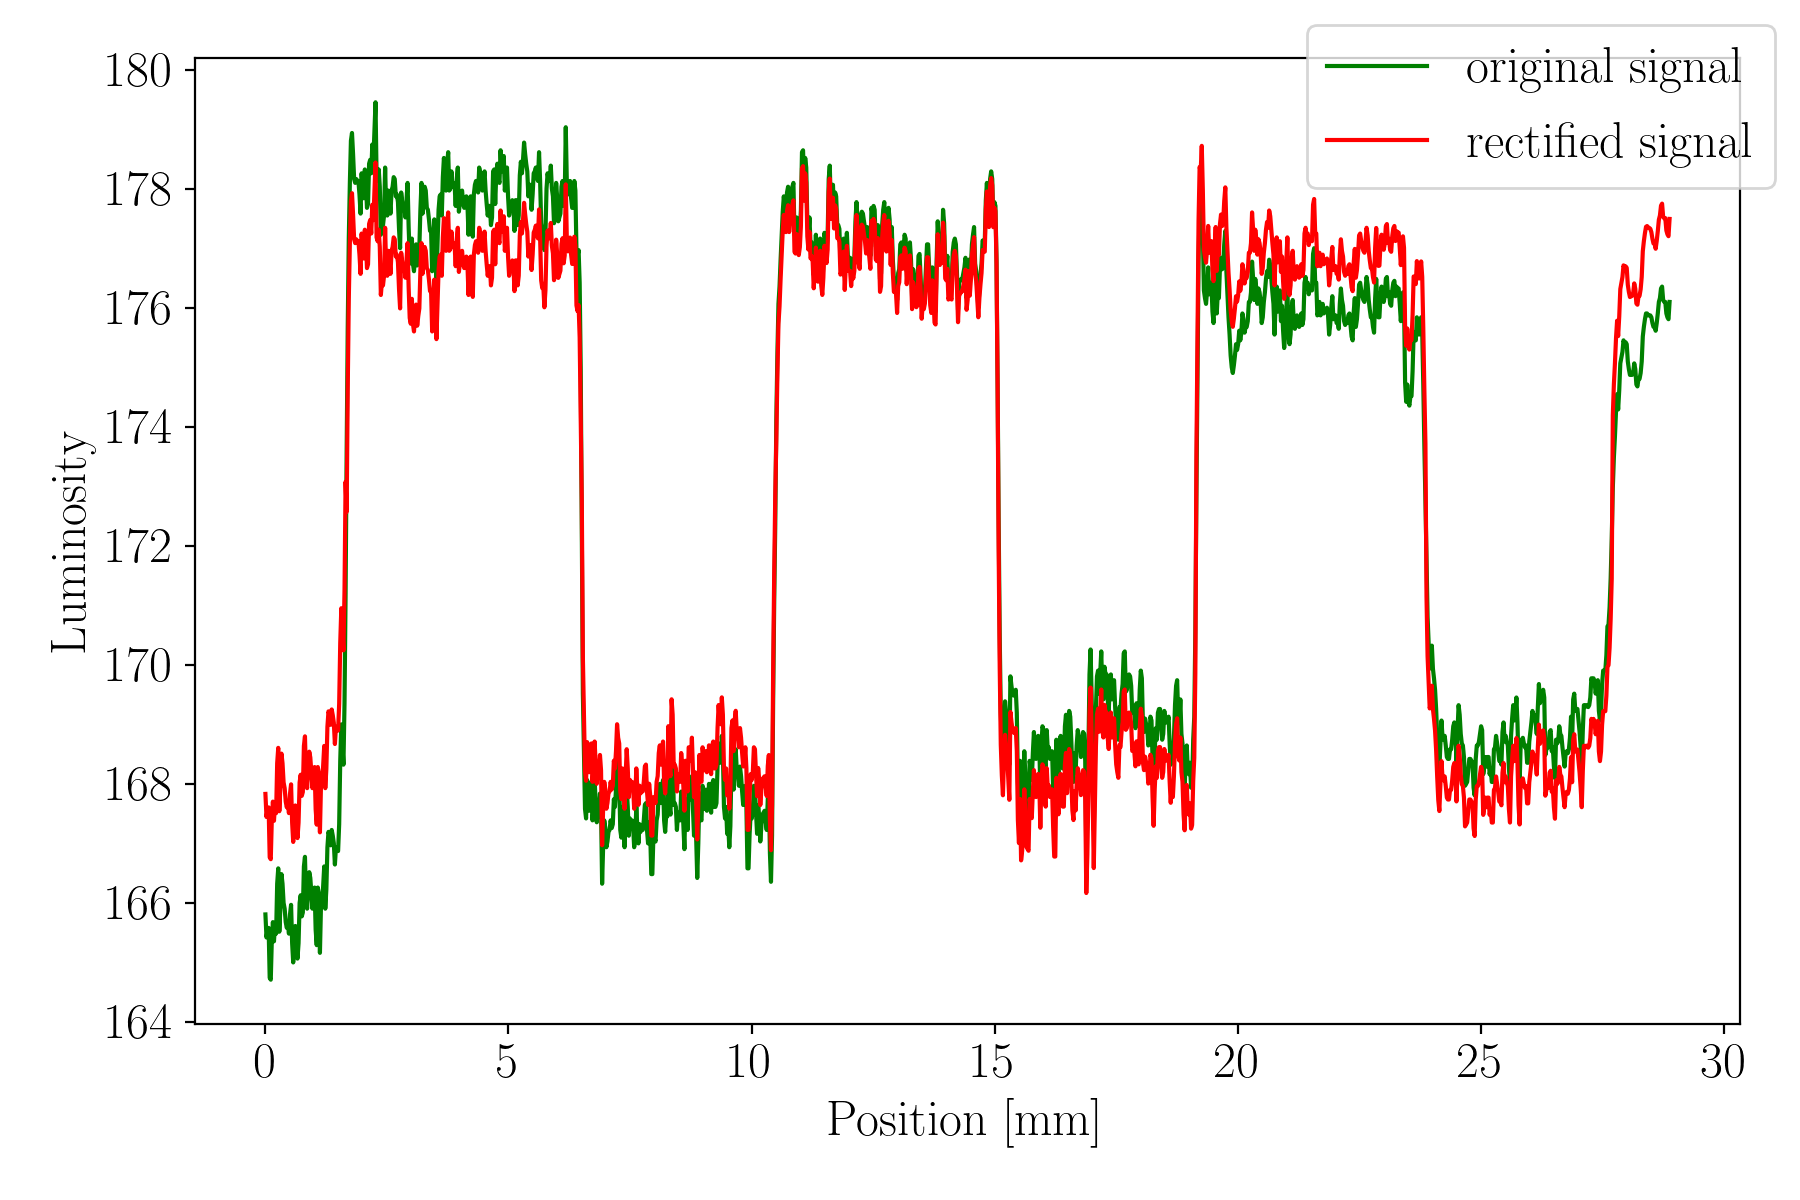

In [14]:
# try on one image

xrange = 5
ignore_bias = 1.5

figs, r_sig = ddt.rectify_new(mean,xdata=s, xrange=xrange, ignore_bias=ignore_bias,
                              xlabel='Position [mm]', ylabel='Luminosity', figsize=(9,6))

# figs[0].savefig(f'{plot_dir}/wf_rectification1.png')
# figs[1].savefig(f'{plot_dir}/wf_rectification2.png')

### Extract all waveforms

In [15]:
s     = 0.
means = []
stds  = []

for idx in tqdm(range(len(imgs))):
    s, mean, std = c.evaluate(imgs[idx])
    means.append(mean)
#     stds.append(std) # not used actually so no need to save it 

100%|██████████| 1000/1000 [00:51<00:00, 19.35it/s]


### Rectify the waveforms

In [16]:
means = [ddt.rectify_new(mean, xdata=s, xrange=xrange,ignore_bias=ignore_bias,
                         plot_switch=False, prog_bar=False)[1] for mean in tqdm(means)]

100%|██████████| 1000/1000 [01:07<00:00, 14.85it/s]


## Thresholds searching 

<IPython.core.display.Javascript object>


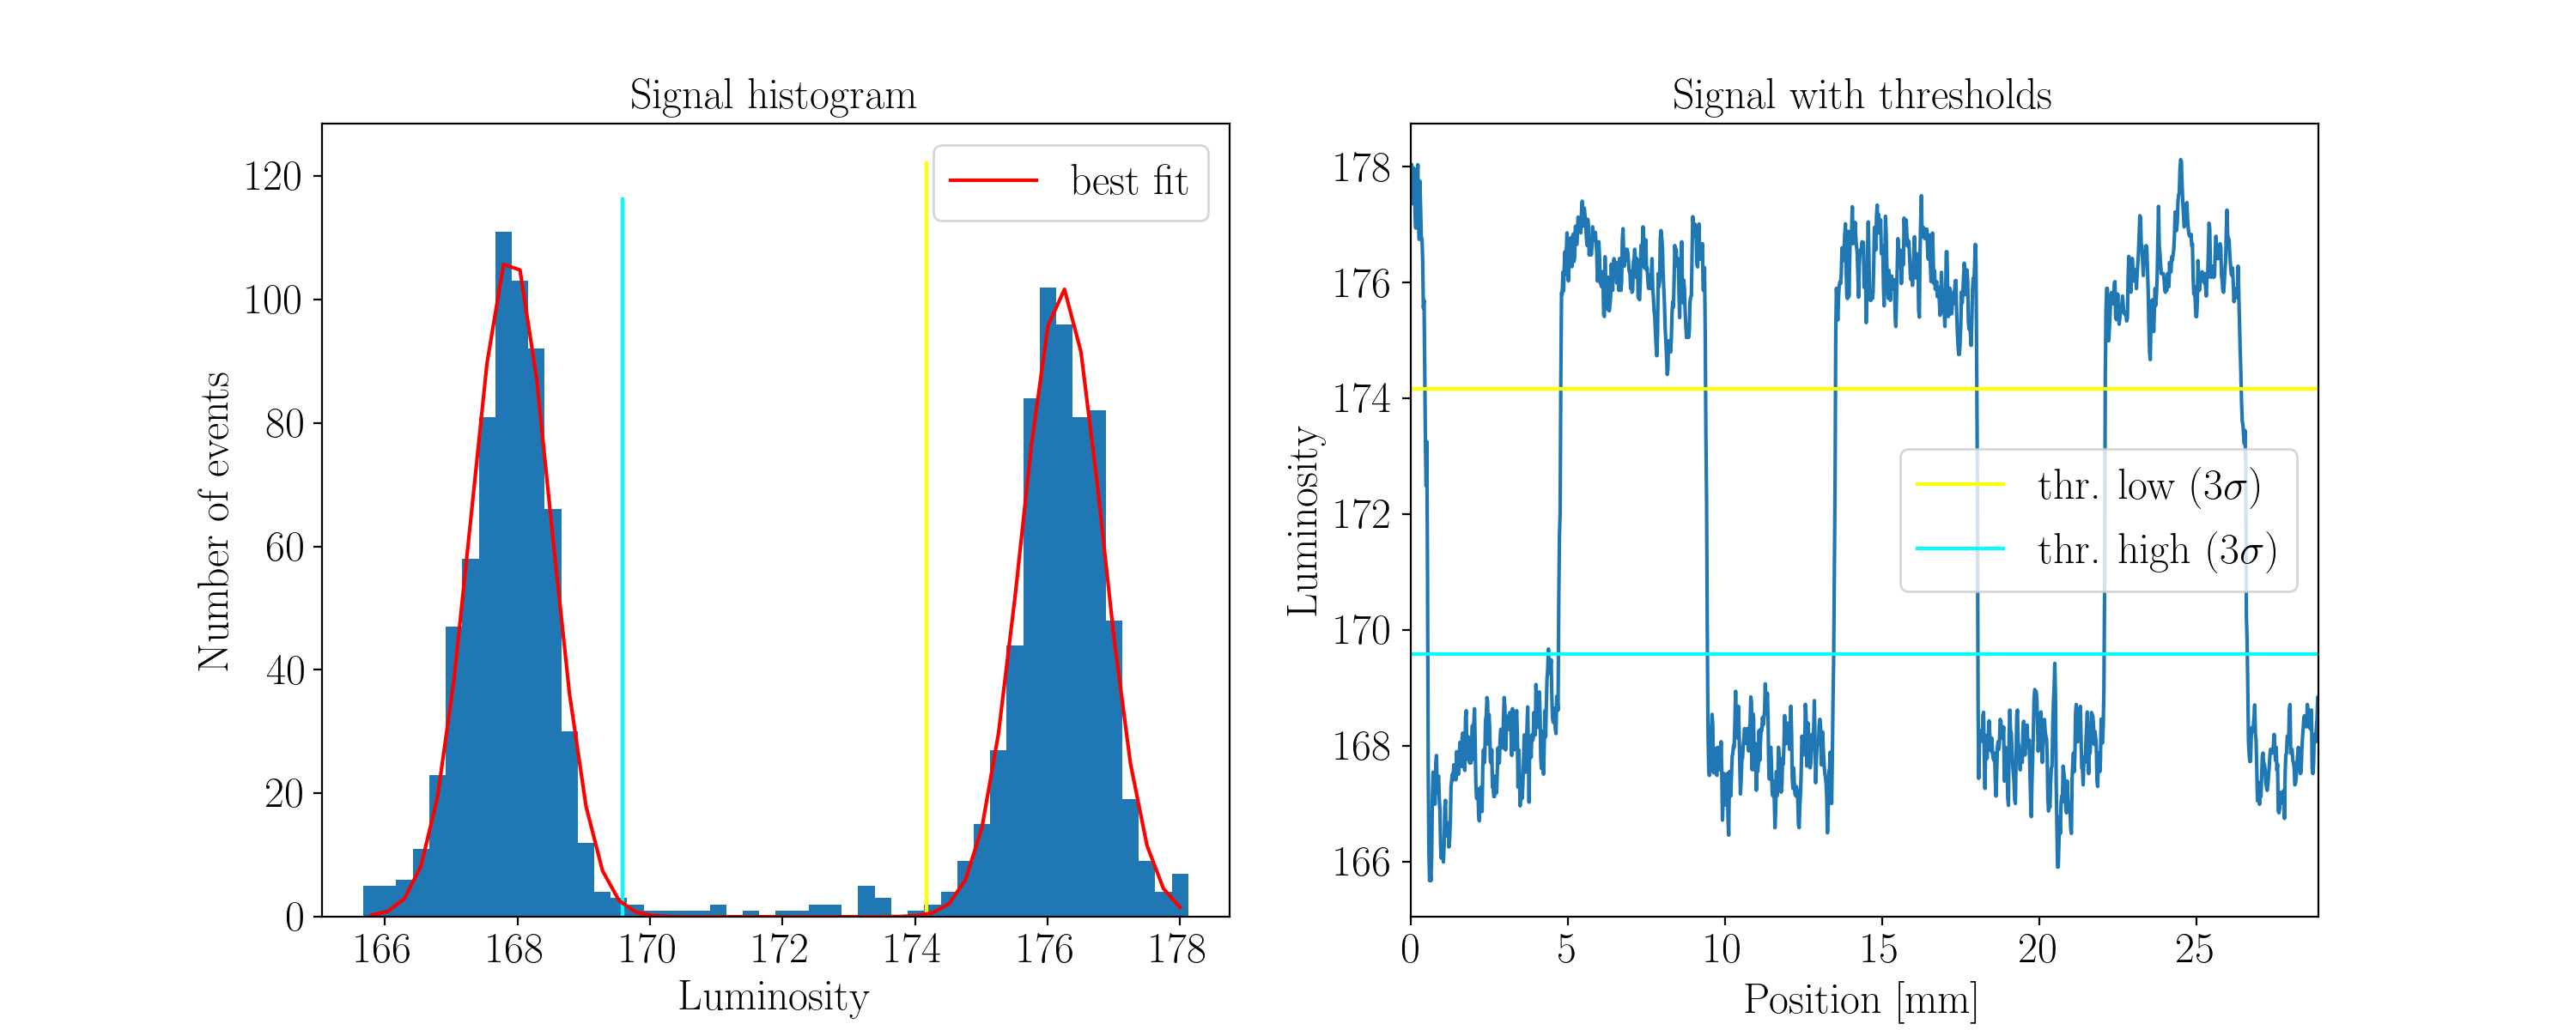

In [17]:
# Try on one image

#**************************************************
idx         = 214     # Frame index (checking plots)
nbins       = 50    # Histo bins number
plot_switch = True  # Plots activation

high_sigmas = 3
low_sigmas = 3

# Not needed
# ymin      = 120   # Plot min. luminosity
# ymax      = 130   # Plot max. luminosity
#**************************************************

%matplotlib notebook

# Plot one single signal (checking)
returns = ddt.thr_searcher(Ydata=means[idx], nbins=nbins, plot_switch=plot_switch, Xdata=s,
                            high_sigmas=high_sigmas, low_sigmas=low_sigmas)

### Compute the thresholds using all data at once

<IPython.core.display.Javascript object>


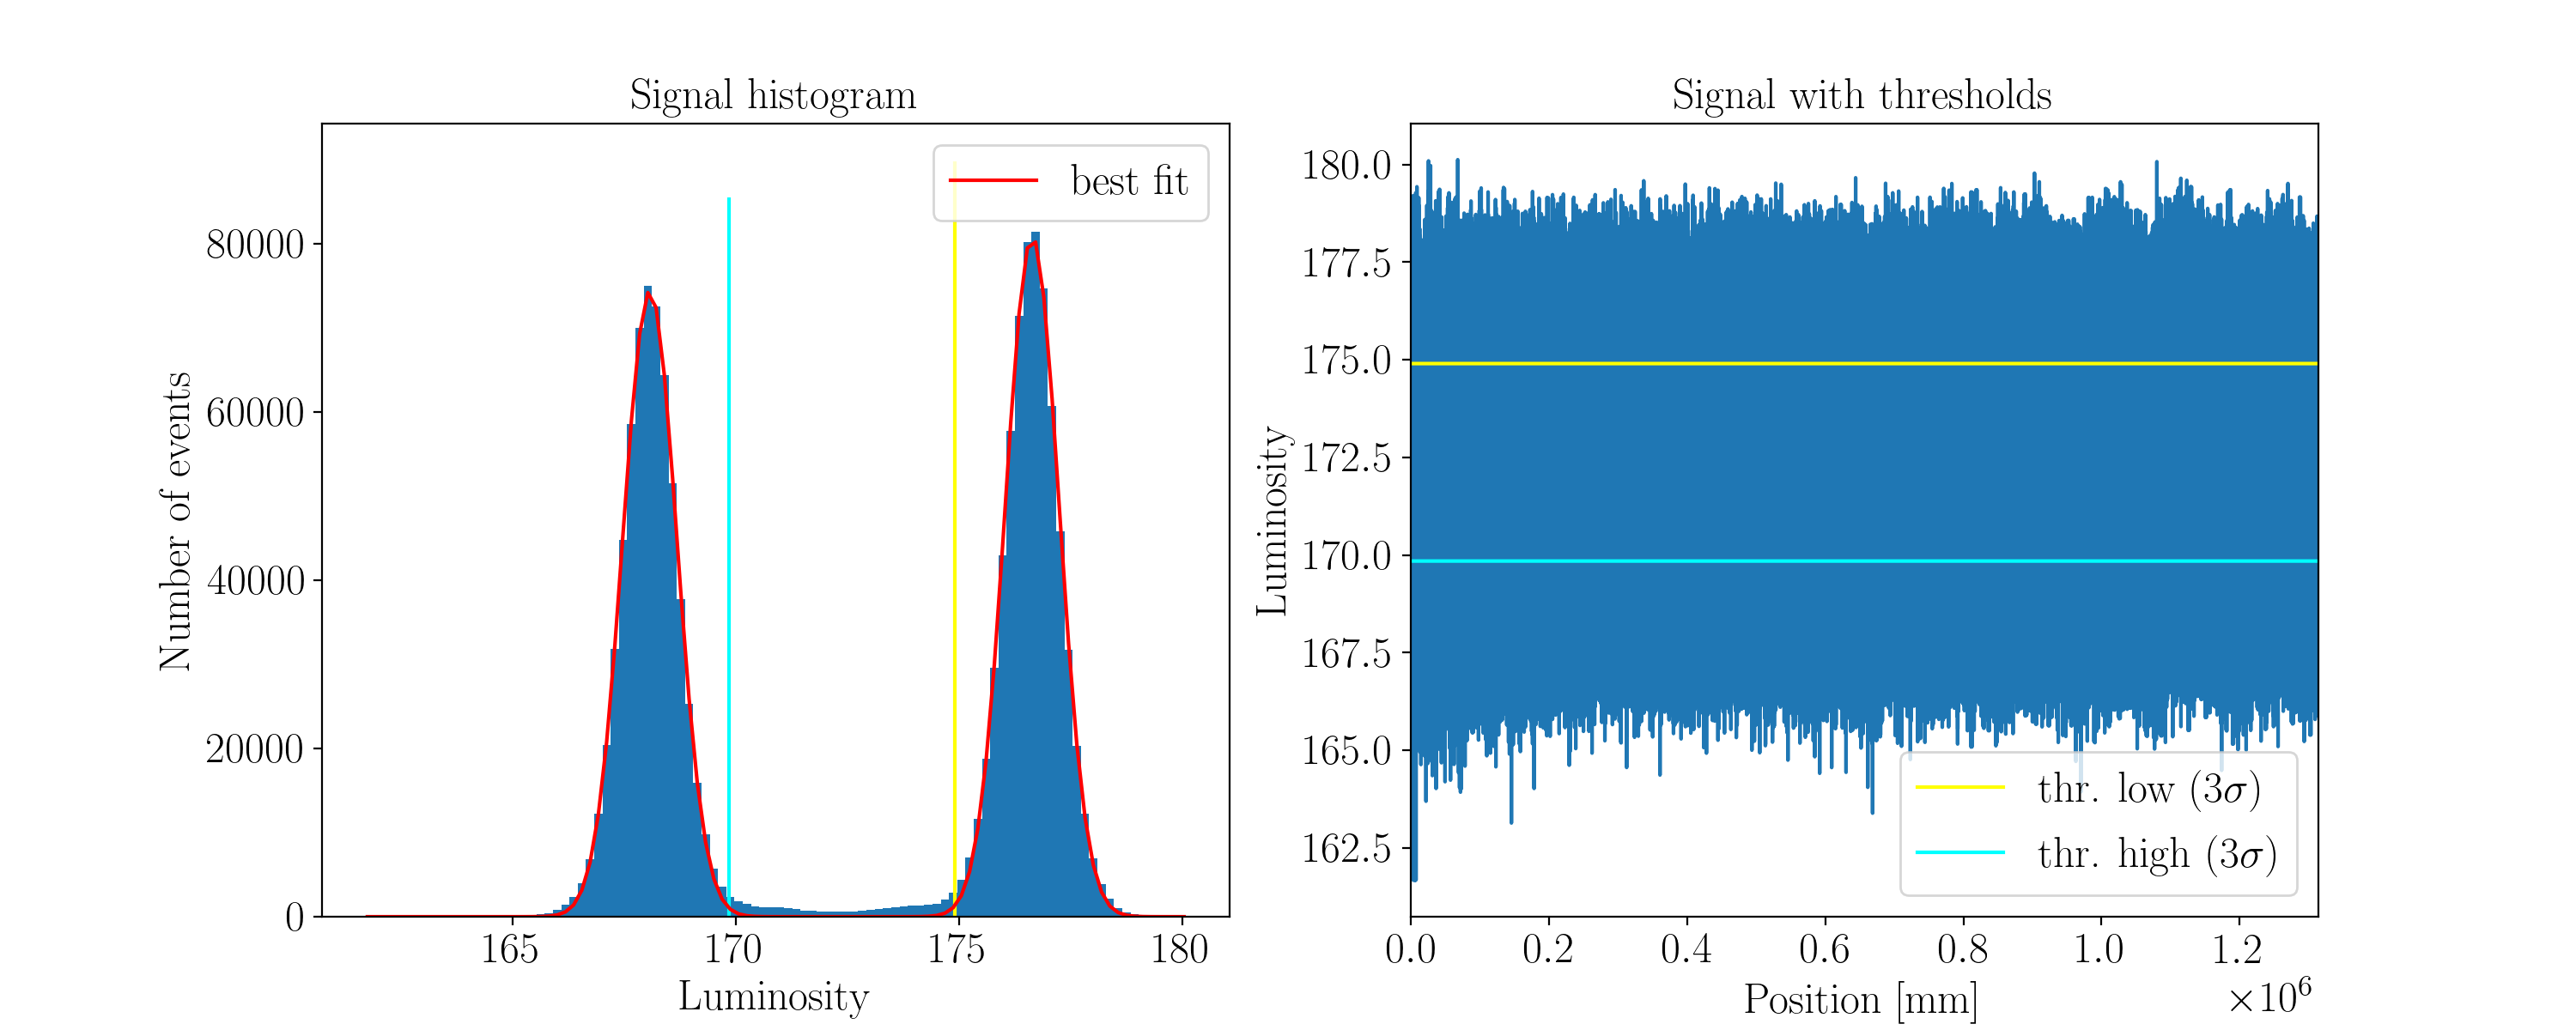

In [18]:
nbins       = 100    # Histo bins number
plot_switch = True  # Plots activation

high_sigmas = 3
low_sigmas = 3

c01 = None
c02 = None

returns = ddt.thr_searcher(Ydata=np.concatenate(means), nbins=nbins, plot_switch=plot_switch,
                           high_sigmas=high_sigmas, low_sigmas=low_sigmas,c01=c01,c02=c02)

thr_low, thr_high, sigma_low, sigma_high = returns

## Drop detection 

In [19]:
# manual setting of thrs: deprecated

o = input('Are you sure you want to override thresholds? [y/n] ')

if o == 'y':
    thr_low = 177.5
    thr_low = 176

Are you sure you want to override thresholds? [y/n] n


3 3
3 3


<IPython.core.display.Javascript object>


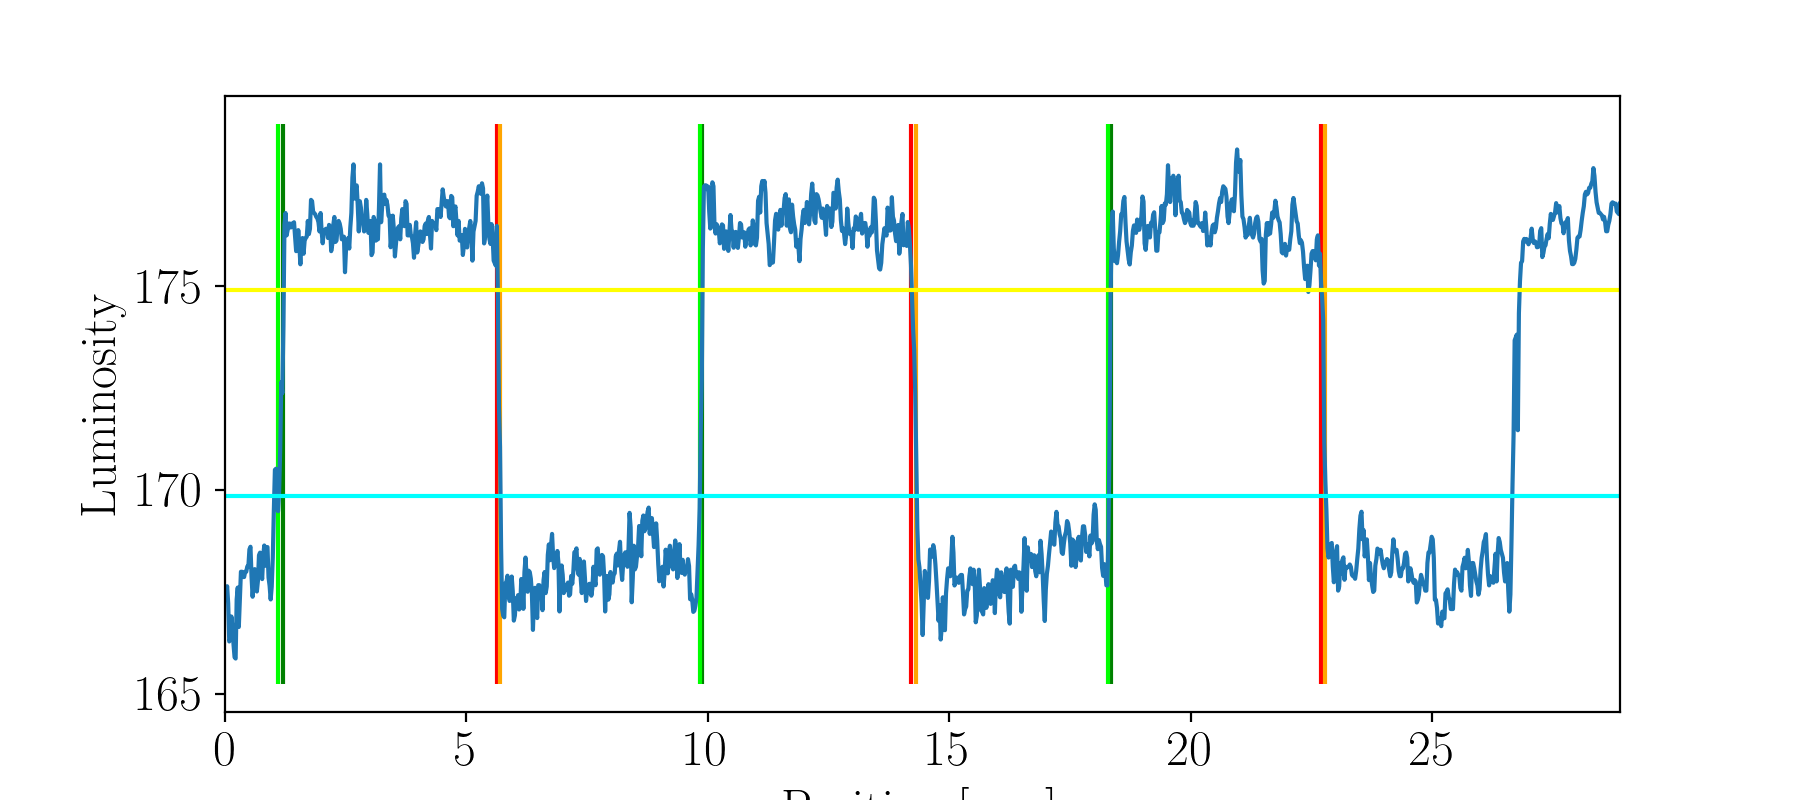

(array([ 1.20931595,  9.8724097 , 18.33747858]),
 array([ 5.62881604, 14.2038865 , 22.69609144]),
 array([ 1.09937813,  9.82843532, 18.2935042 ]),
 array([ 5.69477873, 14.31382246, 22.78415275]))

In [20]:
# Detection of the edges of the drops

idx = 547# Frame index (checking plot)


returns = ddt.drop_det_new(Xdata=s, Ydata=means[idx], thr_low=thr_low, thr_high=thr_high,
                           backward_skip=0, forward_skip=0, return_indexes=False, keep_invalid=False,
                           figsize=(9,4), xlabel='Position [mm]', ylabel= 'Luminosity')

# narrow_start, narrow_end, wide_start, wide_end = returns

returns

### Compute starts and ends for every frame

In [21]:
drop_edges = [] # will be as indices
has_error = False

for i,mean in enumerate(means):
    print(f'\nframe {i}:')
    returns = ddt.drop_det_new(Xdata=s, Ydata=mean, thr_low=thr_low, thr_high=thr_high,
                               backward_skip=0, forward_skip=0,
                               plot_switch=False, return_indexes=True, keep_invalid=False)
    narrow_start, narrow_end, wide_start, wide_end = returns
    
    drop_edges.append([wide_start, narrow_start, narrow_end, wide_end])


frame 0:
4 4
4 4

frame 1:
4 4
4 4

frame 2:
4 4
4 4

frame 3:
4 4
3 3

frame 4:
4 4
3 3

frame 5:
3 3
3 3

frame 6:
3 3
3 3

frame 7:
3 3
3 3

frame 8:
4 4
4 4

frame 9:
4 4
4 4

frame 10:
4 4
4 4

frame 11:
3 3
3 3

frame 12:
4 4
4 4

frame 13:
4 4
4 4

frame 14:
4 4
3 3

frame 15:
3 3
3 3

frame 16:
3 3
3 3

frame 17:
3 3
3 3

frame 18:
3 3
3 3

frame 19:
3 3
3 3

frame 20:
4 4
4 4

frame 21:
4 4
4 4

frame 22:
4 4
4 4

frame 23:
4 4
3 3

frame 24:
3 3
3 3

frame 25:
3 3
3 3

frame 26:
3 3
3 3

frame 27:
3 3
3 3

frame 28:
3 3
3 3

frame 29:
3 3
3 3

frame 30:
3 3
3 3

frame 31:
4 4
4 4

frame 32:
4 4
4 4

frame 33:
3 3
3 3

frame 34:
3 3
3 3

frame 35:
3 3
3 3

frame 36:
3 3
3 3

frame 37:
3 3
3 3

frame 38:
3 3
3 3

frame 39:
3 3
3 3

frame 40:
4 4
4 4

frame 41:
4 4
4 4

frame 42:
3 3
3 3

frame 43:
3 3
3 3

frame 44:
3 3
3 3

frame 45:
3 3
3 3

frame 46:
3 3
3 3

frame 47:
3 3
3 3

frame 48:
3 3
3 3

frame 49:
3 3
3 3

frame 50:
4 4
4 4

frame 51:
4 4
4 4

frame 52:
4 4
4 4

fr

3 3
3 3

frame 429:
3 3
3 3

frame 430:
3 3
3 3

frame 431:
3 3
3 3

frame 432:
2 2
2 2

frame 433:
2 2
2 2

frame 434:
3 3
3 3

frame 435:
3 3
3 3

frame 436:
3 3
3 3

frame 437:
3 3
3 3

frame 438:
3 3
3 3

frame 439:
3 3
3 3

frame 440:
3 3
3 3

frame 441:
4 4
3 3

frame 442:
3 3
3 3

frame 443:
3 3
3 3

frame 444:
3 3
3 3

frame 445:
3 3
3 3

frame 446:
3 3
3 3

frame 447:
3 3
2 2

frame 448:
2 2
2 2

frame 449:
3 3
3 3

frame 450:
3 3
3 3

frame 451:
3 3
3 3

frame 452:
3 3
3 3

frame 453:
3 3
3 3

frame 454:
3 3
3 3

frame 455:
3 3
3 3

frame 456:
3 3
3 3

frame 457:
2 2
2 2

frame 458:
3 3
3 3

frame 459:
3 3
3 3

frame 460:
3 3
3 3

frame 461:
3 3
3 3

frame 462:
3 3
2 2

frame 463:
3 3
3 3

frame 464:
3 3
3 3

frame 465:
4 4
3 3

frame 466:
3 3
3 3

frame 467:
3 3
3 3

frame 468:
3 3
3 3

frame 469:
3 3
3 3

frame 470:
2 2
2 2

frame 471:
3 3
3 3

frame 472:
3 3
3 3

frame 473:
3 3
3 3

frame 474:
4 4
3 3

frame 475:
3 3
3 3

frame 476:
4 4
3 3

frame 477:
3 3
3 3

frame 478:


3 3

frame 842:
3 3
3 3

frame 843:
3 3
3 3

frame 844:
3 3
3 3

frame 845:
3 3
3 3

frame 846:
3 3
3 3

frame 847:
3 3
3 3

frame 848:
3 3
3 3

frame 849:
3 3
2 2

frame 850:
2 2
2 2

frame 851:
2 2
2 2

frame 852:
2 2
2 2

frame 853:
2 2
2 2

frame 854:
2 2
2 2

frame 855:
3 3
2 2

frame 856:
2 2
2 2

frame 857:
2 2
2 2

frame 858:
2 2
2 2

frame 859:
2 2
2 2

frame 860:
2 2
2 2

frame 861:
2 2
2 2

frame 862:
2 2
2 2

frame 863:
2 2
2 2

frame 864:
2 2
2 2

frame 865:
2 2
2 2

frame 866:
2 2
2 2

frame 867:
2 2
2 2

frame 868:
2 2
2 2

frame 869:
2 2
2 2

frame 870:
3 3
3 3

frame 871:
3 3
3 3

frame 872:
3 3
3 3

frame 873:
3 3
3 3

frame 874:
3 3
3 3

frame 875:
3 3
3 3

frame 876:
3 3
3 3

frame 877:
3 3
3 3

frame 878:
3 3
3 3

frame 879:
3 3
3 3

frame 880:
3 3
3 3

frame 881:
3 3
3 3

frame 882:
3 3
3 3

frame 883:
3 3
3 3

frame 884:
3 3
3 3

frame 885:
3 3
3 3

frame 886:
3 3
3 3

frame 887:
3 3
3 3

frame 888:
3 3
3 3

frame 889:
4 4
3 3

frame 890:
4 4
3 3

frame 891:
3 3


### Remove small drops

In [22]:
def remove_small_drops(drop_edges, min_size, wide=True):
    for i, edges in enumerate(drop_edges):
        if wide:
            sizes = edges[-1] - edges[0] # use the wide size
        else:
            sizes = edges[-2] - edges[1] # use the narrow size
        idx_to_remove = []
        for j,si in enumerate(sizes):
            if si < min_size:
                idx_to_remove.append(j)
        if len(idx_to_remove) > 0:
            print(f'removing {len(idx_to_remove)} drops from frame {i}')
            for k in range(len(edges)):
                edges[k] = np.delete(edges[k], idx_to_remove)
    
    return drop_edges

In [23]:
if has_error:
    raise TypeError('Errors already computed: you do not need this cell')

drop_edges = remove_small_drops(drop_edges,min_size=1)

## Add errors

### Evaluate slopes

<IPython.core.display.Javascript object>


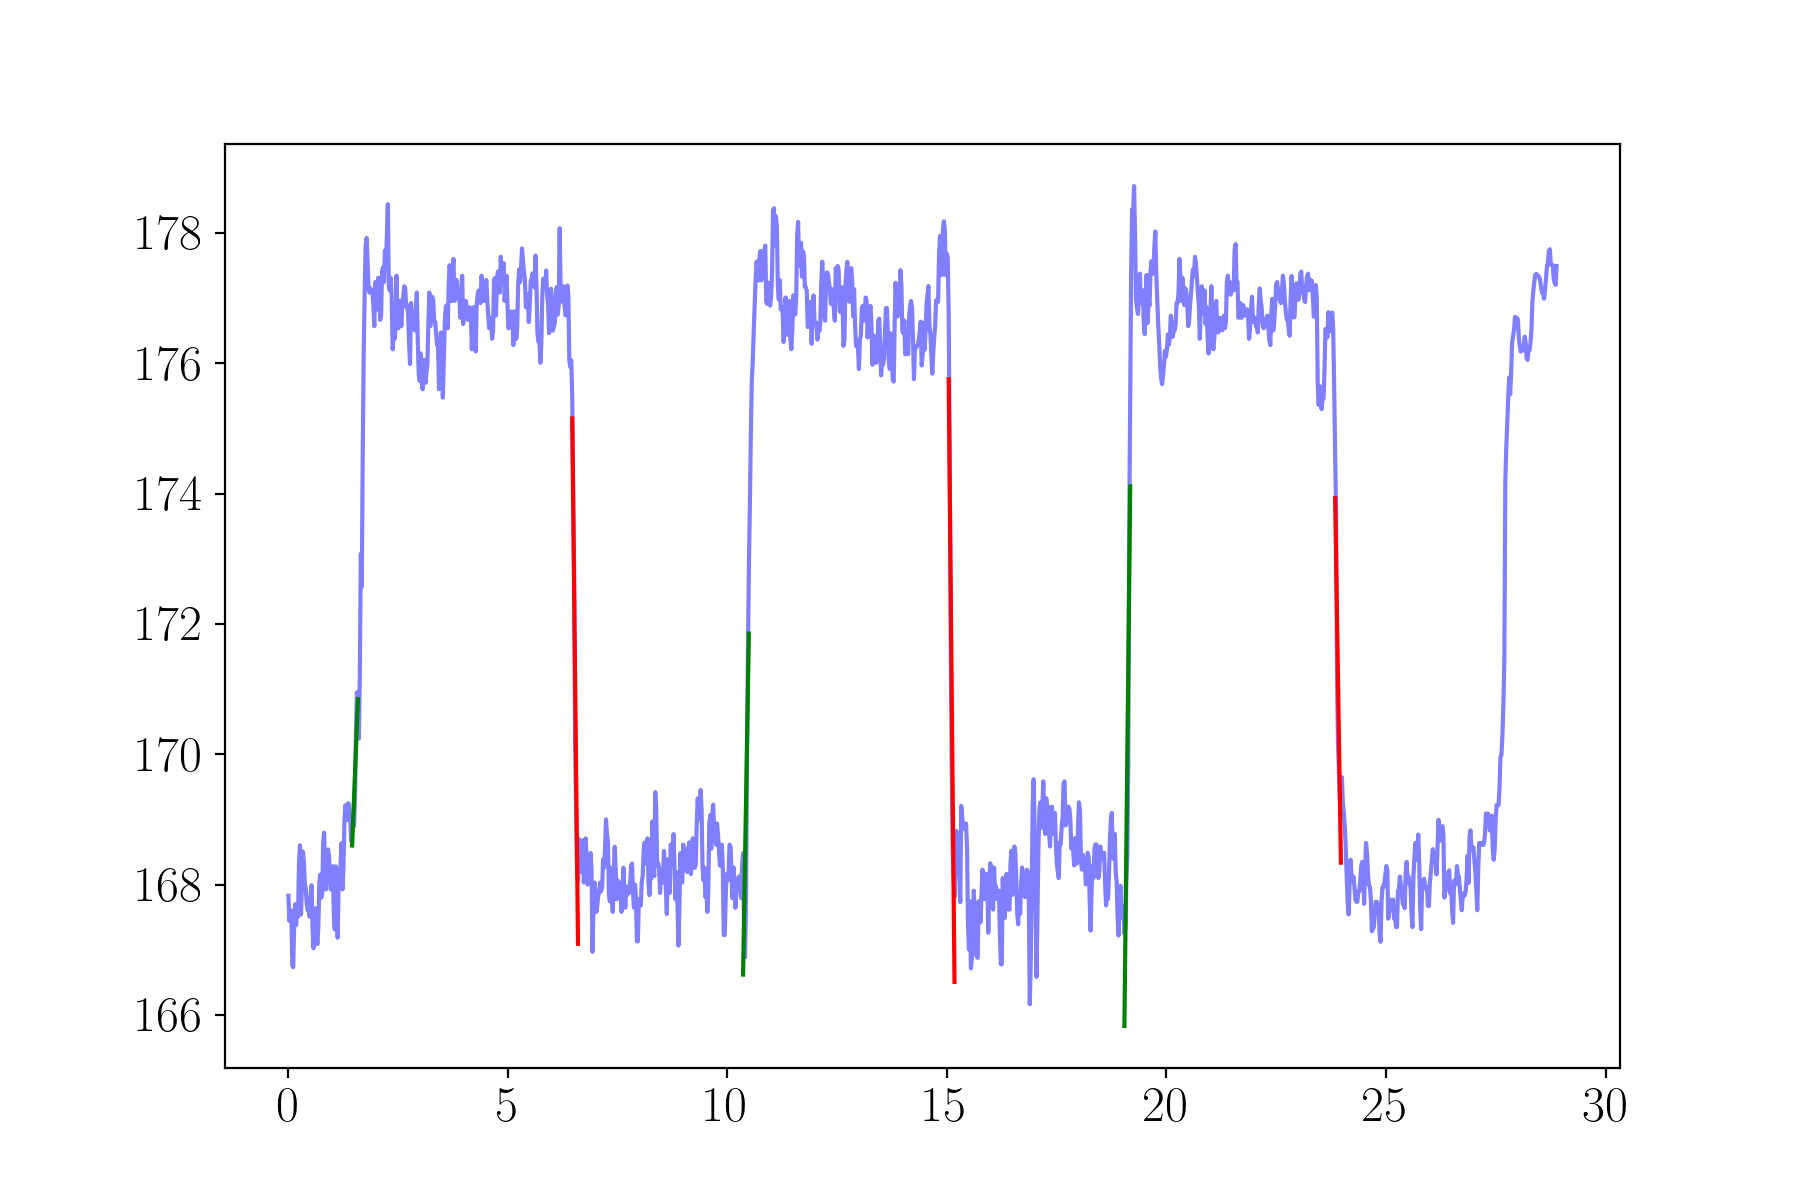

<IPython.core.display.Javascript object>


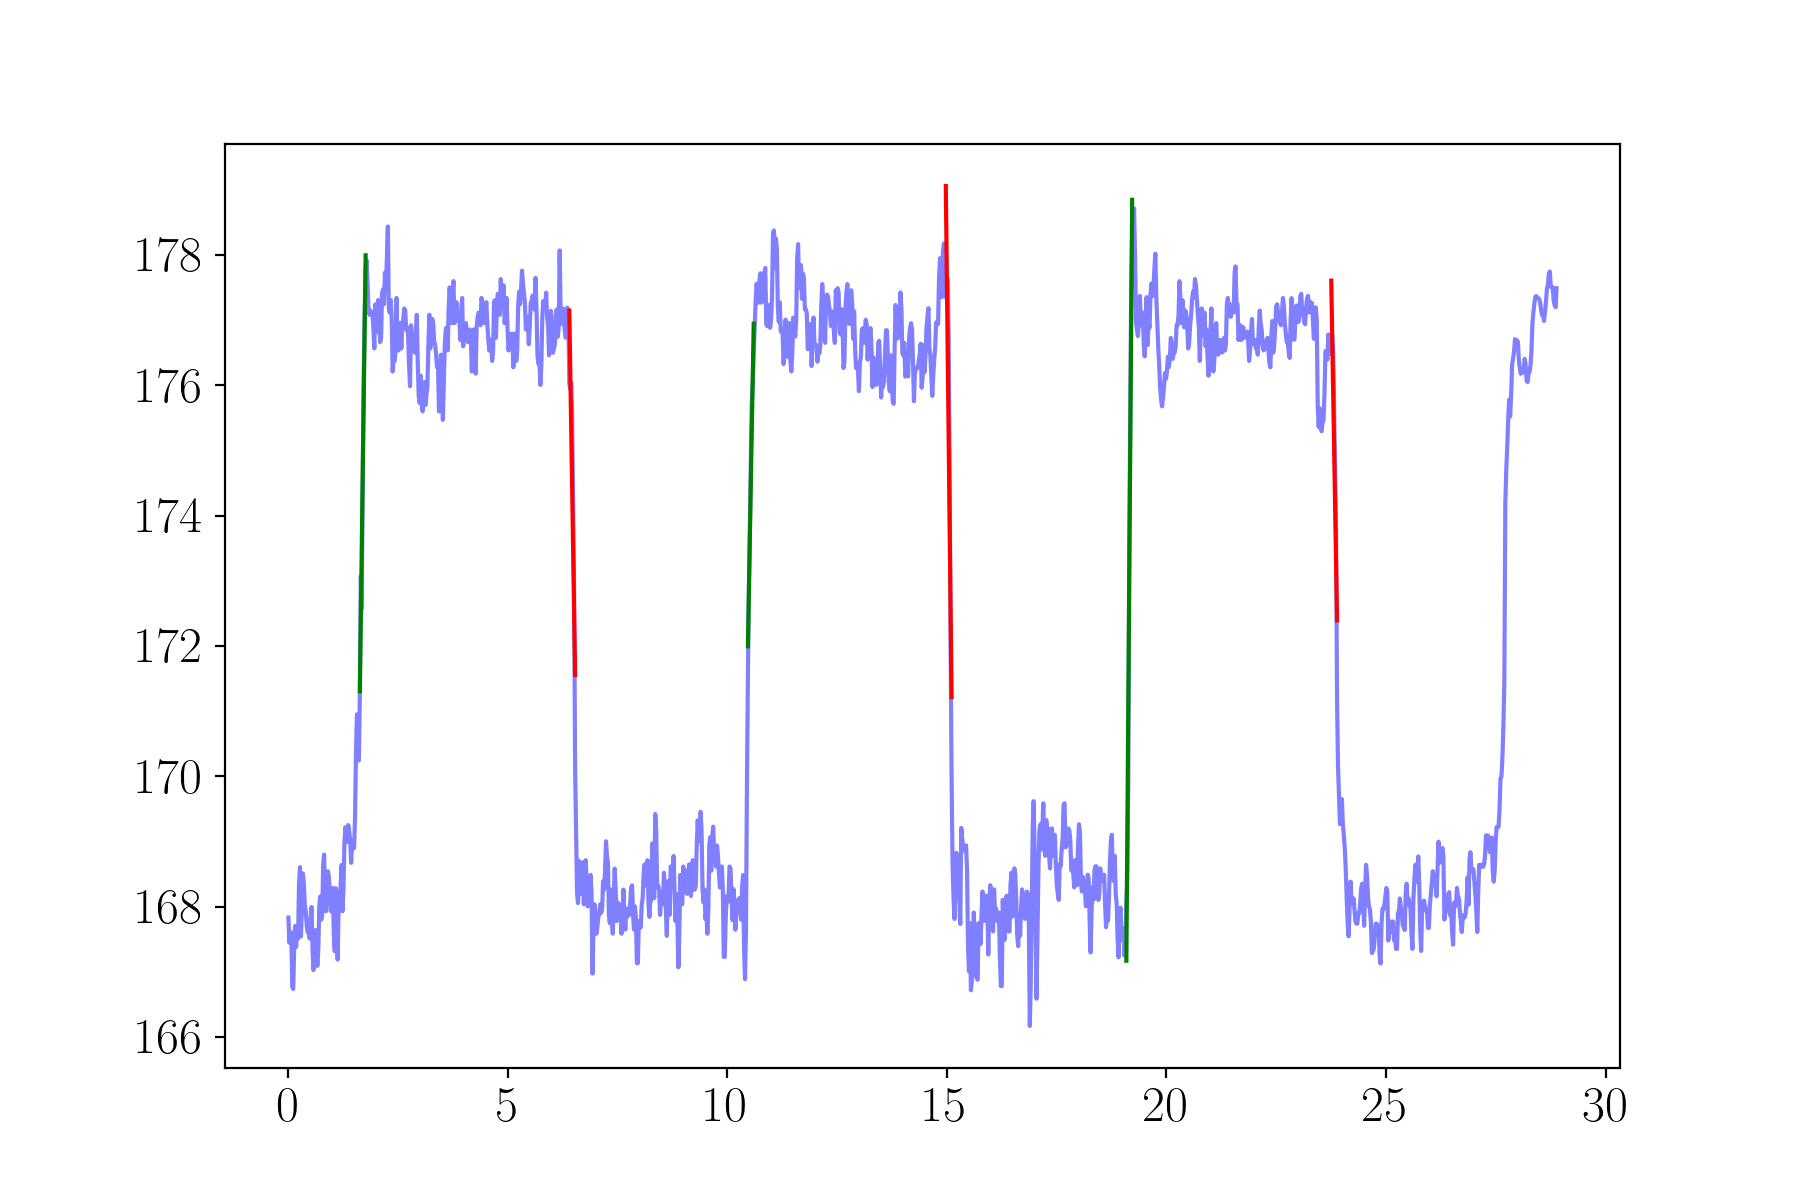

In [24]:
# test on one frame
idx=626

start_range = 3
end_range = 3

if not has_error:
    edges = drop_edges[idx]
else:
    returns = ddt.drop_det_new(Xdata=s, Ydata=means[idx], thr_low=thr_low, thr_high=thr_high,
                               backward_skip=0, forward_skip=0, return_indexes=True, keep_invalid=False,
                               plot_switch=False)
    edges = [returns[2], returns[0], returns[1], returns[3]]

ws_start, ws_end = ddt.slopes(s, means[idx], edges[0], edges[-1], direction='both',
                              start_range=start_range, end_range=end_range, figsize=(9,6))
ns_start, ns_end = ddt.slopes(s, means[idx], edges[1], edges[-2], direction='both',
                              start_range=start_range, end_range=end_range, figsize=(9,6))

In [37]:
ws_start

array([17.01448756, 39.65813482, 62.68081327])

In [25]:
# apply to all
if has_error:
    raise TypeError('Errors already computed: you do not need this cell')


slopes = []

for i, edges in enumerate(drop_edges):
    print(f'frame {i}: ',end='')
    ws_start, ws_end = ddt.slopes(s, means[i], edges[0], edges[-1],
                              start_range=start_range, end_range=end_range, plot_switch=False)
    ns_start, ns_end = ddt.slopes(s, means[i], edges[1], edges[-2],
                                  start_range=start_range, end_range=end_range, plot_switch=False)
    
    slopes.append([ws_start, ns_start, ns_end, ws_end])
    print('ok')

frame 0: ok
frame 1: ok
frame 2: ok
frame 3: ok
frame 4: ok
frame 5: ok
frame 6: ok
frame 7: ok
frame 8: ok
frame 9: ok
frame 10: ok
frame 11: ok
frame 12: ok
frame 13: ok
frame 14: ok
frame 15: ok
frame 16: ok
frame 17: ok
frame 18: ok
frame 19: ok
frame 20: ok
frame 21: ok
frame 22: ok
frame 23: ok
frame 24: ok
frame 25: ok
frame 26: ok
frame 27: ok
frame 28: ok
frame 29: ok
frame 30: ok
frame 31: ok
frame 32: ok
frame 33: ok
frame 34: ok
frame 35: ok
frame 36: ok
frame 37: ok
frame 38: ok
frame 39: ok
frame 40: ok
frame 41: ok
frame 42: ok
frame 43: ok
frame 44: ok
frame 45: ok
frame 46: ok
frame 47: ok
frame 48: ok
frame 49: ok
frame 50: ok
frame 51: ok
frame 52: ok
frame 53: ok
frame 54: ok
frame 55: ok
frame 56: ok
frame 57: ok
frame 58: ok
frame 59: ok
frame 60: ok
frame 61: ok
frame 62: ok
frame 63: ok
frame 64: ok
frame 65: ok
frame 66: ok
frame 67: ok
frame 68: ok
frame 69: ok
frame 70: ok
frame 71: ok
frame 72: ok
frame 73: ok
frame 74: ok
frame 75: ok
frame 76: ok
frame 77:

frame 632: ok
frame 633: ok
frame 634: ok
frame 635: ok
frame 636: ok
frame 637: ok
frame 638: ok
frame 639: ok
frame 640: ok
frame 641: ok
frame 642: ok
frame 643: ok
frame 644: ok
frame 645: ok
frame 646: ok
frame 647: ok
frame 648: ok
frame 649: ok
frame 650: ok
frame 651: ok
frame 652: ok
frame 653: ok
frame 654: ok
frame 655: ok
frame 656: ok
frame 657: ok
frame 658: ok
frame 659: ok
frame 660: ok
frame 661: ok
frame 662: ok
frame 663: ok
frame 664: ok
frame 665: ok
frame 666: ok
frame 667: ok
frame 668: ok
frame 669: ok
frame 670: ok
frame 671: ok
frame 672: ok
frame 673: ok
frame 674: ok
frame 675: ok
frame 676: ok
frame 677: ok
frame 678: ok
frame 679: ok
frame 680: ok
frame 681: ok
frame 682: ok
frame 683: ok
frame 684: ok
frame 685: ok
frame 686: ok
frame 687: ok
frame 688: ok
frame 689: ok
frame 690: ok
frame 691: ok
frame 692: ok
frame 693: ok
frame 694: ok
frame 695: ok
frame 696: ok
frame 697: ok
frame 698: ok
frame 699: ok
frame 700: ok
frame 701: ok
frame 702: ok
frame 

### Make ufloats

In [79]:
def res_error(position):
    a = s[np.where(s >= position)]
    
    return (a[1] - a[0])/np.sqrt(12)
def res_error_idx(index):
    if index < len(s) - 1:
        return (s[index + 1] - s[index])/np.sqrt(12)
    return (s[index] - s[index - 1])/np.sqrt(12)

@np.vectorize
def value(v):
    return v.n

@np.vectorize
def std(v):
    return v.s

@np.vectorize
def ufloatify(m, s):
    return unc.ufloat(m,s)

array([0.0+/-1.0, 1.0+/-2.0], dtype=object)

In [27]:
new_drop_edges = []

if not has_error:
    for i, edges in enumerate(drop_edges):
        print(f'frame {i}: ',end='')
        new_drop_edges.append([])
        for k,e in enumerate(edges):
            new_e = []
            for drop_idx in range(len(e)):
                if k in [0,4]: # wide
                    err_slope = sigma_low/slopes[i][k][drop_idx]
                else: # narrow
                    err_slope = sigma_high/slopes[i][k][drop_idx]

                err = np.sqrt(res_error_idx(e[drop_idx])**2 + err_slope**2)

                new_e.append(unc.ufloat(s[e[drop_idx]], err))

            new_drop_edges[-1].append(new_e)
        new_drop_edges[-1] = np.array(new_drop_edges[-1])

        print('ok')

    # overwrite the previous drop_edges
    drop_edges = new_drop_edges
    has_error = True
    
else:
    print('Errors already computed')

frame 0: ok
frame 1: ok
frame 2: ok
frame 3: ok
frame 4: ok
frame 5: ok
frame 6: ok
frame 7: ok
frame 8: ok
frame 9: ok
frame 10: ok
frame 11: ok
frame 12: ok
frame 13: ok
frame 14: ok
frame 15: ok
frame 16: ok
frame 17: ok
frame 18: ok
frame 19: ok
frame 20: ok
frame 21: ok
frame 22: ok
frame 23: ok
frame 24: ok
frame 25: ok
frame 26: ok
frame 27: ok
frame 28: ok
frame 29: ok
frame 30: ok
frame 31: ok
frame 32: ok
frame 33: ok
frame 34: ok
frame 35: ok
frame 36: ok
frame 37: ok
frame 38: ok
frame 39: ok
frame 40: ok
frame 41: ok
frame 42: ok
frame 43: ok
frame 44: ok
frame 45: ok
frame 46: ok
frame 47: ok
frame 48: ok
frame 49: ok
frame 50: ok
frame 51: ok
frame 52: ok
frame 53: ok
frame 54: ok
frame 55: ok
frame 56: ok
frame 57: ok
frame 58: ok
frame 59: ok
frame 60: ok
frame 61: ok
frame 62: ok
frame 63: ok
frame 64: ok
frame 65: ok
frame 66: ok
frame 67: ok
frame 68: ok
frame 69: ok
frame 70: ok
frame 71: ok
frame 72: ok
frame 73: ok
frame 74: ok
frame 75: ok
frame 76: ok
frame 77:

## Plots

<IPython.core.display.Javascript object>


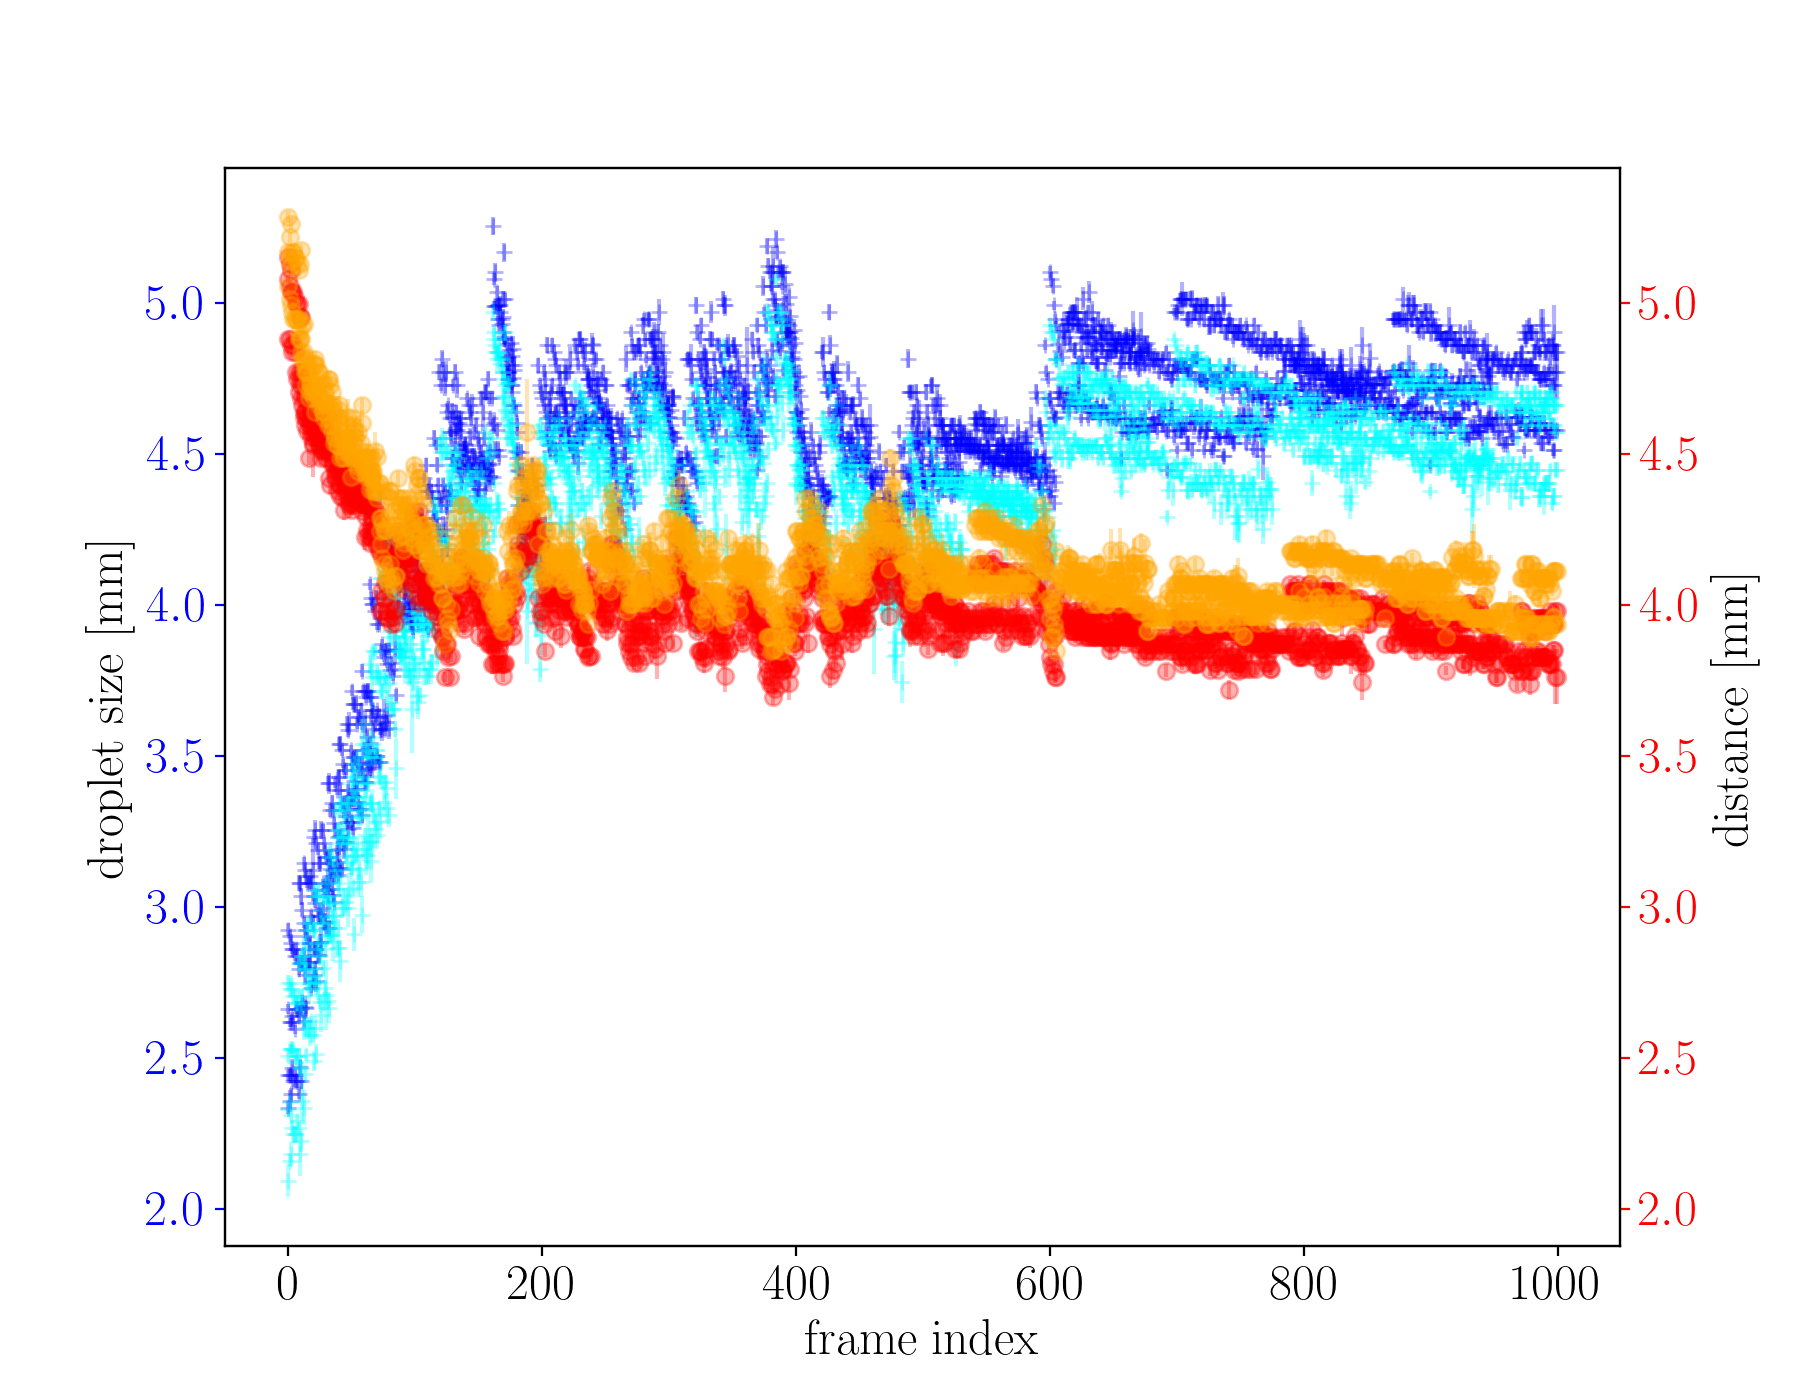

(1.876176155918827, 5.446553167021761)

In [40]:
subname = 'size-distance'

wavelenghts = [(i,edges[:,1:] - edges[:,:-1]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 1]

sizes_w = [(i, edges[3] - edges[0]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 0]
sizes_n = [(i, edges[2] - edges[1]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 0]

distances_w = [(i,edges[0,1:] - edges[3,:-1]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 1]
distances_n = [(i,edges[1,1:] - edges[2,:-1]) for i,edges in enumerate(drop_edges) if len(edges[0]) > 1]

fig, ax1 = plt.subplots(figsize=(9,7))
for si in sizes_w:
    uplt.plot([si[0]]*len(si[1]), si[1], ax=ax1, color='blue', fmt='+', alpha=0.3)
for si in sizes_n:
    uplt.plot([si[0]]*len(si[1]), si[1], ax=ax1, color='cyan', fmt='+', alpha=0.3)
ax1.set_xlabel('frame index')
ax1.set_ylabel('droplet size [mm]')
ax1.tick_params(axis='y', colors='blue')
    
ax2 = ax1.twinx()


for si in distances_w:
    uplt.plot([si[0]]*len(si[1]), si[1], ax=ax2, color='red', fmt='o', alpha=0.3)
for si in distances_n:
    uplt.plot([si[0]]*len(si[1]), si[1], ax=ax2, color='orange', fmt='o', alpha=0.3)
ax2.set_ylabel('distance [mm]')


# colors = ['yellow', 'orange', 'red', 'brown']
# for i in range(4):
#     for d in wavelenghts:
#         uplt.plot([d[0]]*len(d[1][0]), d[1][i], ax=ax2, color=colors[i], fmt='o', alpha=0.3)
# ax2.set_ylabel('wavelenght [mm]')


ax2.tick_params(axis='y', colors='red')

ylim1 = ax1.get_ylim()
ylim2 = ax2.get_ylim()

ylim = (min(ylim1[0], ylim2[1]), max(ylim1[1], ylim2[1]))
        
ax1.set_ylim(*ylim)
ax2.set_ylim(*ylim)


# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Following the droplets along the video

In [65]:
# DO NOT TRANSFER TO .py file !!!! uses local variables

class Droplet():
    def __init__(self,ID):
        self.ID = ID
        self.frames = [] # frame IDs in which the droplet appears
        self.index_in_frame = [] # index of the droplet in every frame in which it appears
        
        self.edges = np.array([])
        
        self._mids = None
        
        self.sizes = None
        self.velocities = None
        
    def index(self, frame_idx):
        return self.frames.index(frame_idx)
        
    @property
    def recurrence(self):
        return len(self.frames) # number of frames in which the droplet is visible
    
    @property
    def size(self):
        if self.sizes is None:
            self.sizes = np.array([[(edge[3] - edge[0]), (edge[2] - edge[1])] for edge in self.edges])
        return np.mean(self.sizes, axis=0), np.std(value(self.sizes), axis=0) # cannot compute error on std
    
    @property
    def mid_positions(self):
        if self._mids is None:
            self._mids = np.array([[0.5*(edge[0] + edge[3]), 0.5*(edge[1] + edge[2])] for edge in self.edges])
        return self._mids
    
    @property
    def velocity(self):
        if self.velocities is None:
            if len(self.frames) > 1:
                self.velocities = (self.mid_positions[1:] - self.mid_positions[:-1])/spf
            else:
                return np.nan, np.nan
        return np.mean(self.velocities, axis=0), np.std(value(self.velocities), axis=0)
    
        
    def add(self, frame_id, idx_in_frame, velocity_range=None, size_perc_tolerance=None):
        '''
        Tries to add a new frame to the droplet. Returns True if it manages to.
        '''
        edge = drop_edges[frame_id][:,idx_in_frame]
        
        if len(self.frames) > 0:
        
            # check if velocity is meaningful
            if velocity_range is not None:
                velocity = (self.edges[-1,1] - edge[1])/spf # compute velocity with narrow start
                if velocity < velocity_range[0]:
                    return False
                if velocity > velocity_range[1]:
                    return False

            # check if size is similar to the previous one
            if size_perc_tolerance is not None:
                old_size = self.edges[-1,2]- self.edges[-1,1] # narrow size
                size = edge[2] - edge[1]
                if np.abs(size - old_size) > old_size*size_perc_tolerance:
                    return False
                
        self.frames.append(frame_id)
        self.index_in_frame.append(idx_in_frame)
        self.edges = np.vstack([*self.edges, edge])
        
        self._mids = None
        self.velocities = None
        self.sizes = None
        
        return True

In [38]:
print(f'expected velocity is {v:.3f} mm/s')

expected velocity is 0.943 mm/s


In [61]:
a = np.array([1,2,3])
b = np.array([1,2,3])
e = np.array([])

e = np.vstack([*e, a])
np.vstack([*e, b])

array([[1, 2, 3],
       [1, 2, 3]])

100%|██████████| 999/999 [00:00<00:00, 4025.13it/s]


<IPython.core.display.Javascript object>


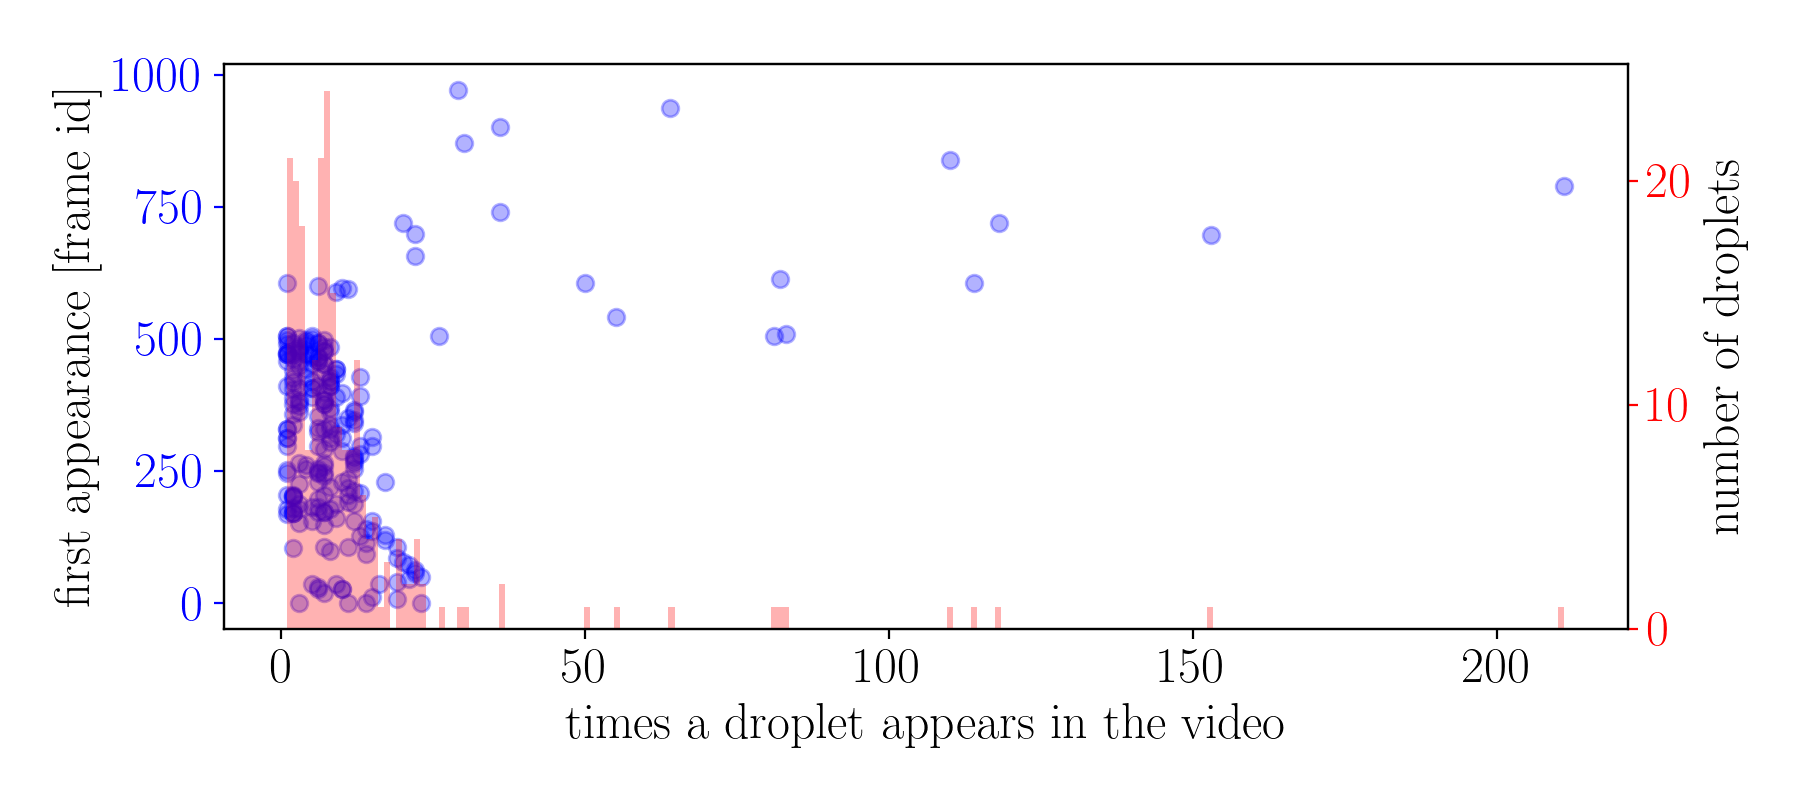

In [68]:
velocity_range = [0, 5]
size_perc_tolerance = 0.5


droplets = []
drop_idx = 0

# create ID mask
ID_mask = []
for edges in drop_edges:
    ID_mask.append([-1]*edges.shape[-1])

# iterate over frame
for idx in tqdm(range(len(drop_edges) - 1)):
    frame_idx = len(drop_edges) - 1 - idx # go reversed
    # iterate over droplets in a frame
    for i,start in enumerate(drop_edges[frame_idx][1]): # cycle on narrow starts
        # detect if droplet is already present
        drop_ID = ID_mask[frame_idx][i]
        if drop_ID == -1: # add new droplet
            ID_mask[frame_idx][i] = drop_ID = drop_idx
            droplets.append(Droplet(drop_idx))
            droplets[drop_idx].add(frame_idx,i)
            drop_idx += 1
        
        # now all droplets in this frame have a valid ID
        # we try to find them in the previous frame (remember we are looking the video in reverse)
        prev_frame_idx = frame_idx - 1
        for prev_i,prev_start in enumerate(drop_edges[prev_frame_idx][1]):
            if ID_mask[prev_frame_idx][prev_i] != -1: # droplet already assigned
                continue
            if droplets[drop_ID].add(prev_frame_idx,prev_i,
                                     velocity_range=velocity_range,
                                     size_perc_tolerance=size_perc_tolerance):
                ID_mask[prev_frame_idx][prev_i] = drop_ID # assign droplet
                break
                
droplets = np.array(droplets,dtype=Droplet)
                
def drops_in_frame(frame_idx):
    drop_ids = ID_mask[frame_idx]
    ddt.drop_det_new(Xdata=s, Ydata=means[frame_idx], backward_skip=0, forward_skip=0,
                     thr_low=thr_low, thr_high=thr_high, plot_switch=True, keep_invalid=False,
                     figsize=(9,4))
    
    for drop in droplets[drop_ids]:
        i = drop.frames.index(frame_idx)
        i_drop = drop.index(frame_idx)
        x = value(drop.mid_positions[i_drop][1]) # use narrow mid position
        y = 0.5*(thr_high + thr_low)
        plt.scatter(x,y,color='black',marker='^')
        plt.text(x,y + 0.25,drop.ID, horizontalalignment='center')
                
    return drop_ids


recurrencies = [d.recurrence for d in droplets]
first_appearances = [d.frames[-1] for d in droplets]

# compute size and velocities
for d in droplets:
    _ = d.velocity
    _ = d.size

subname = 'recurrencies'    

fig, ax1 = plt.subplots(figsize=(9,4))
ax1.scatter(recurrencies, first_appearances, color='blue', alpha=0.3)
ax1.set_xlabel('times a droplet appears in the video')
ax1.set_ylabel('first appearance [frame id]')
ax1.tick_params(axis='y', colors='blue')

ax2 = ax1.twinx()




ax2.hist(recurrencies, bins=max(recurrencies), color='red', alpha=0.3)
ax2.set_ylabel('number of droplets')
ax2.tick_params(axis='y', colors='red')

fig.tight_layout()

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

2 2
2 2


<IPython.core.display.Javascript object>


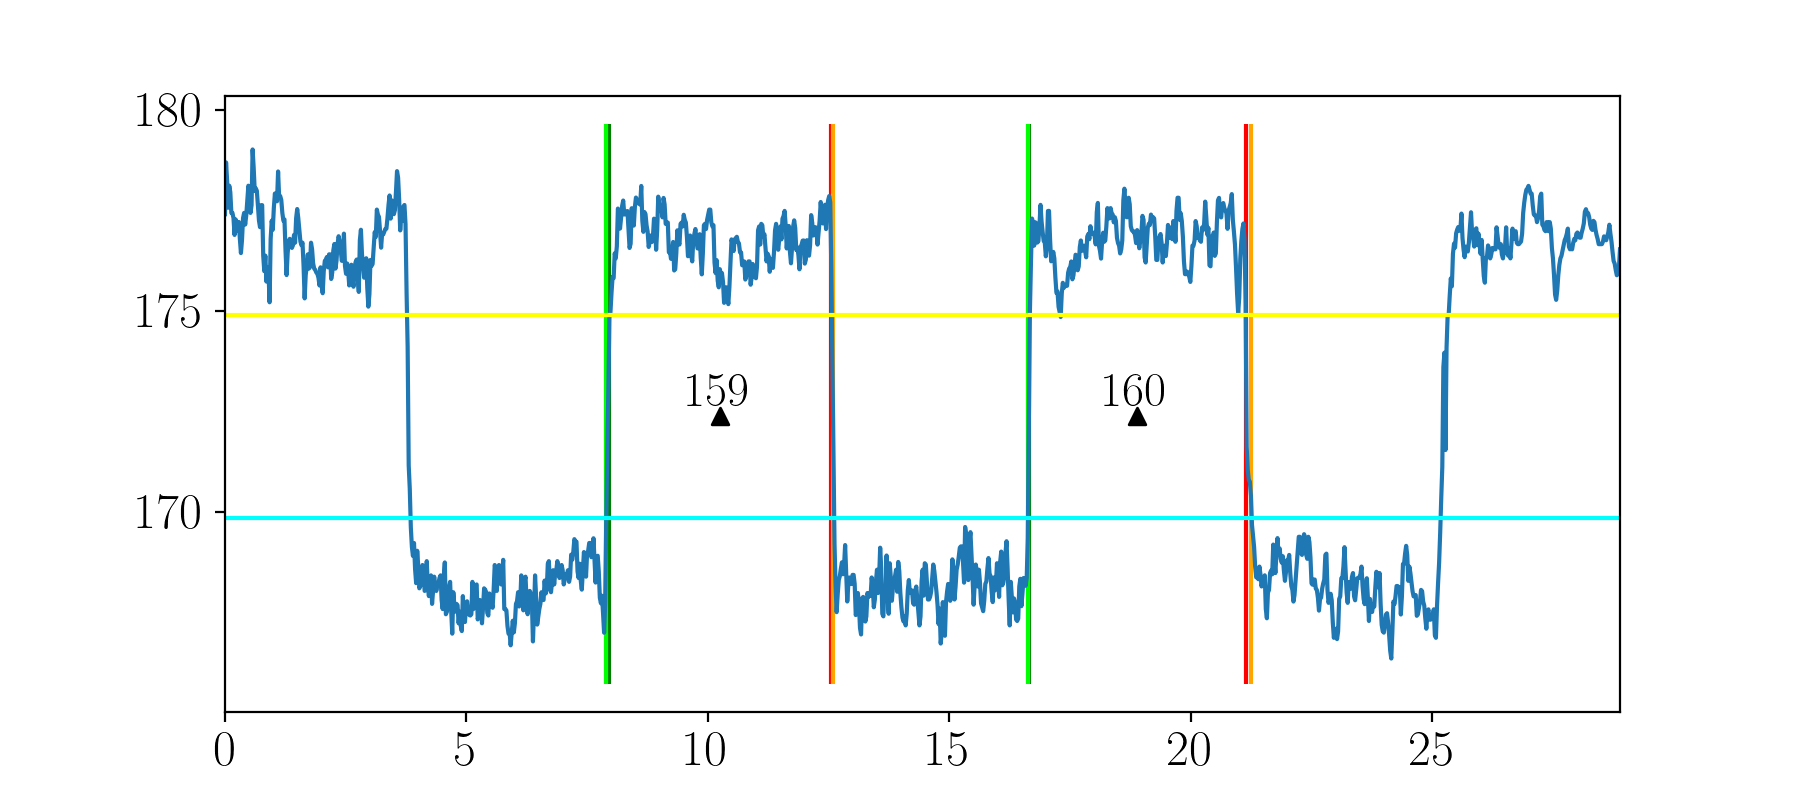

[159, 160]

In [69]:
# reload(plt)
# %matplotlib notebook
idx = 212
drops_in_frame(idx)

3 3
3 3


<IPython.core.display.Javascript object>


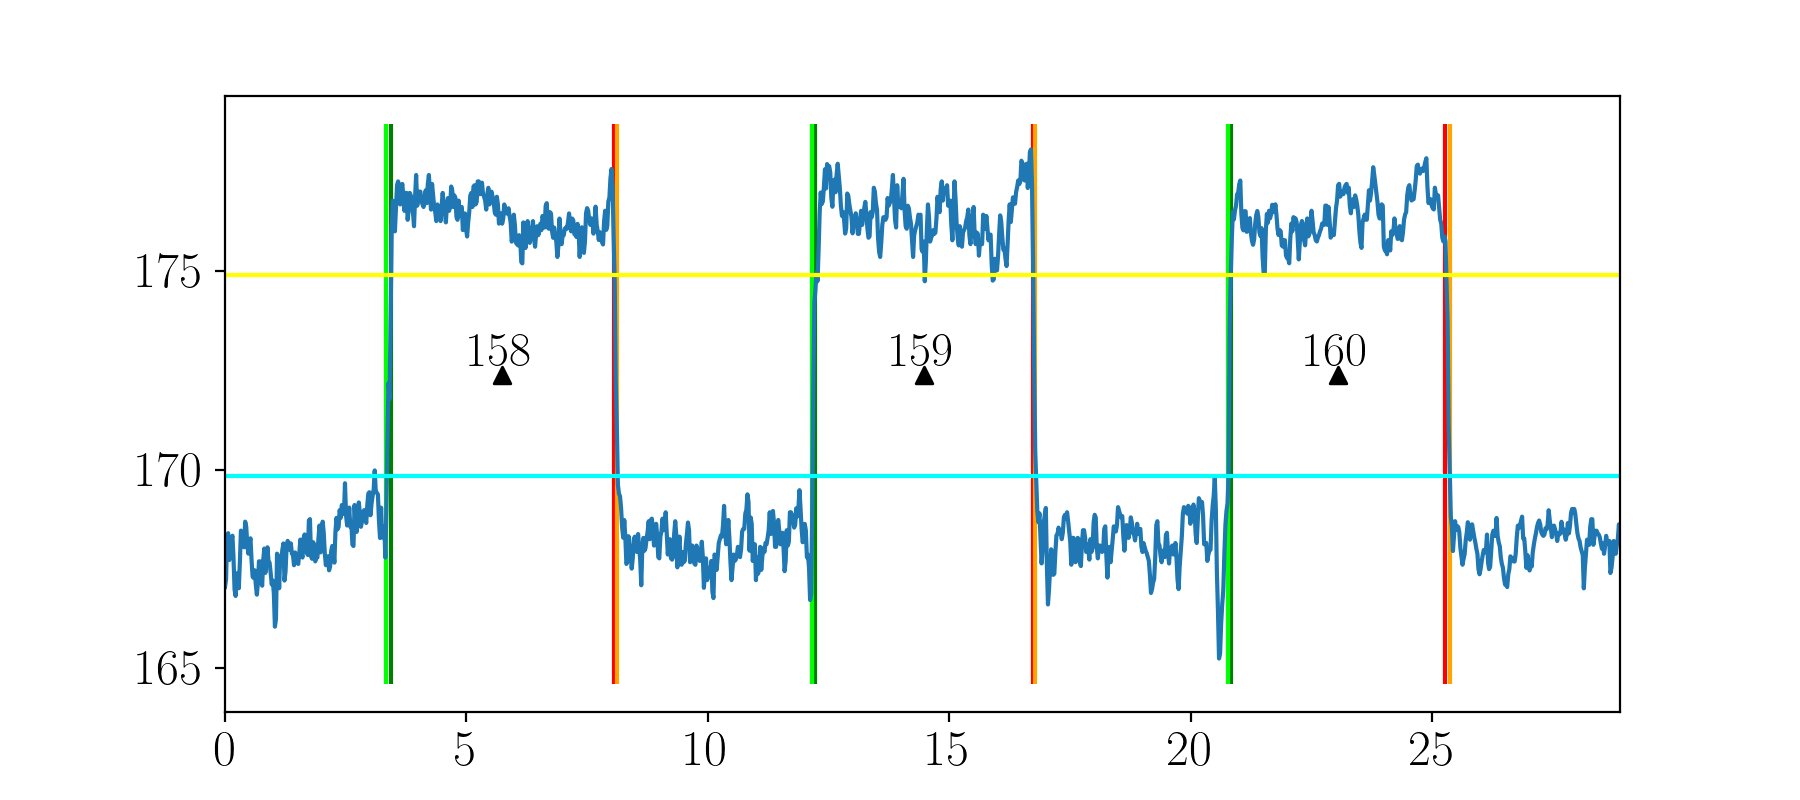

[158, 159, 160]

In [70]:
drops_in_frame(idx + 1)

3 3
3 3


<IPython.core.display.Javascript object>


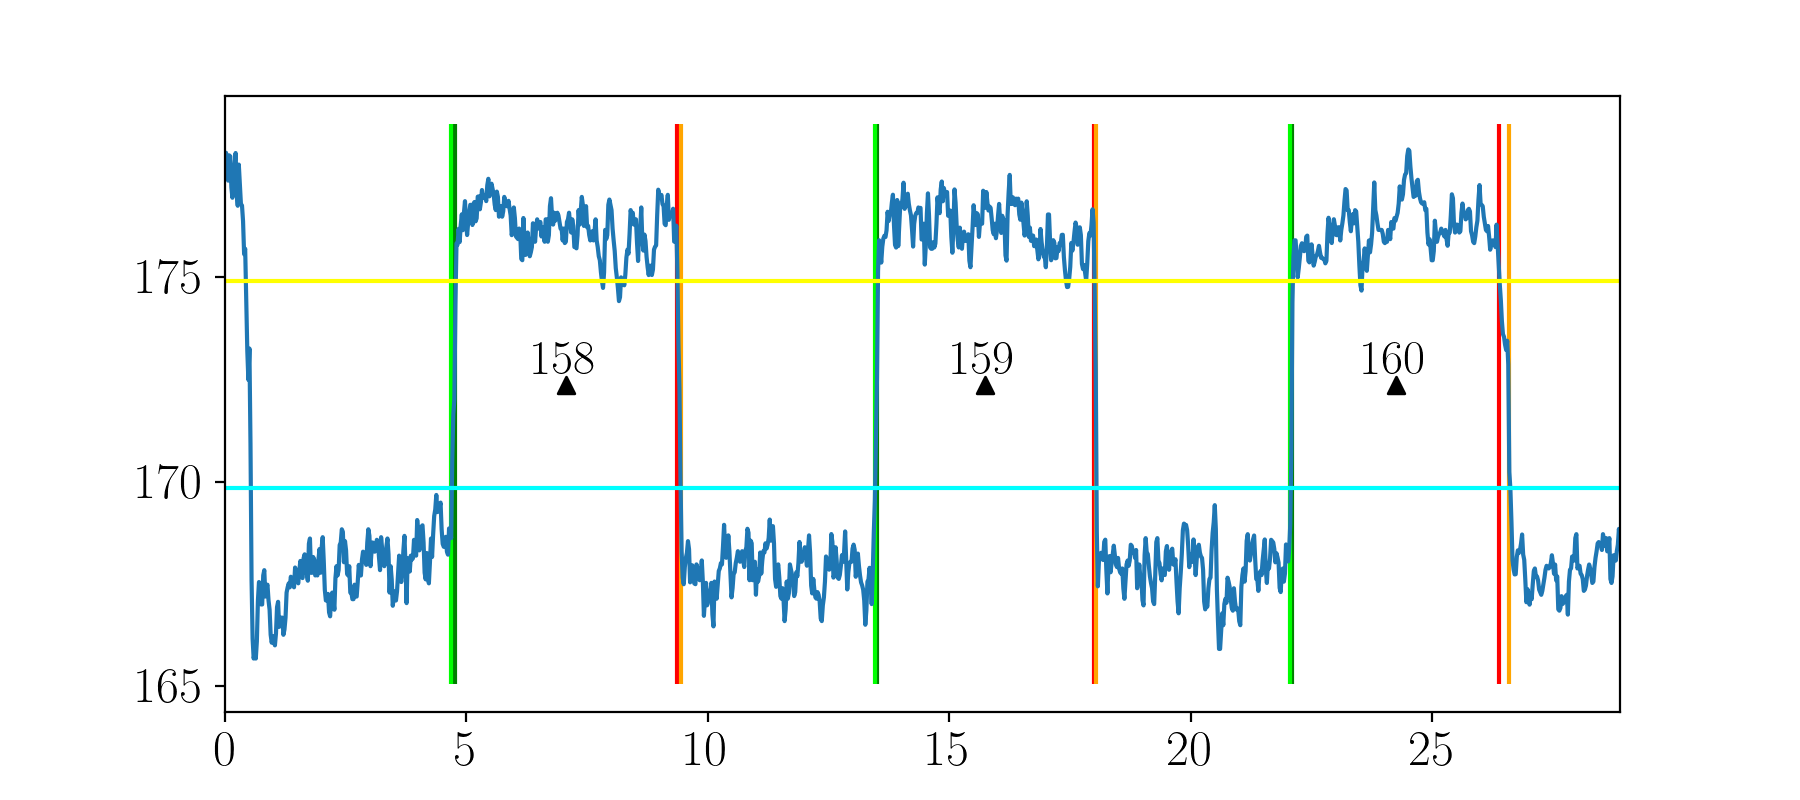

[158, 159, 160]

In [71]:
drops_in_frame(idx + 2)

## Droplet statistics

In [123]:
def side_hist_plot(xdata, ydata, bins=30, external_axes=None, **kwargs):
    '''
    Makes a plot of 'ydata' vs 'xdata' with a kde plot of 'ydata' on its right.
    
    Params:
        'xdata': array-like
        'ydata': array-like of ufloats
        'bins': number of points for the kde plot
        'external_axes': tupple of size 2, external axes on which to do the plot
        
        **kwargs:
            figsize
            xlabel
            ylabel
            title
            
            label: label to create a legend in the plot
            fit_color: color of the fit line
            fit_linestyle
            
    Returns:
        fig: plt.figure
        axes: (ax_plot, ax_hist)
        fit_params: array of ufloats: [center, sigma] of the gaussian used for the fit.
    '''
    
    figsize = kwargs.pop('figsize', (10,7))
    xlabel = kwargs.pop('xlabel', None)
    ylabel = kwargs.pop('ylabel', None)
    title = kwargs.pop('title', None)
    
    label = kwargs.pop('label', None)
    fit_color = kwargs.pop('fit_color', 'red')
    fit_linestyle = kwargs.pop('fit_linestyle', None)
    
    
    
    fig = None
    ax_plot = None
    ax_hist = None
    
    if external_axes is None:   
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(4,5)

        ax_plot = fig.add_subplot(gs[1:4,0:3])
        ax_hist = fig.add_subplot(gs[1:4,3:4])
    
    else:
        ax_plot, ax_hist = external_axes
        fig = ax_plot.figure
    
    # plot
    uplt.plot(xdata, ydata, ax=ax_plot, label=label, **kwargs)
    if label is not None:
        ax_plot.legend()
    if xlabel is not None:
        ax_plot.set_xlabel(xlabel)
    if ylabel is not None:
        ax_plot.set_ylabel(ylabel)
    if title is not None:
        ax_plot.set_title(title)
        
    # hist
    kernel = uplt.ExtendedKDE(ydata)
    
    x1,f1 = kernel.plot(points=bins, xrange=ax_plot.get_ylim(), ax=ax_hist, switch_xy=True, **kwargs)
    
    plt.setp(ax_hist.get_yticklabels(), visible=False) #Turn off tick labels
    
    # gaussian fit
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_hist.plot(out1.best_fit, x1, color=fit_color, linestyle=fit_linestyle)
    
    # get fit parameters
    dist1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_dist1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
    
    fit_params = np.array([dist1, sigma_dist1])
    
    return fig, (ax_plot, ax_hist), fit_params

### Size

In [75]:
droplets[0].size

(array([4.869107841284639+/-0.005952491877320165,
        4.668187010088684+/-0.004511443363955643], dtype=object),
 array([0.03245203, 0.02834867]))

<IPython.core.display.Javascript object>


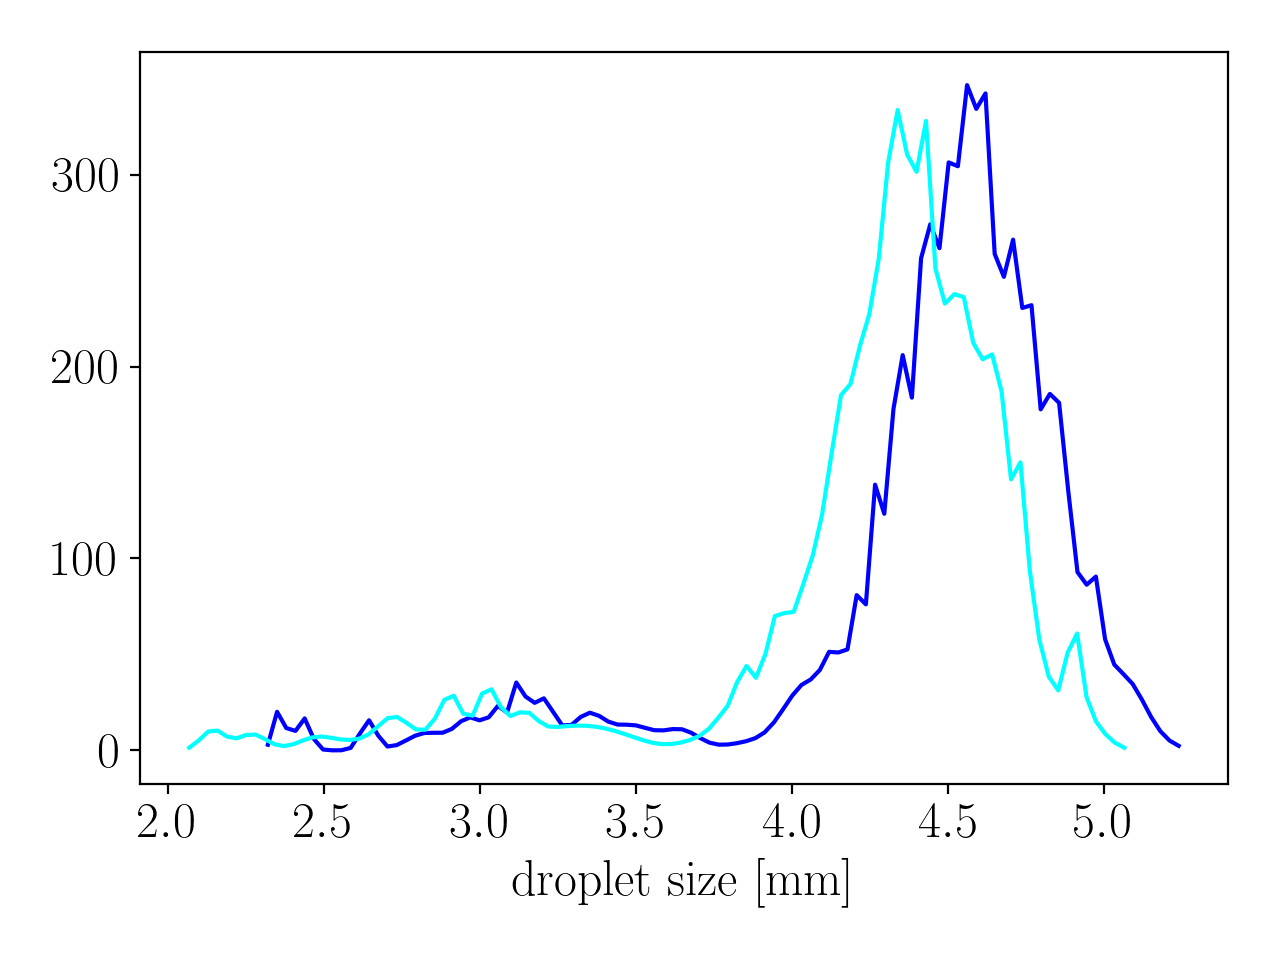

100%|██████████| 100/100 [00:02<00:00, 38.52it/s]

204


In [100]:
# size

min_recurrence = 2

size_means = np.array([d.size[0] for d in droplets if d.recurrence >= min_recurrence])
size_stds = np.array([d.size[1] for d in droplets if d.recurrence >= min_recurrence])

drop_ids = np.array([d.ID for d in droplets if d.recurrence >= min_recurrence])

s_w = ufloatify(value(size_means[:,0]), size_stds[:,0])
s_n = ufloatify(value(size_means[:,1]), size_stds[:,1])

kernel_w = uplt.ExtendedKDE(s_w)
kernel_n = uplt.ExtendedKDE(s_n)

# kernel_w = uplt.ExtendedKDE(size_means[:,0])
# kernel_n = uplt.ExtendedKDE(size_means[:,1])

# histogram
fig, ax = plt.subplots()
kernel_w.plot(points=100, color='blue')
kernel_n.plot(points=100, color='cyan')
plt.xlabel('droplet size [mm]')
# plt.ylabel('counts')

fig.tight_layout()

print(len(size_means))

<IPython.core.display.Javascript object>


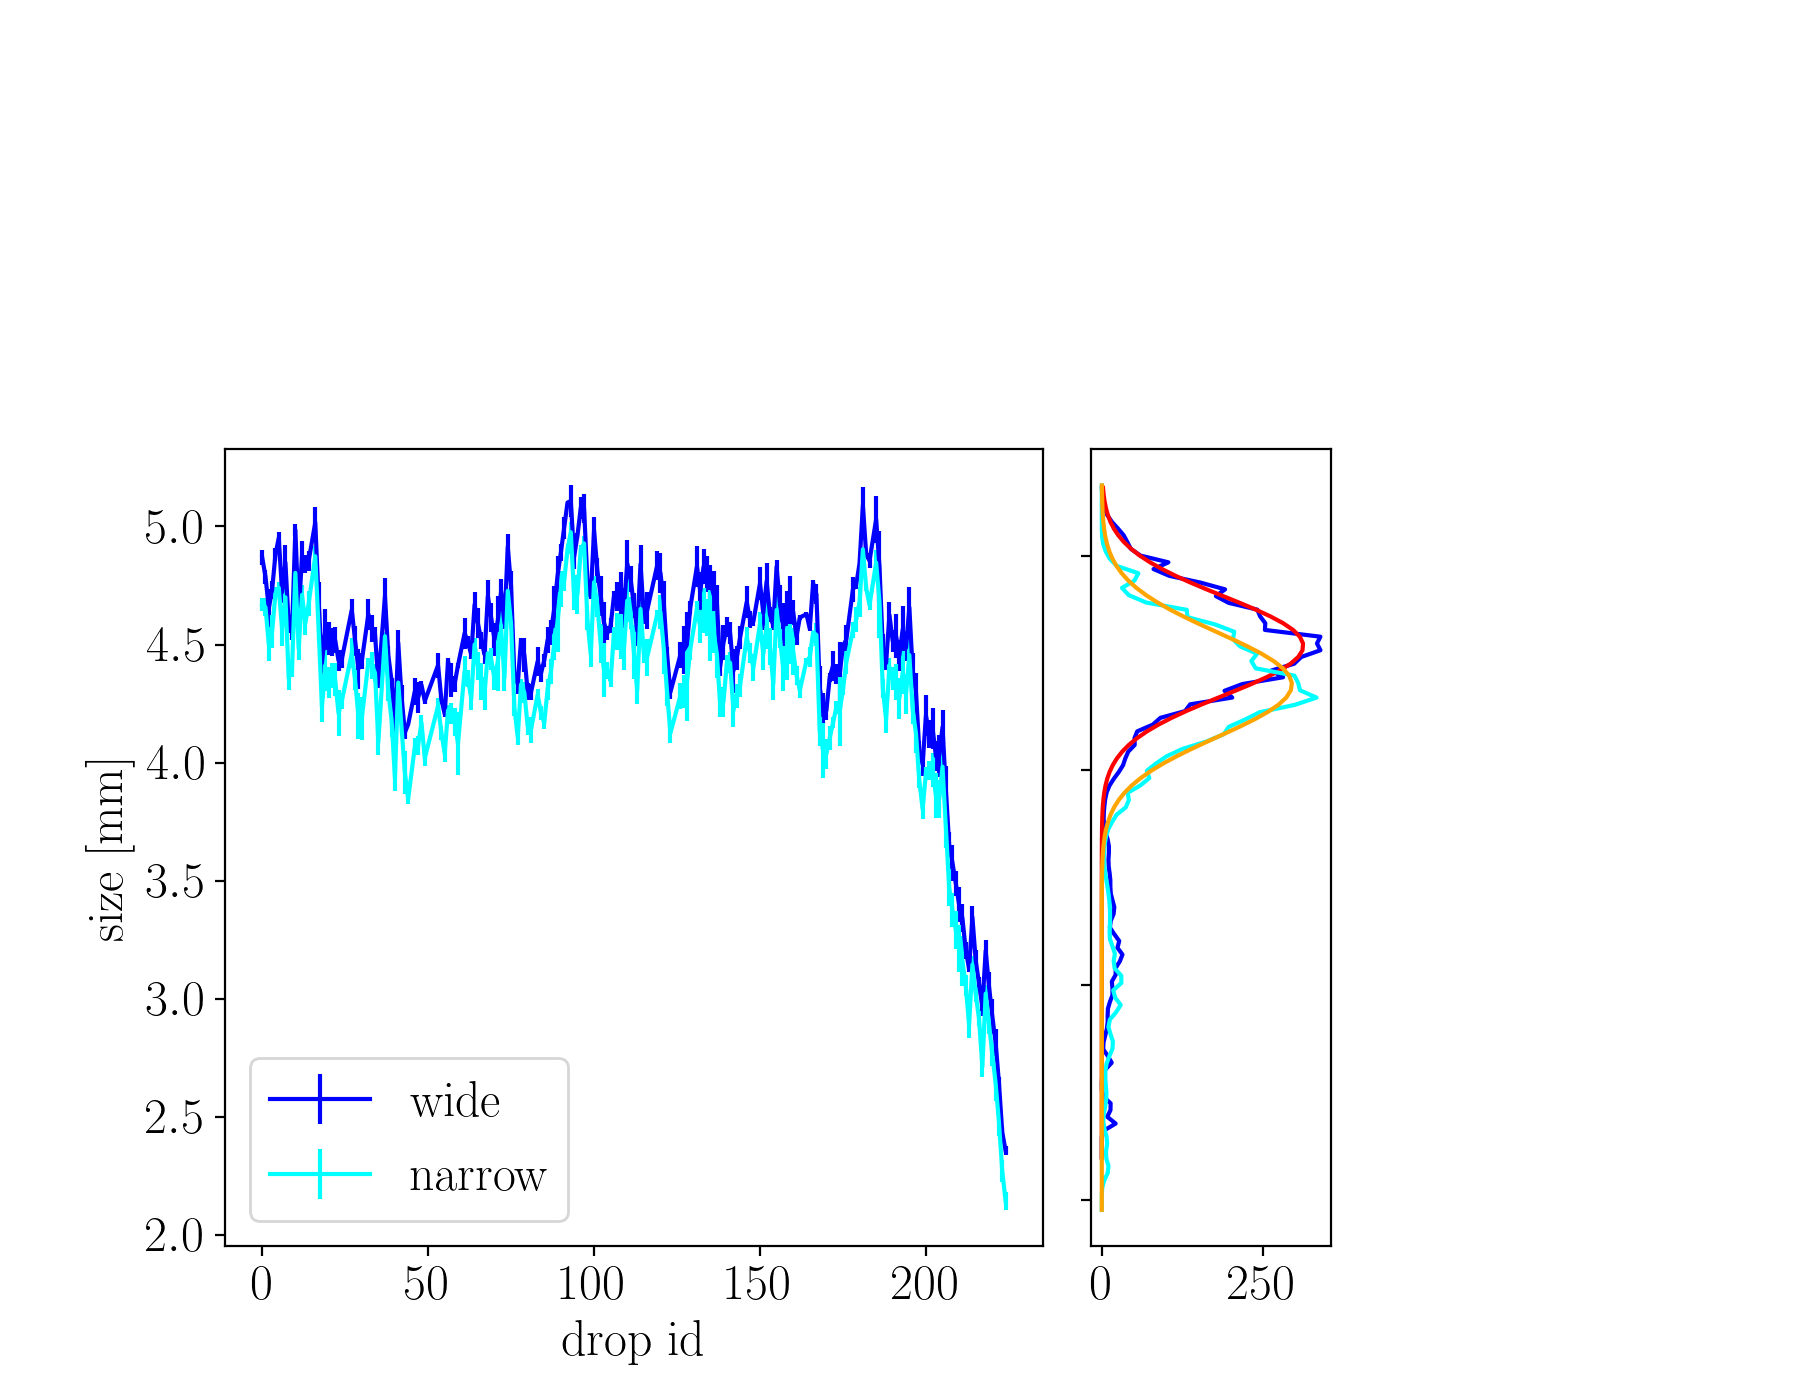

100%|██████████| 100/100 [00:02<00:00, 38.22it/s]


[4.579590311970085+/-0.004291778323187859
 0.23020598697342698+/-0.004292691598294716]
[4.399031141330426+/-0.004901131999546308
 0.24422363342887055+/-0.004901097104873426]


In [125]:
subname = 'size'

fig, axes, fit_params_w = side_hist_plot(drop_ids, s_w, bins=100, figsize=(9,7),
                                         color='blue', fit_color='red', label='wide',
                                         xlabel='drop id', ylabel='size [mm]')

fig, axes, fit_params_n = side_hist_plot(drop_ids, s_n, bins=100, figsize=(9,7), external_axes=axes,
                                         color='cyan', fit_color='orange', label='narrow')

print(fit_params_w)
print(fit_params_n)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


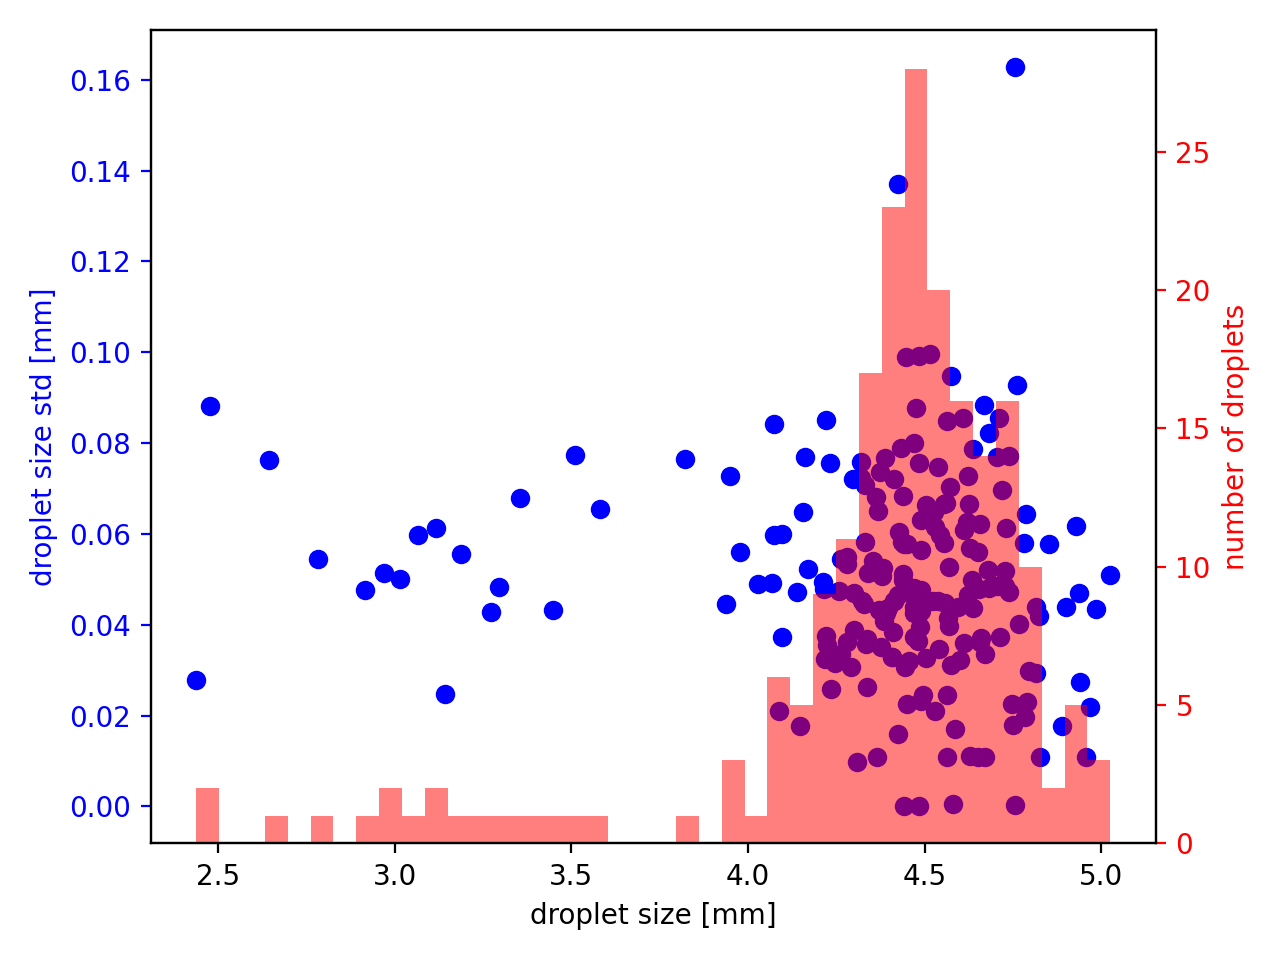

In [56]:
# size - size_std correlation
subname = 'size_hist'

fig, ax1 = plt.subplots()
ax1.scatter(size_means, size_stds, color='blue')

ax2 = ax1.twinx()
ax2.hist(size_means, bins=40, alpha=0.5, color='red')

ax1.set_xlabel('droplet size [mm]')
ax1.set_ylabel('droplet size std [mm]')
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y', colors='blue')

ax2.set_ylabel('number of droplets')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

fig.tight_layout()

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


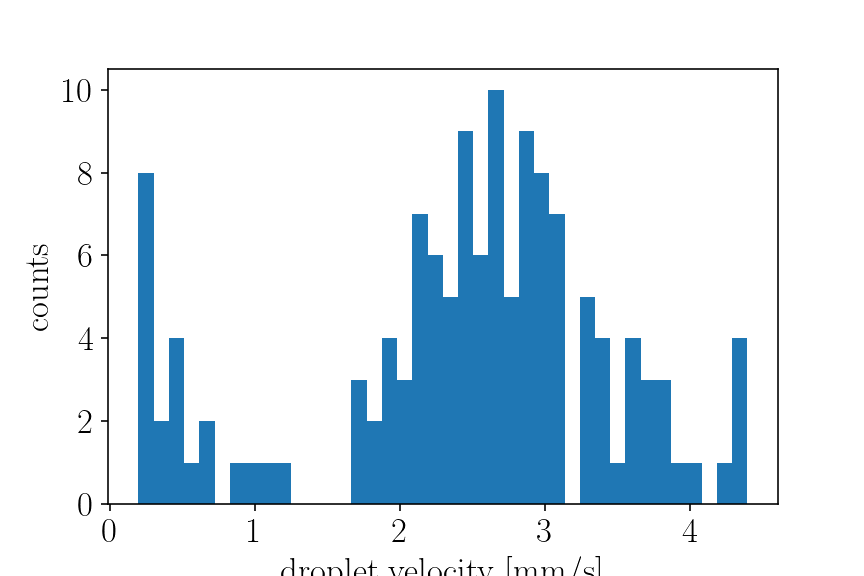

132


In [113]:
# velocity

# at least 2 otherwise cannot compute velocity
min_recurrence = 2

velocity_means = [d.velocity[0] for d in droplets if d.recurrence >= min_recurrence]
velocity_stds = [d.velocity[1] for d in droplets if d.recurrence >= min_recurrence]

# histogram
plt.figure()
plt.hist(velocity_means,bins=40)
plt.xlabel('droplet velocity [mm/s]')
plt.ylabel('counts')

print(len(velocity_means))

<IPython.core.display.Javascript object>


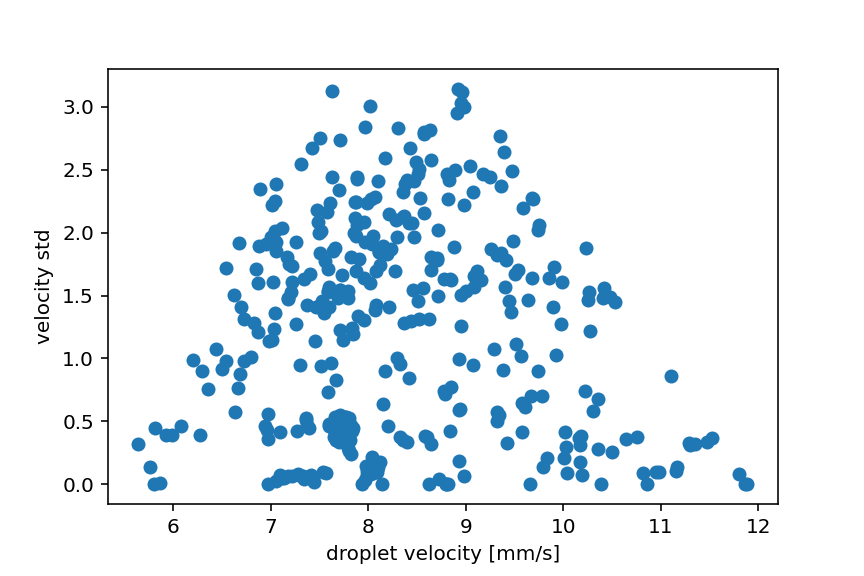

Text(0, 0.5, 'velocity std')

In [132]:
# velocity - velocity_std correlation
plt.figure()
plt.scatter(velocity_means,velocity_stds)
plt.xlabel('droplet velocity [mm/s]')
plt.ylabel('velocity std')

10000it [00:09, 1085.43it/s]


<IPython.core.display.Javascript object>


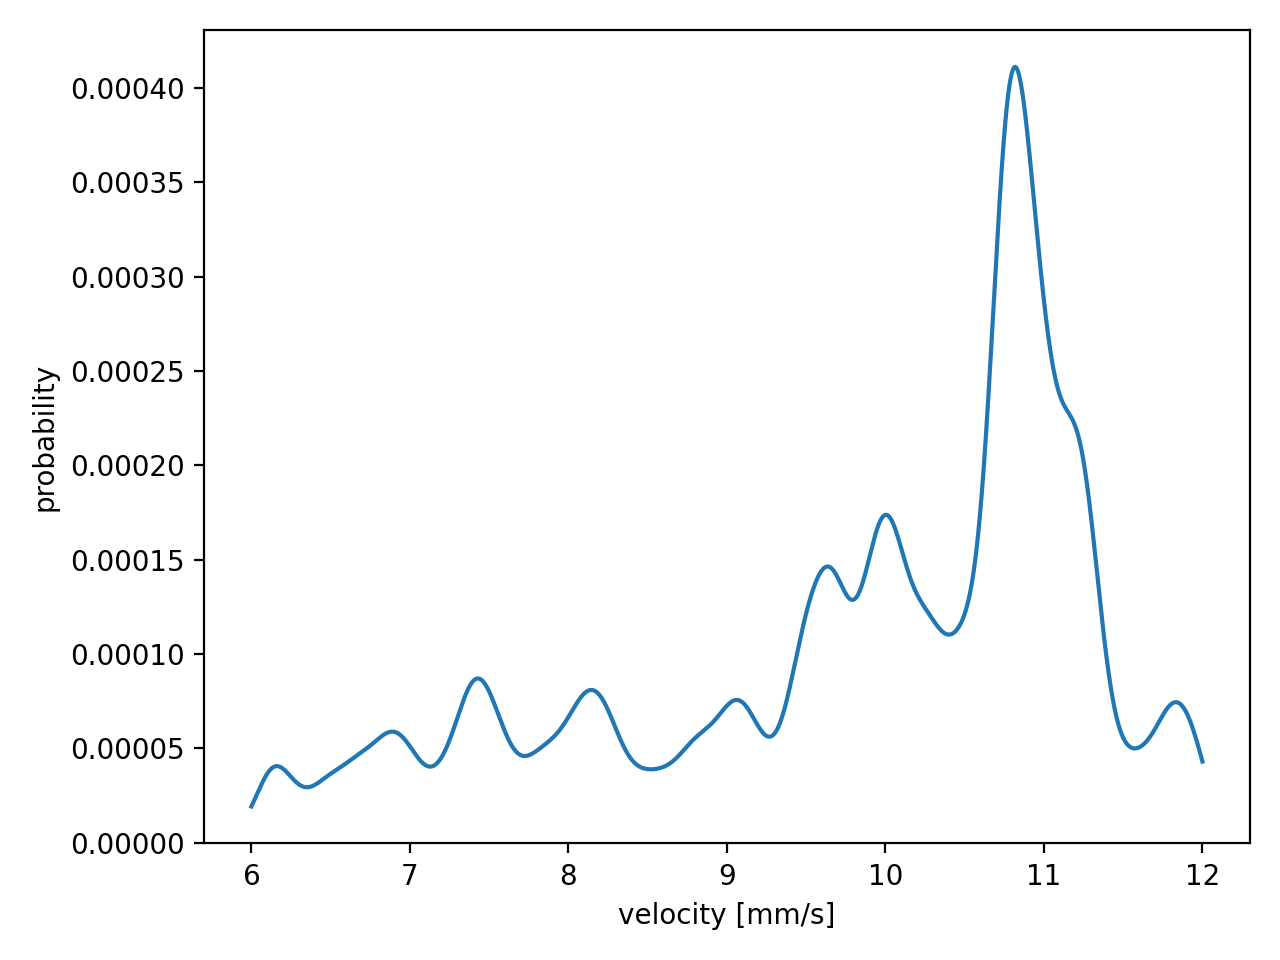

array([1.92251357e-05, 1.93289914e-05, 1.94331427e-05, ...,
       4.34178144e-05, 4.32332270e-05, 4.30486182e-05])

In [97]:
# kde plot

vs = np.linspace(6,12,10000)

kde_plot(vs, velocity_means, velocity_stds, min_sigma=0.1, xlabel='velocity [mm/s]')

<IPython.core.display.Javascript object>


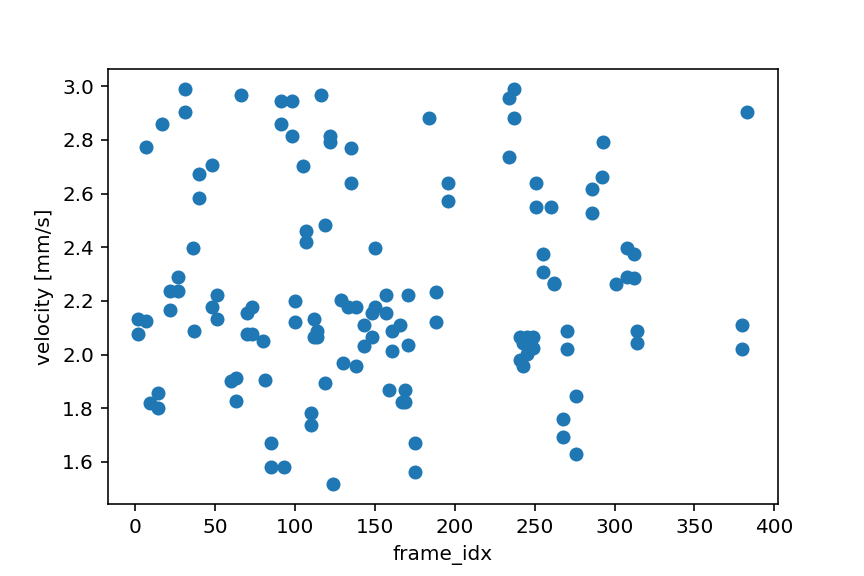

Text(0, 0.5, 'velocity [mm/s]')

In [80]:
# velocity - frame_id correlation

frames_idxs = [d.frames[-1] for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.scatter(frames_idxs, velocity_means)
plt.xlabel('frame_idx')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


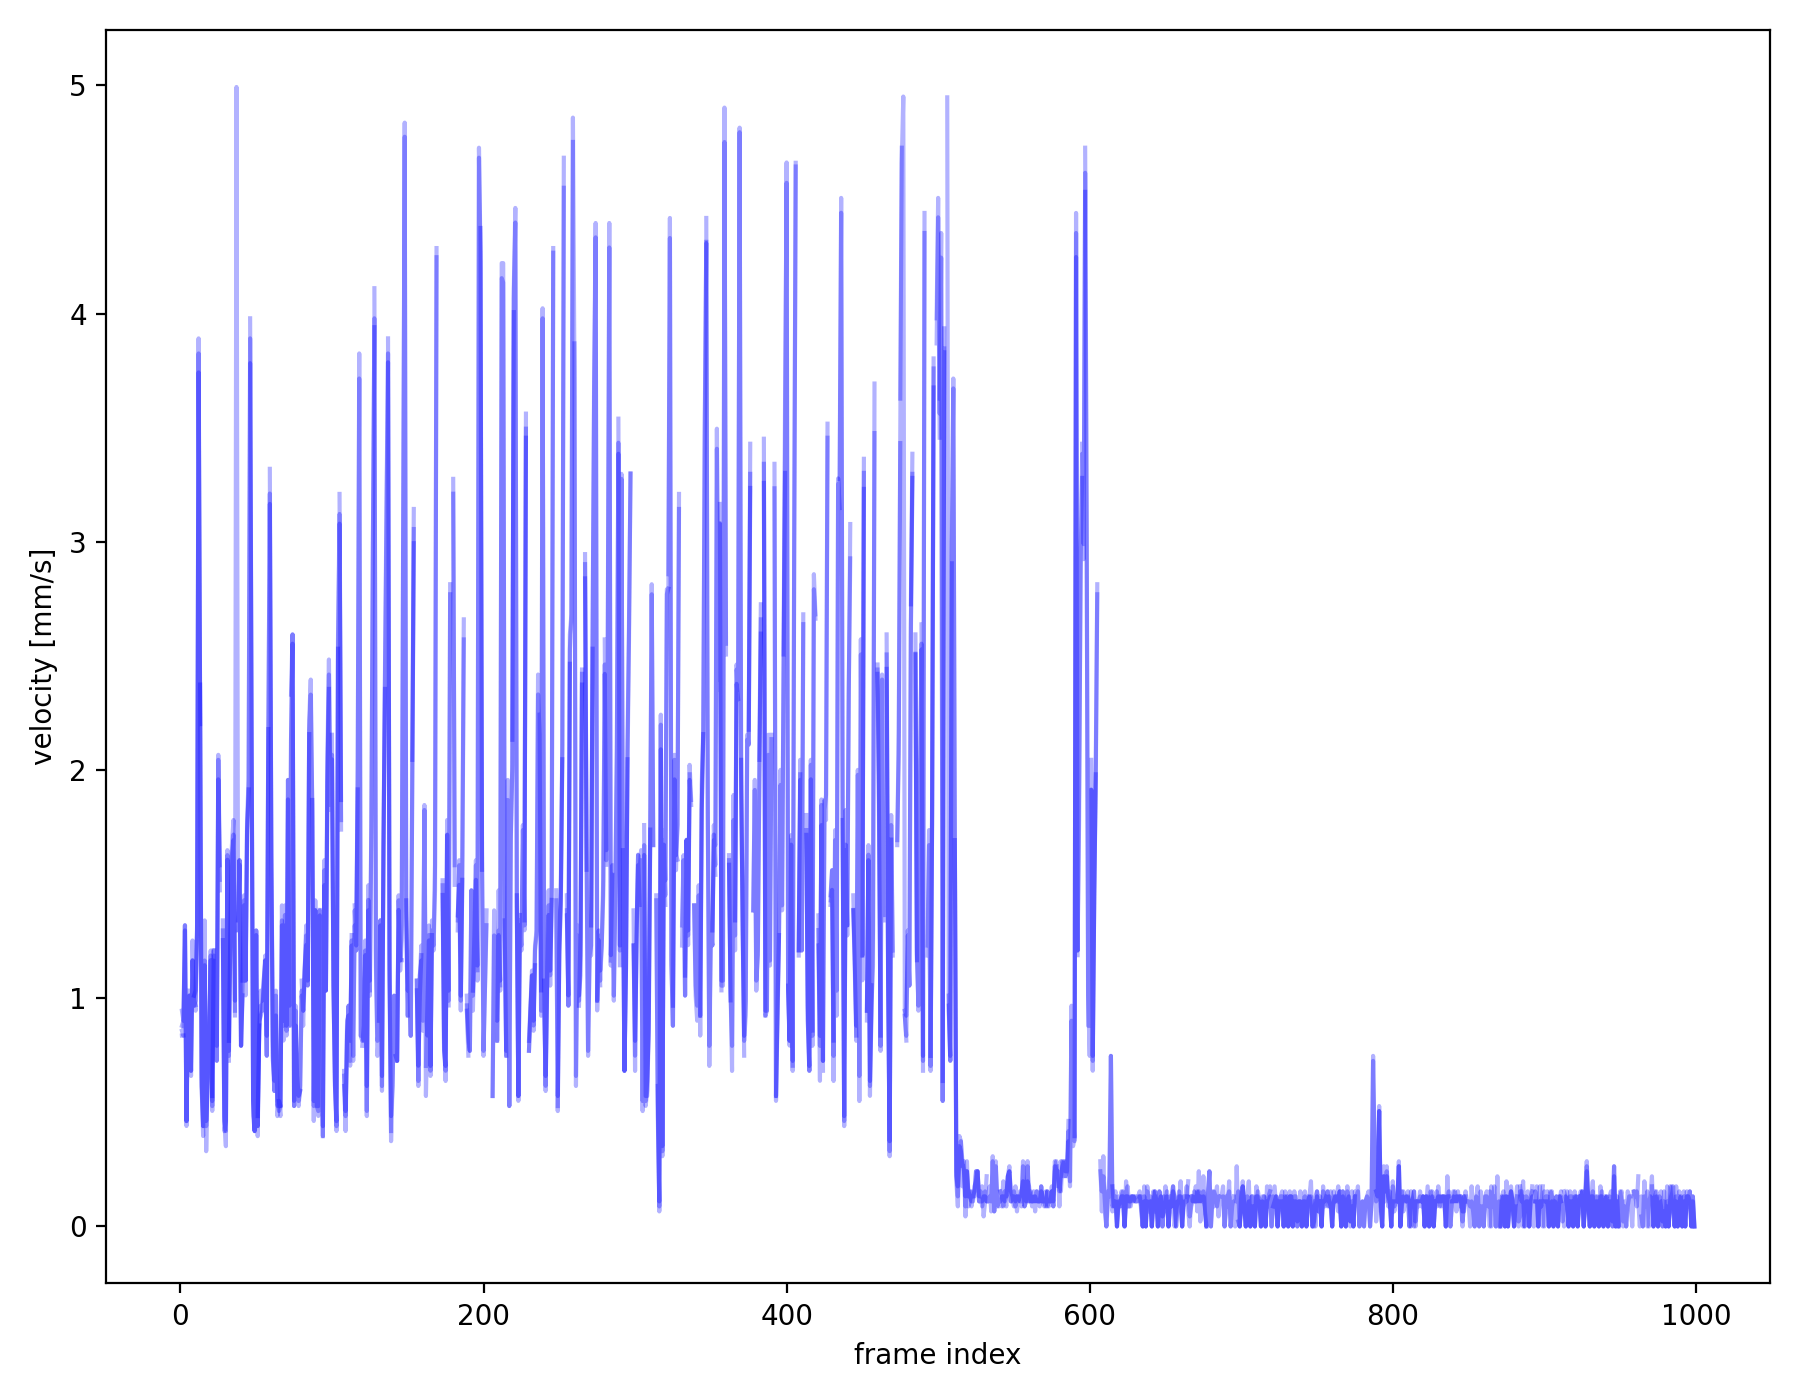

In [62]:
# velocity - frame_id correlation identifying droplets

subname = 'v_vs_frame_id'


fig,ax = plt.subplots(figsize=(9,7))
for d in droplets:
    if d.recurrence >= min_recurrence:
#         plt.plot(d.frames[:-1], d.velocities, c=color_list[d.recurrence - min_recurrence])
        plt.plot(d.frames[:-1], d.velocities, color='blue', alpha=0.3)
    
plt.xlabel('frame index')
plt.ylabel('velocity [mm/s]')

fig.tight_layout()

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


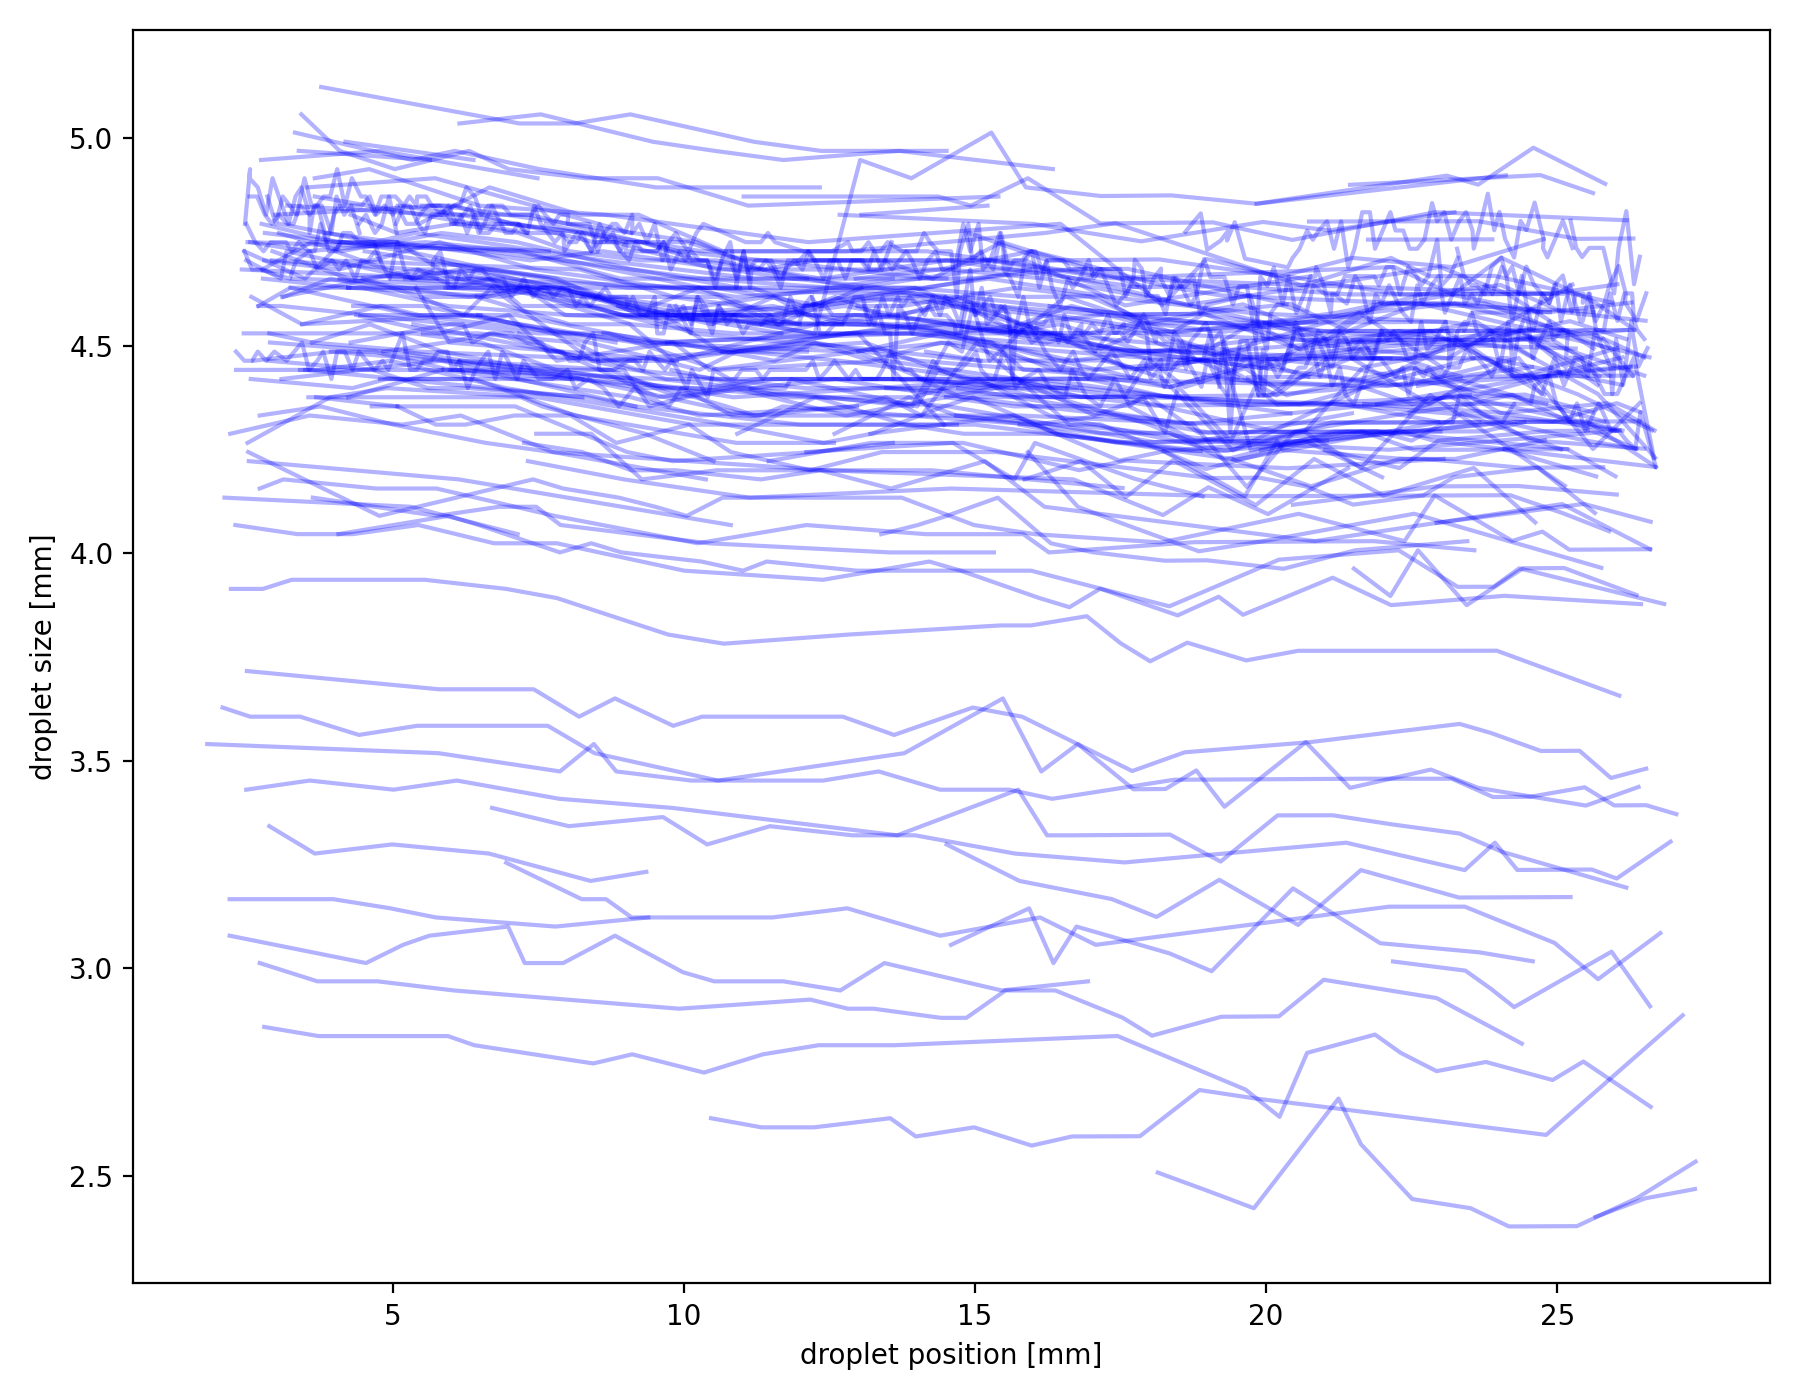

In [64]:
# size - frame_id correlation identifying droplets

subname = 'size_vs_position'

fig,ax = plt.subplots(figsize=(9,7))
for d in droplets:
    if d.recurrence >= min_recurrence:
#         plt.plot(d.frames[:-1], d.velocities, c=color_list[d.recurrence - min_recurrence])
        plt.plot(d.mid_positions, d.sizes, color='blue', alpha=0.3)
    
plt.xlabel('droplet position [mm]')
plt.ylabel('droplet size [mm]')

fig.tight_layout()


# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


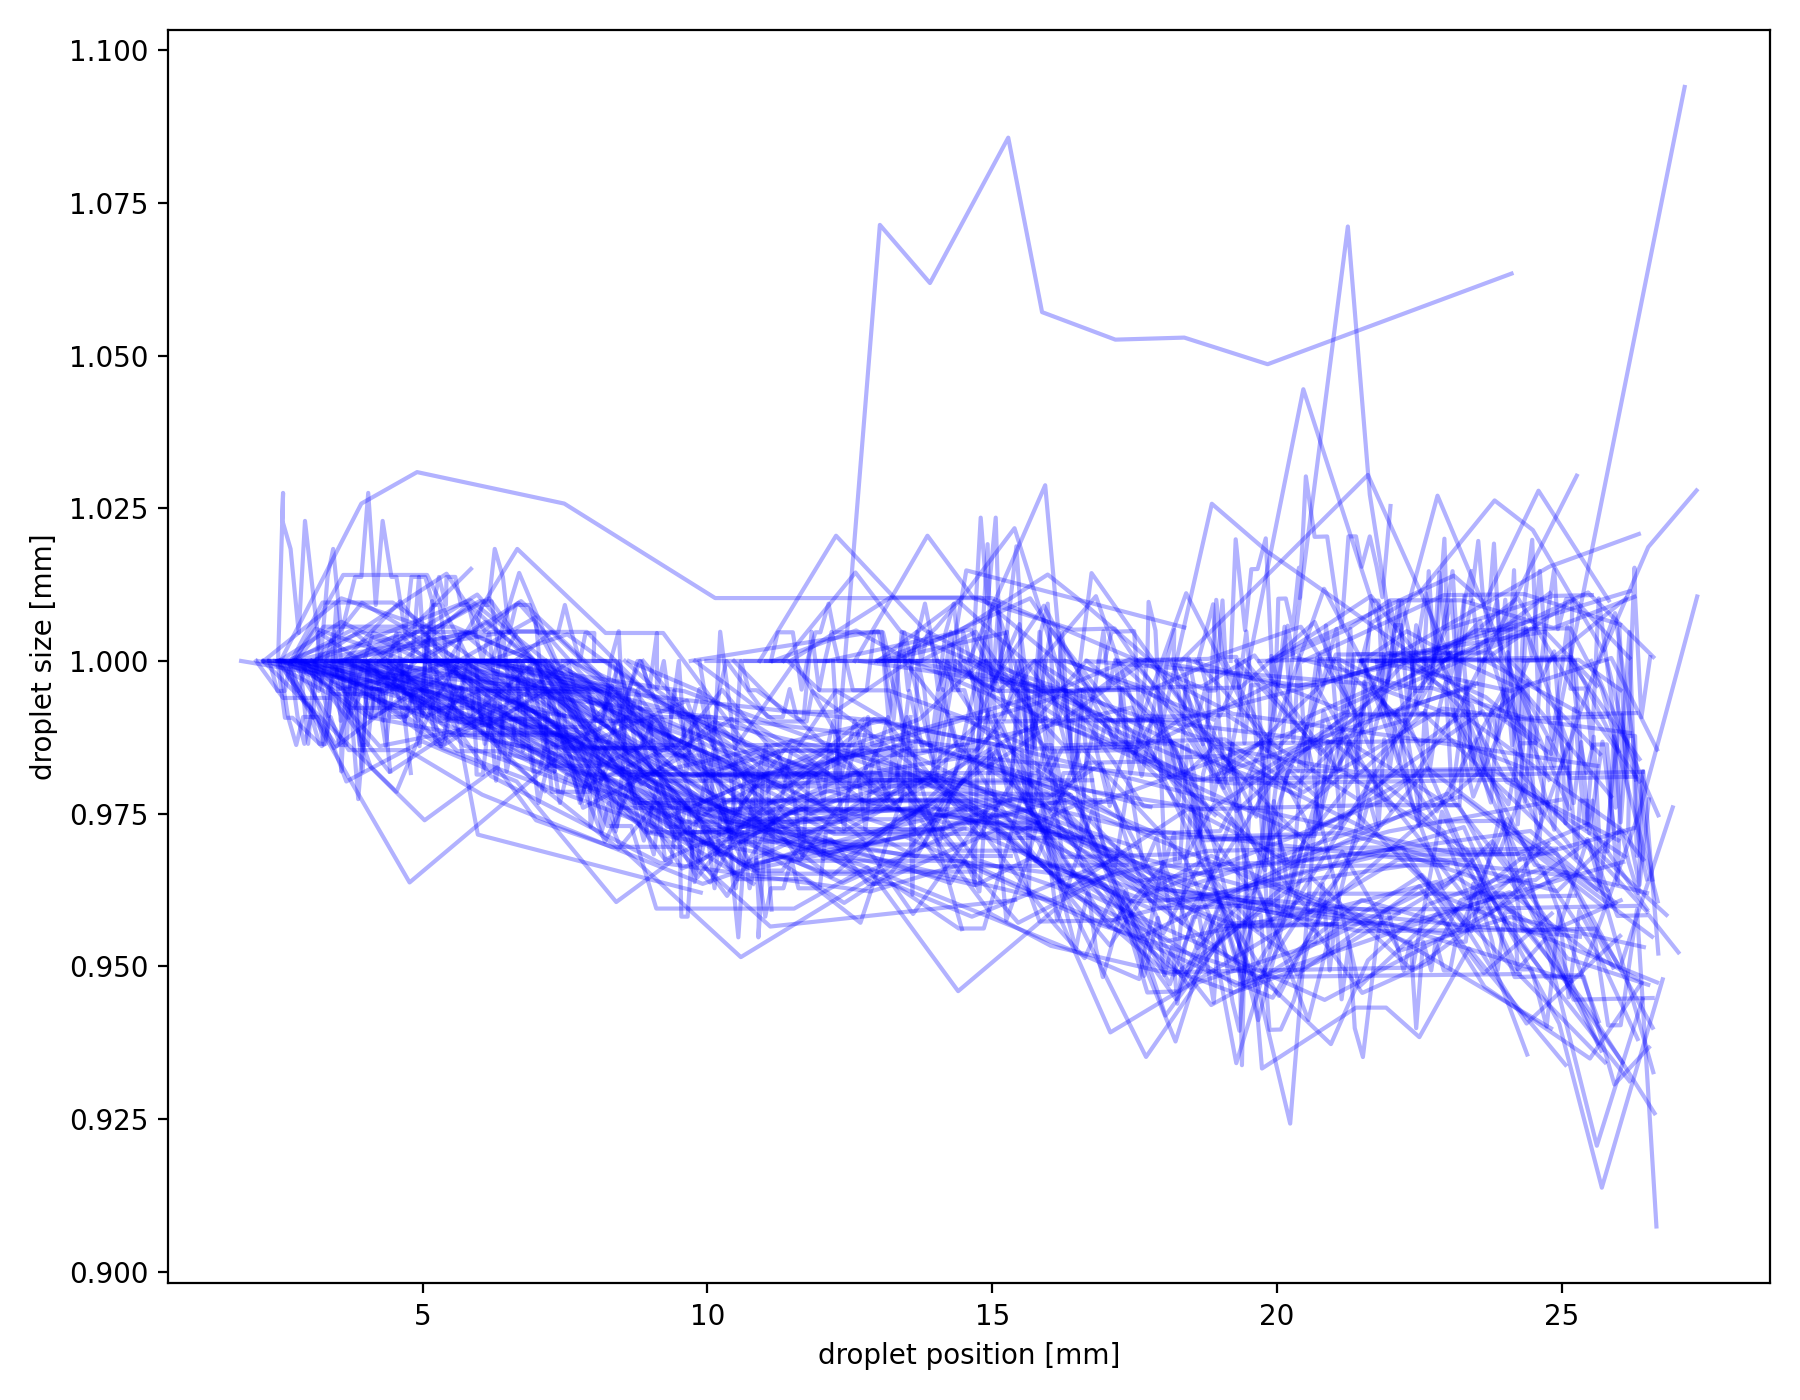

In [70]:
# size - frame_id correlation identifying droplets

subname = 'relative_size_vs_position'

fig,ax = plt.subplots(figsize=(9,7))
for d in droplets:
    if d.recurrence >= min_recurrence:
#         plt.plot(d.frames[:-1], d.velocities, c=color_list[d.recurrence - min_recurrence])
        plt.plot(d.mid_positions, d.sizes/d.sizes[-1], color='blue', alpha=0.3)
    
plt.xlabel('droplet position [mm]')
plt.ylabel('droplet size [mm]')

fig.tight_layout()


# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


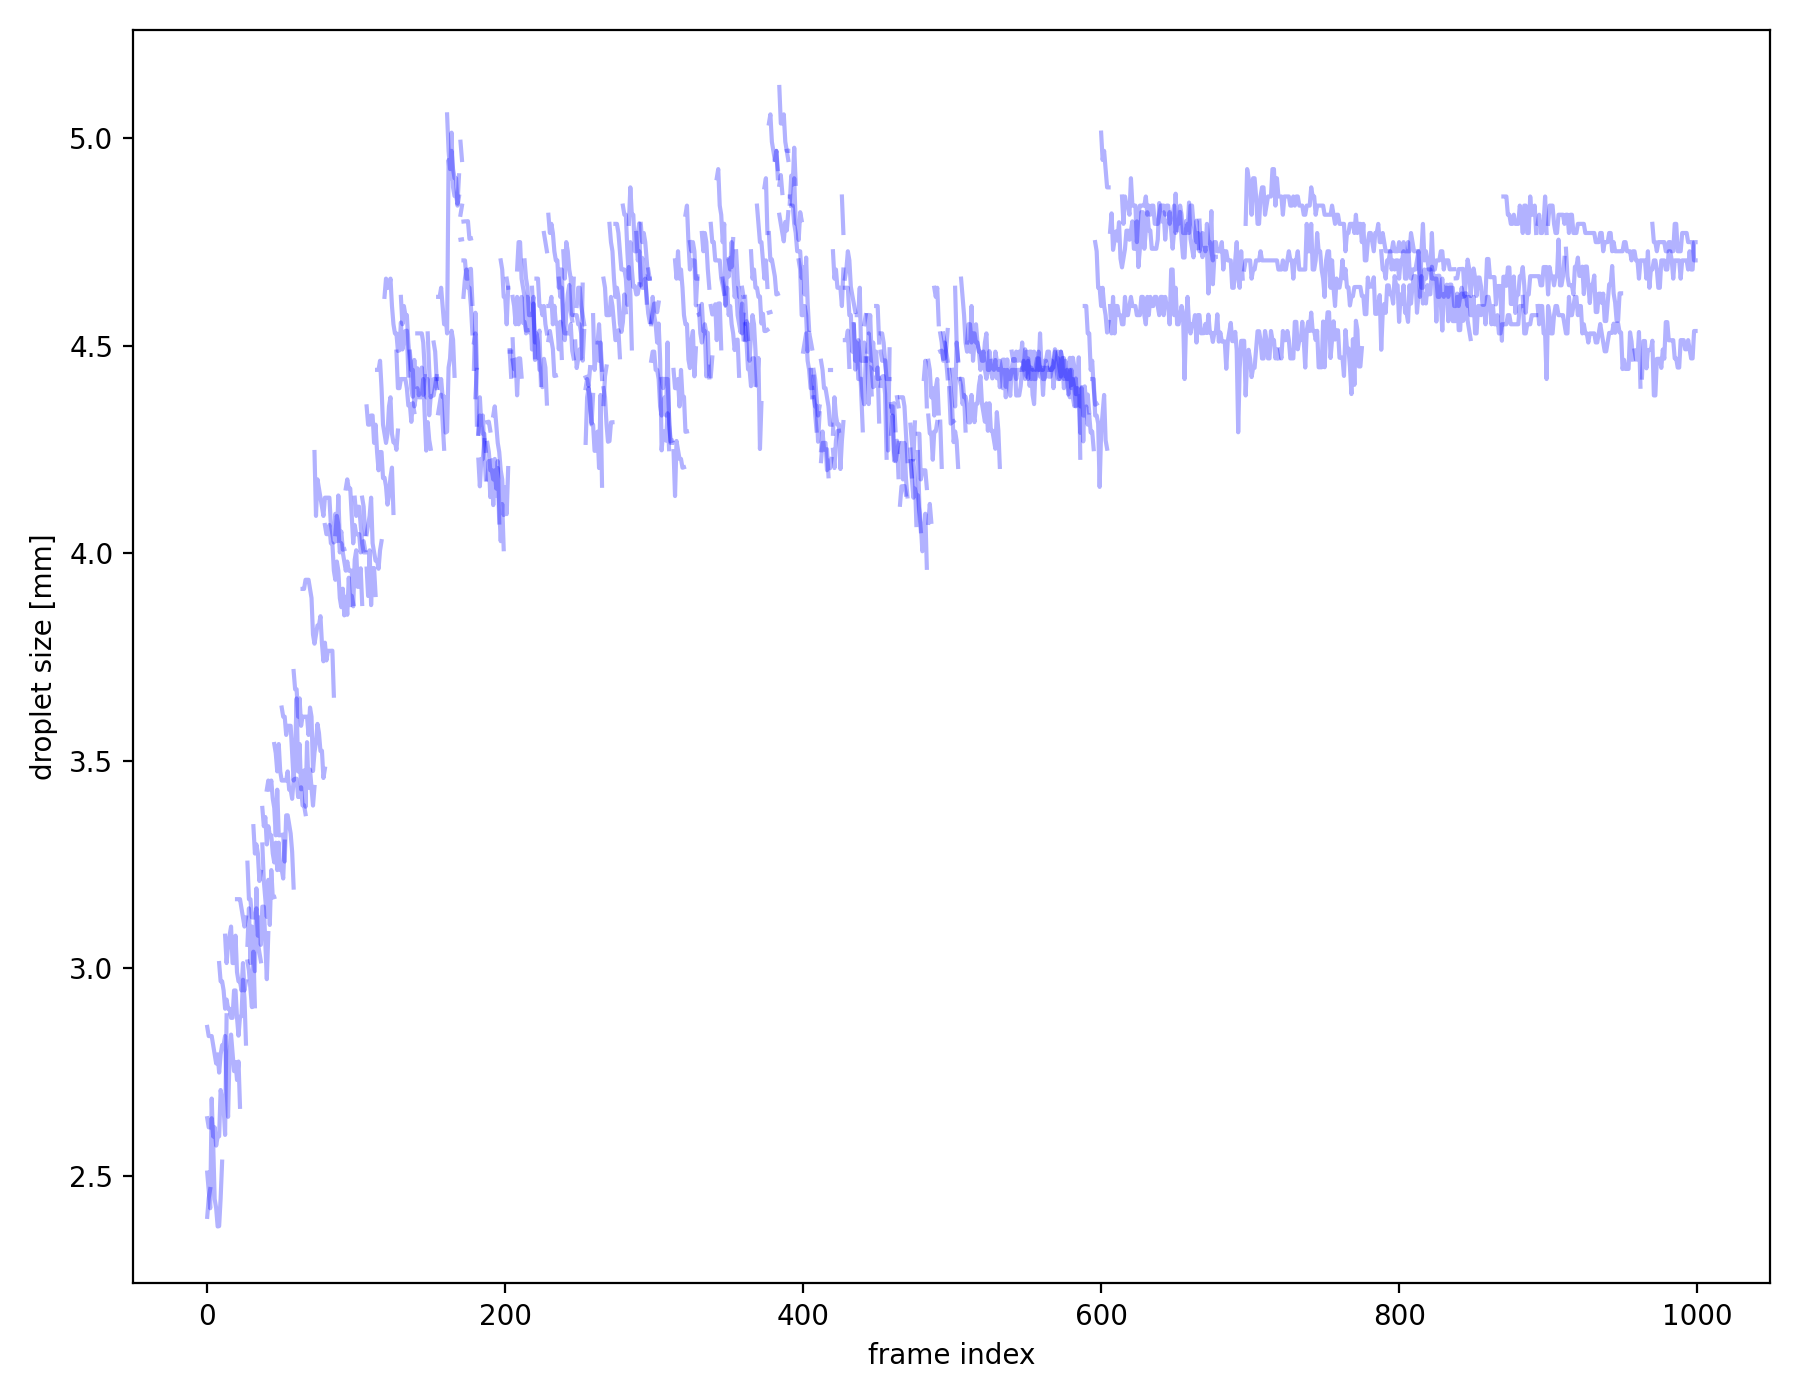

In [63]:
# size - position correlation identifying droplets

subname = 'size_vs_frame_id'

fig,ax = plt.subplots(figsize=(9,7))
for d in droplets:
    if d.recurrence >= min_recurrence:
#         plt.plot(d.frames[:-1], d.velocities, c=color_list[d.recurrence - min_recurrence])
        plt.plot(d.frames, d.sizes, color='blue', alpha=0.3)
    
plt.xlabel('frame index')
plt.ylabel('droplet size [mm]')

fig.tight_layout()


# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

<IPython.core.display.Javascript object>


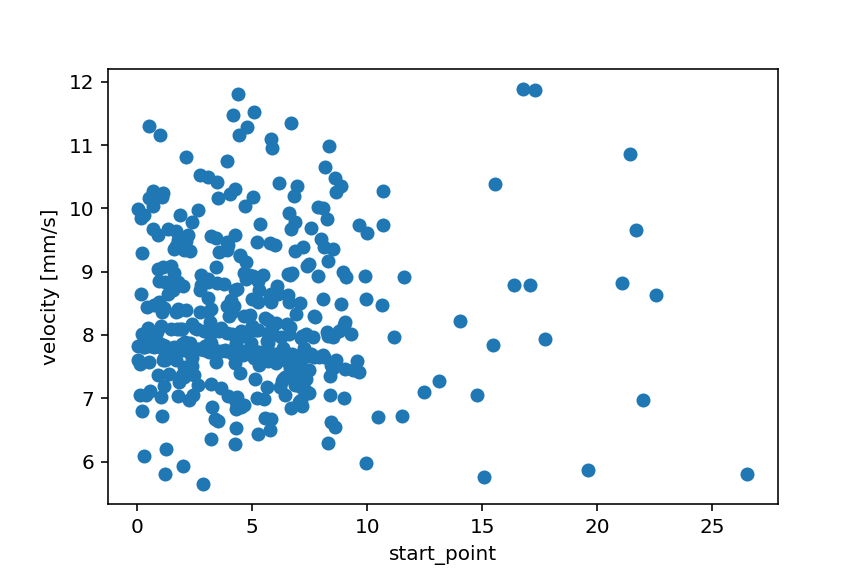

Text(0, 0.5, 'velocity [mm/s]')

In [135]:
# velocity - position correlation

starts= [d.starts[-1] for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.scatter(starts, velocity_means)
plt.xlabel('start_point')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


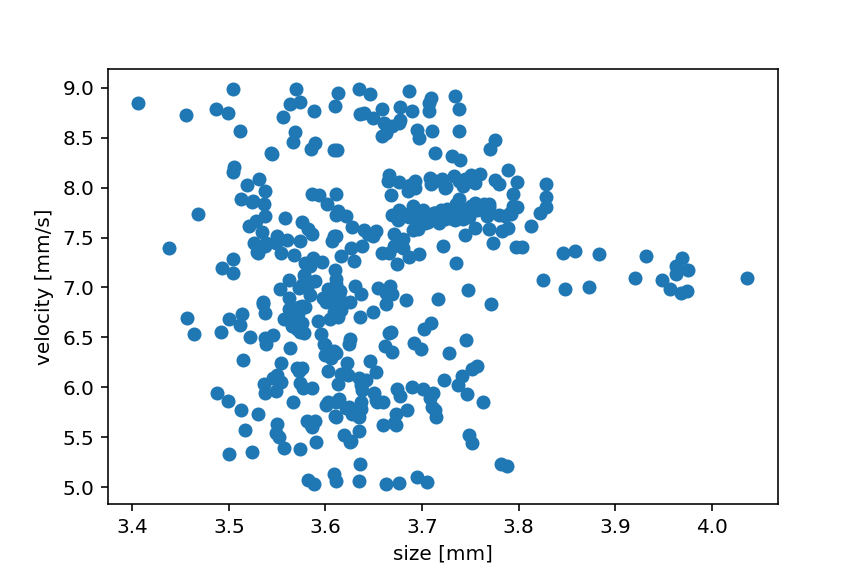

Text(0, 0.5, 'velocity [mm/s]')

In [52]:
# size - velocity correlation

plt.figure()
plt.scatter(size_means, velocity_means)
plt.xlabel('size [mm]')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


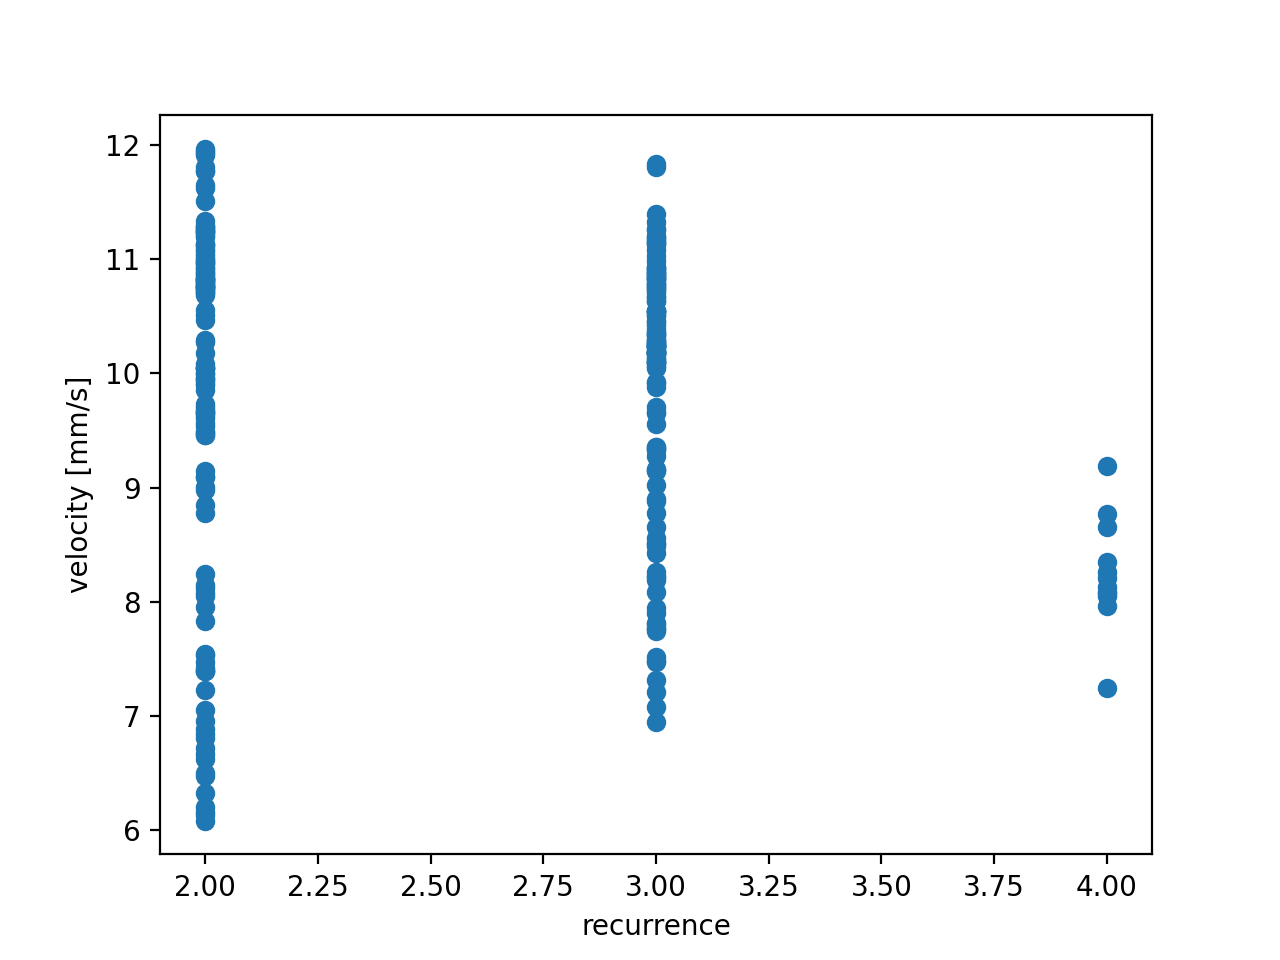

Text(0, 0.5, 'velocity [mm/s]')

In [118]:
# velocity - recurrence correlation

recurrences = [d.recurrence for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.scatter(recurrences, velocity_means)
plt.xlabel('recurrence')
plt.ylabel('velocity [mm/s]')

## All correlation plots

#### testing

In [101]:
df = pd.DataFrame(data=[], columns=['c1', 'c2', 'c3'])
for i in range(100):
    df.loc[len(df)] = list(np.random.uniform(0,1,3))

In [111]:
df.corr()

c1        c2        c3
c1  1.000000 -0.082824 -0.018818
c2 -0.082824  1.000000  0.179122
c3 -0.018818  0.179122  1.000000

In [50]:
def correlation_plots(df, bins=None, **kwargs):
    fontsize = kwargs.pop('fontsize', None)
    
    cols = df.columns
    fig, axs = plt.subplots(len(cols), len(cols), figsize=(9,9))
    for i,l1 in enumerate(cols):
        for j,l2 in enumerate(cols):
            if i == j:
                axs[i,j].hist(df[l1], bins=bins)
                axs[i,j].grid(axis='x')
            elif i > j:
                axs[i,j].scatter(df[l2],df[l1], **kwargs)
                axs[i,j].grid(axis='both')
            else:
                c = df.corr()[l1][l2]
#                 axs[i,j].set_facecolor(f'{0.5*(c + 1)}')
                axs[i,j].set_facecolor(matplotlib.cm.coolwarm(0.5*(c + 1)))
                axs[i,j].text(0.5, 0.5, f'{c:.4f}', fontsize=16, ha='center', va='center')
                axs[i,j].axis([0,1,0,1])
                axs[i,j].get_xaxis().set_ticks([])
                axs[i,j].get_yaxis().set_ticks([])
                
            if i < len(cols) - 1:
                axs[i,j].get_xaxis().set_ticklabels([])
            else:
                axs[i,j].tick_params(axis='x', labelsize=fontsize)
            if i != j and j > 0:
                axs[i,j].get_yaxis().set_ticklabels([])
            else:
                axs[i,j].tick_params(axis='y', labelsize=fontsize)
                
            if i == 0:
                axs[i,j].set_xlabel(l2, fontsize=fontsize)
                axs[i,j].xaxis.set_label_position('top')
            if j == len(cols) - 1:
                axs[i,j].set_ylabel(l1, fontsize=fontsize)
                axs[i,j].yaxis.set_label_position('right')
                
    return fig,axs

<IPython.core.display.Javascript object>


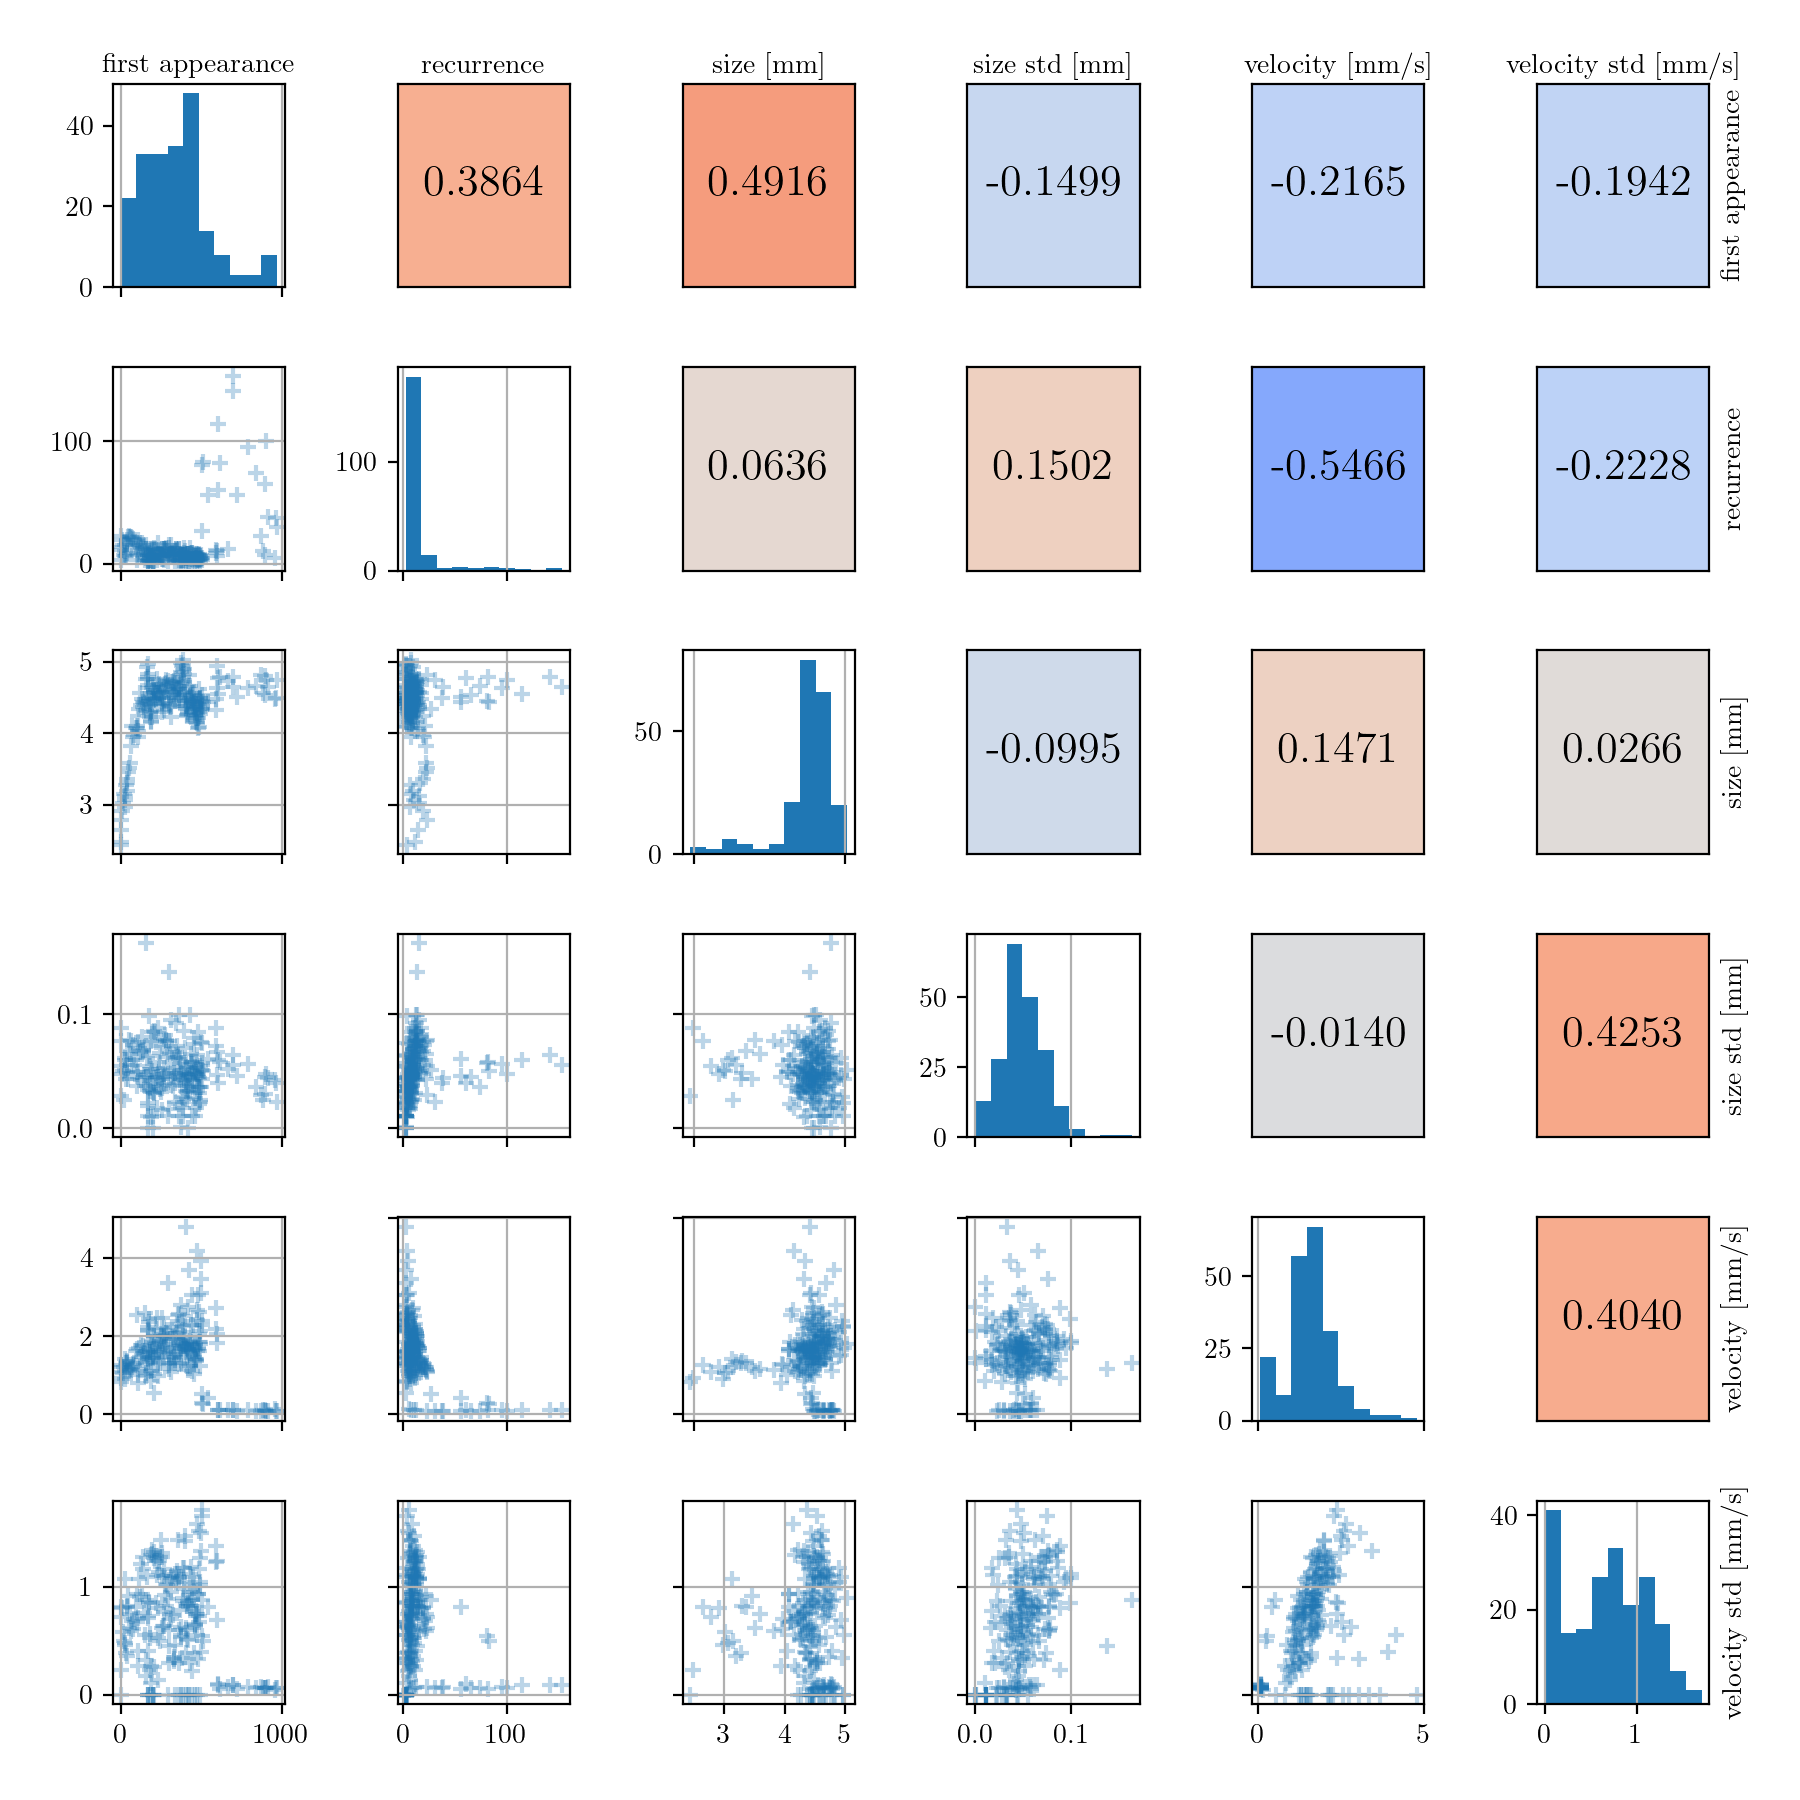

In [53]:
fig,axs = correlation_plots(df, fontsize=10, alpha=0.3, marker='+')
fig.tight_layout()

### Applying it to the drops

In [28]:
cols = ['first appearance', 'recurrence', 'size [mm]', 'size std [mm]', 'velocity [mm/s]', 'velocity std [mm/s]']

df = pd.DataFrame(data=[], columns=cols)

min_recurrence = 2

for d in droplets:
    if d.recurrence >= min_recurrence:
        df.loc[len(df)] = [d.frames[-1], d.recurrence, *d.size, *d.velocity]

<IPython.core.display.Javascript object>


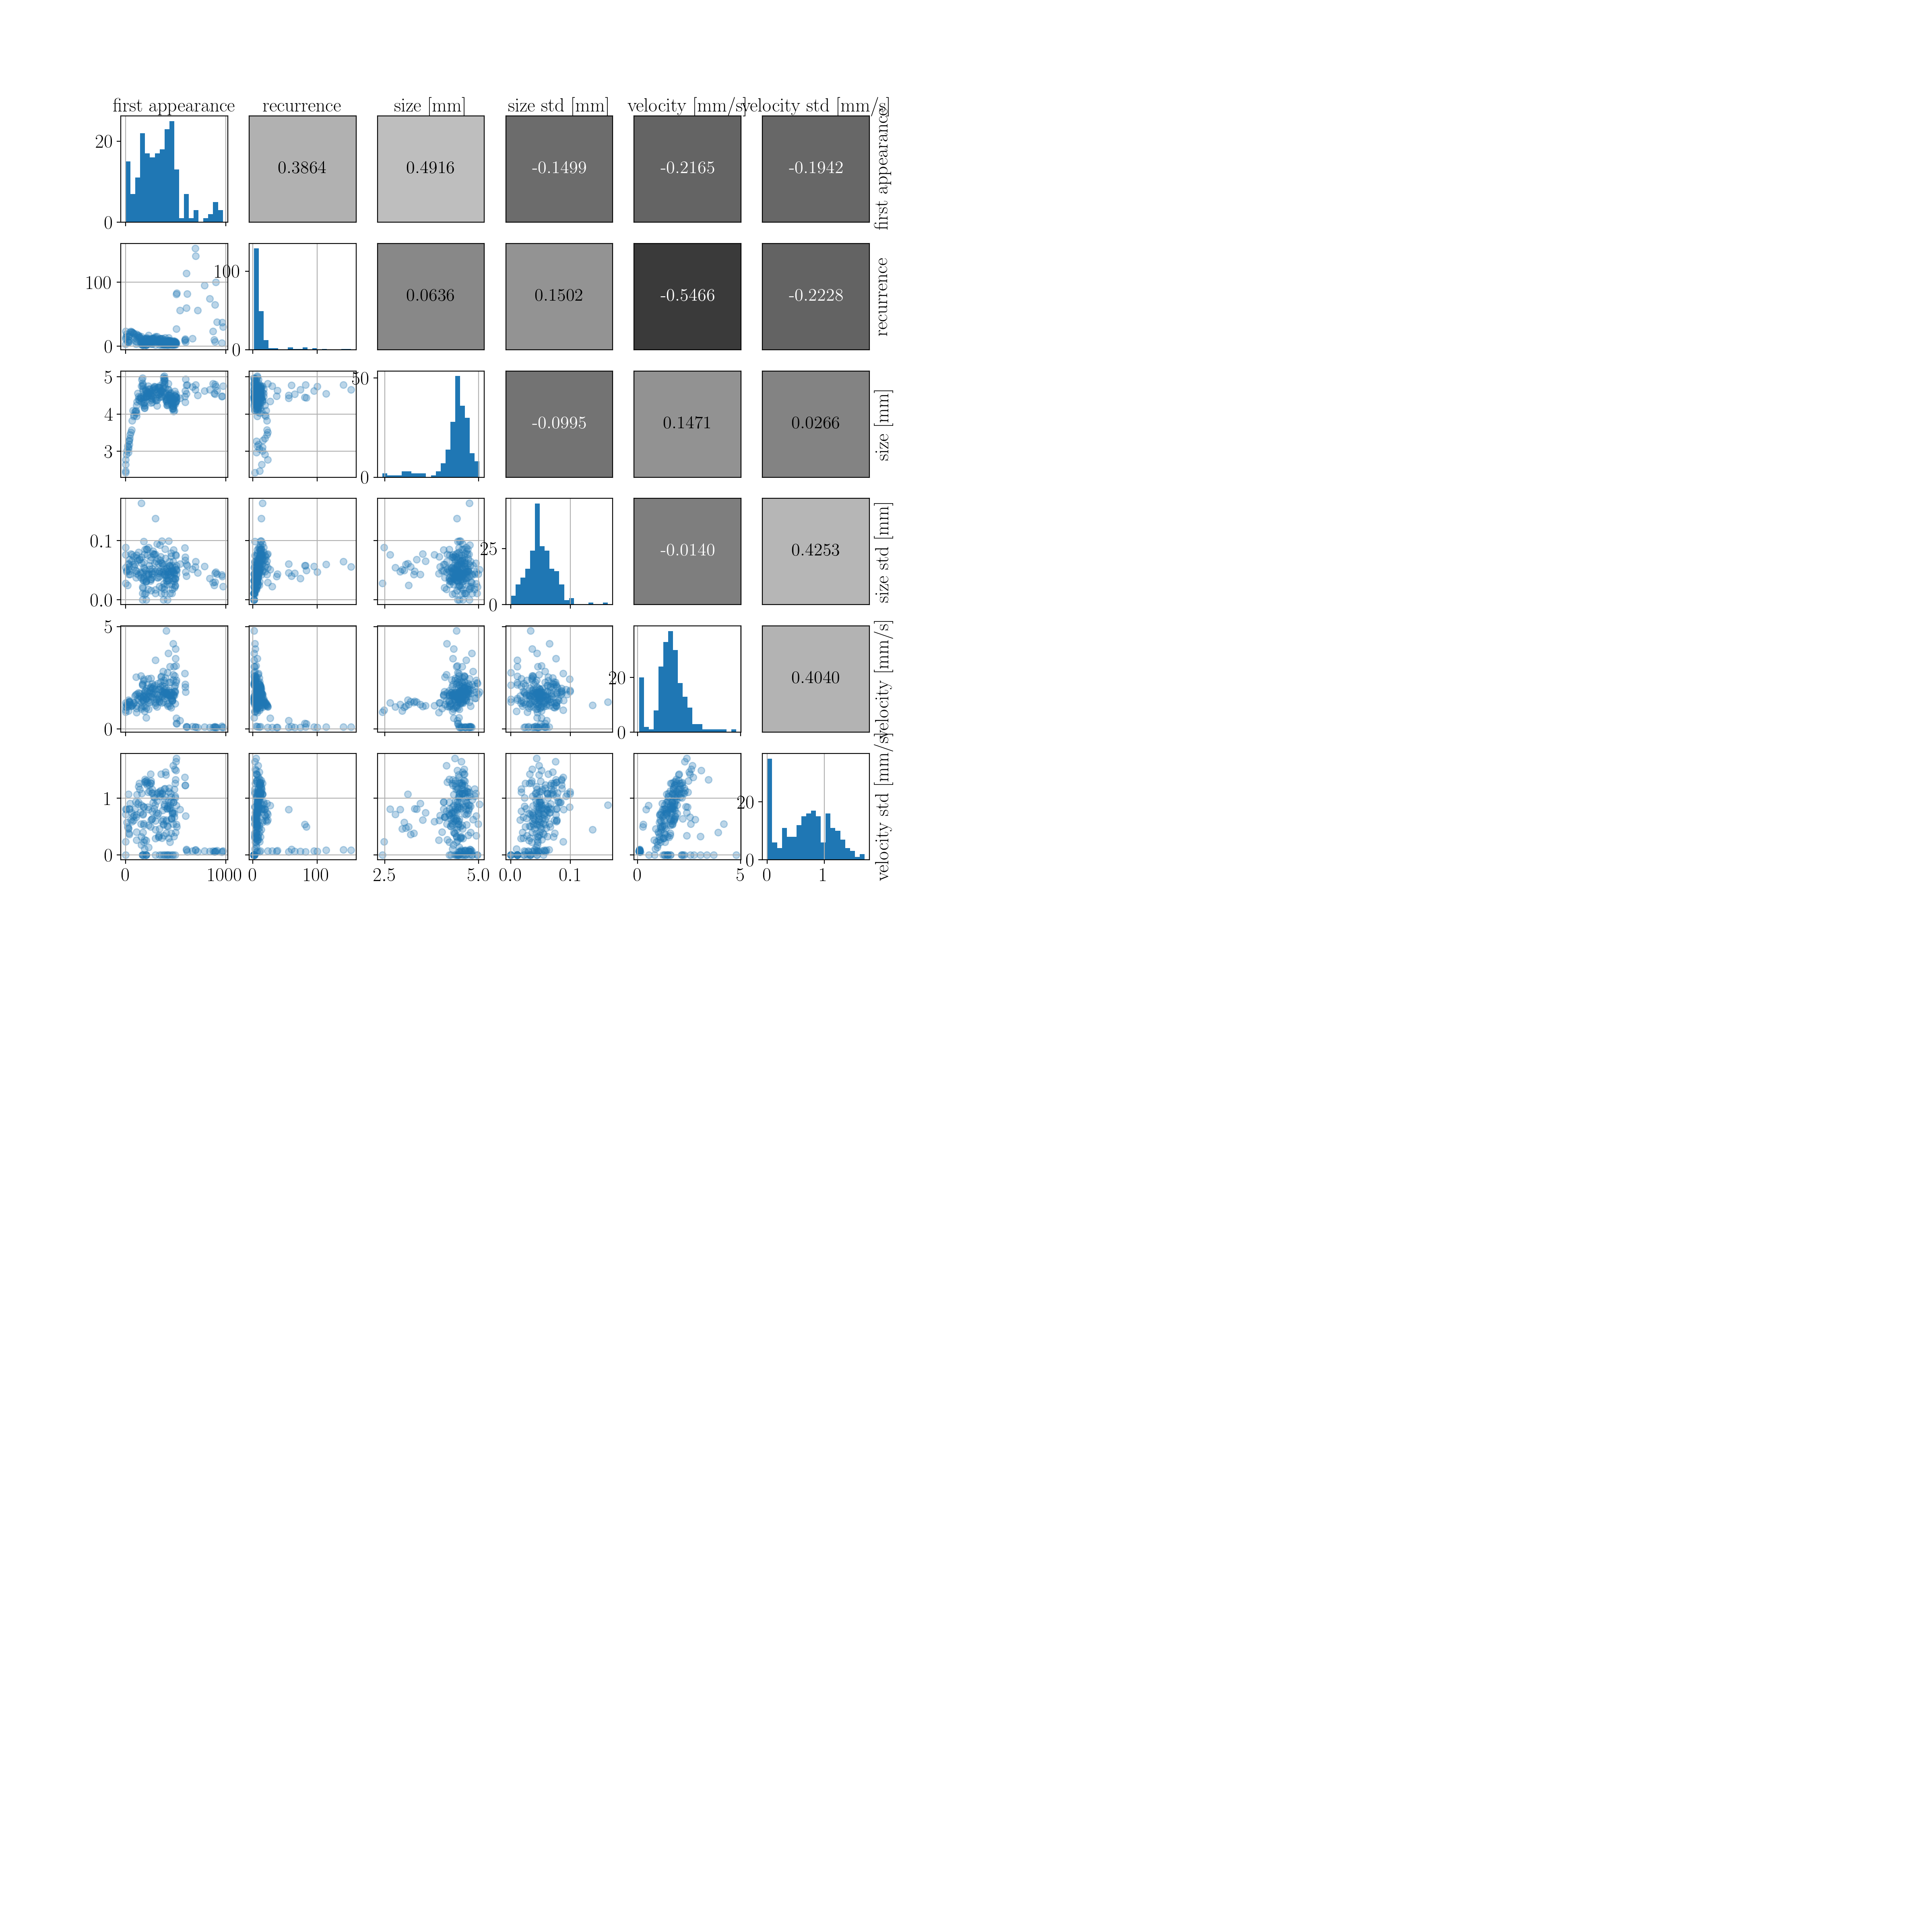

In [29]:
subname = 'correlations'

fig,axs = correlation_plots(df, bins=20, alpha=0.3)


# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

### with seaborn

<IPython.core.display.Javascript object>


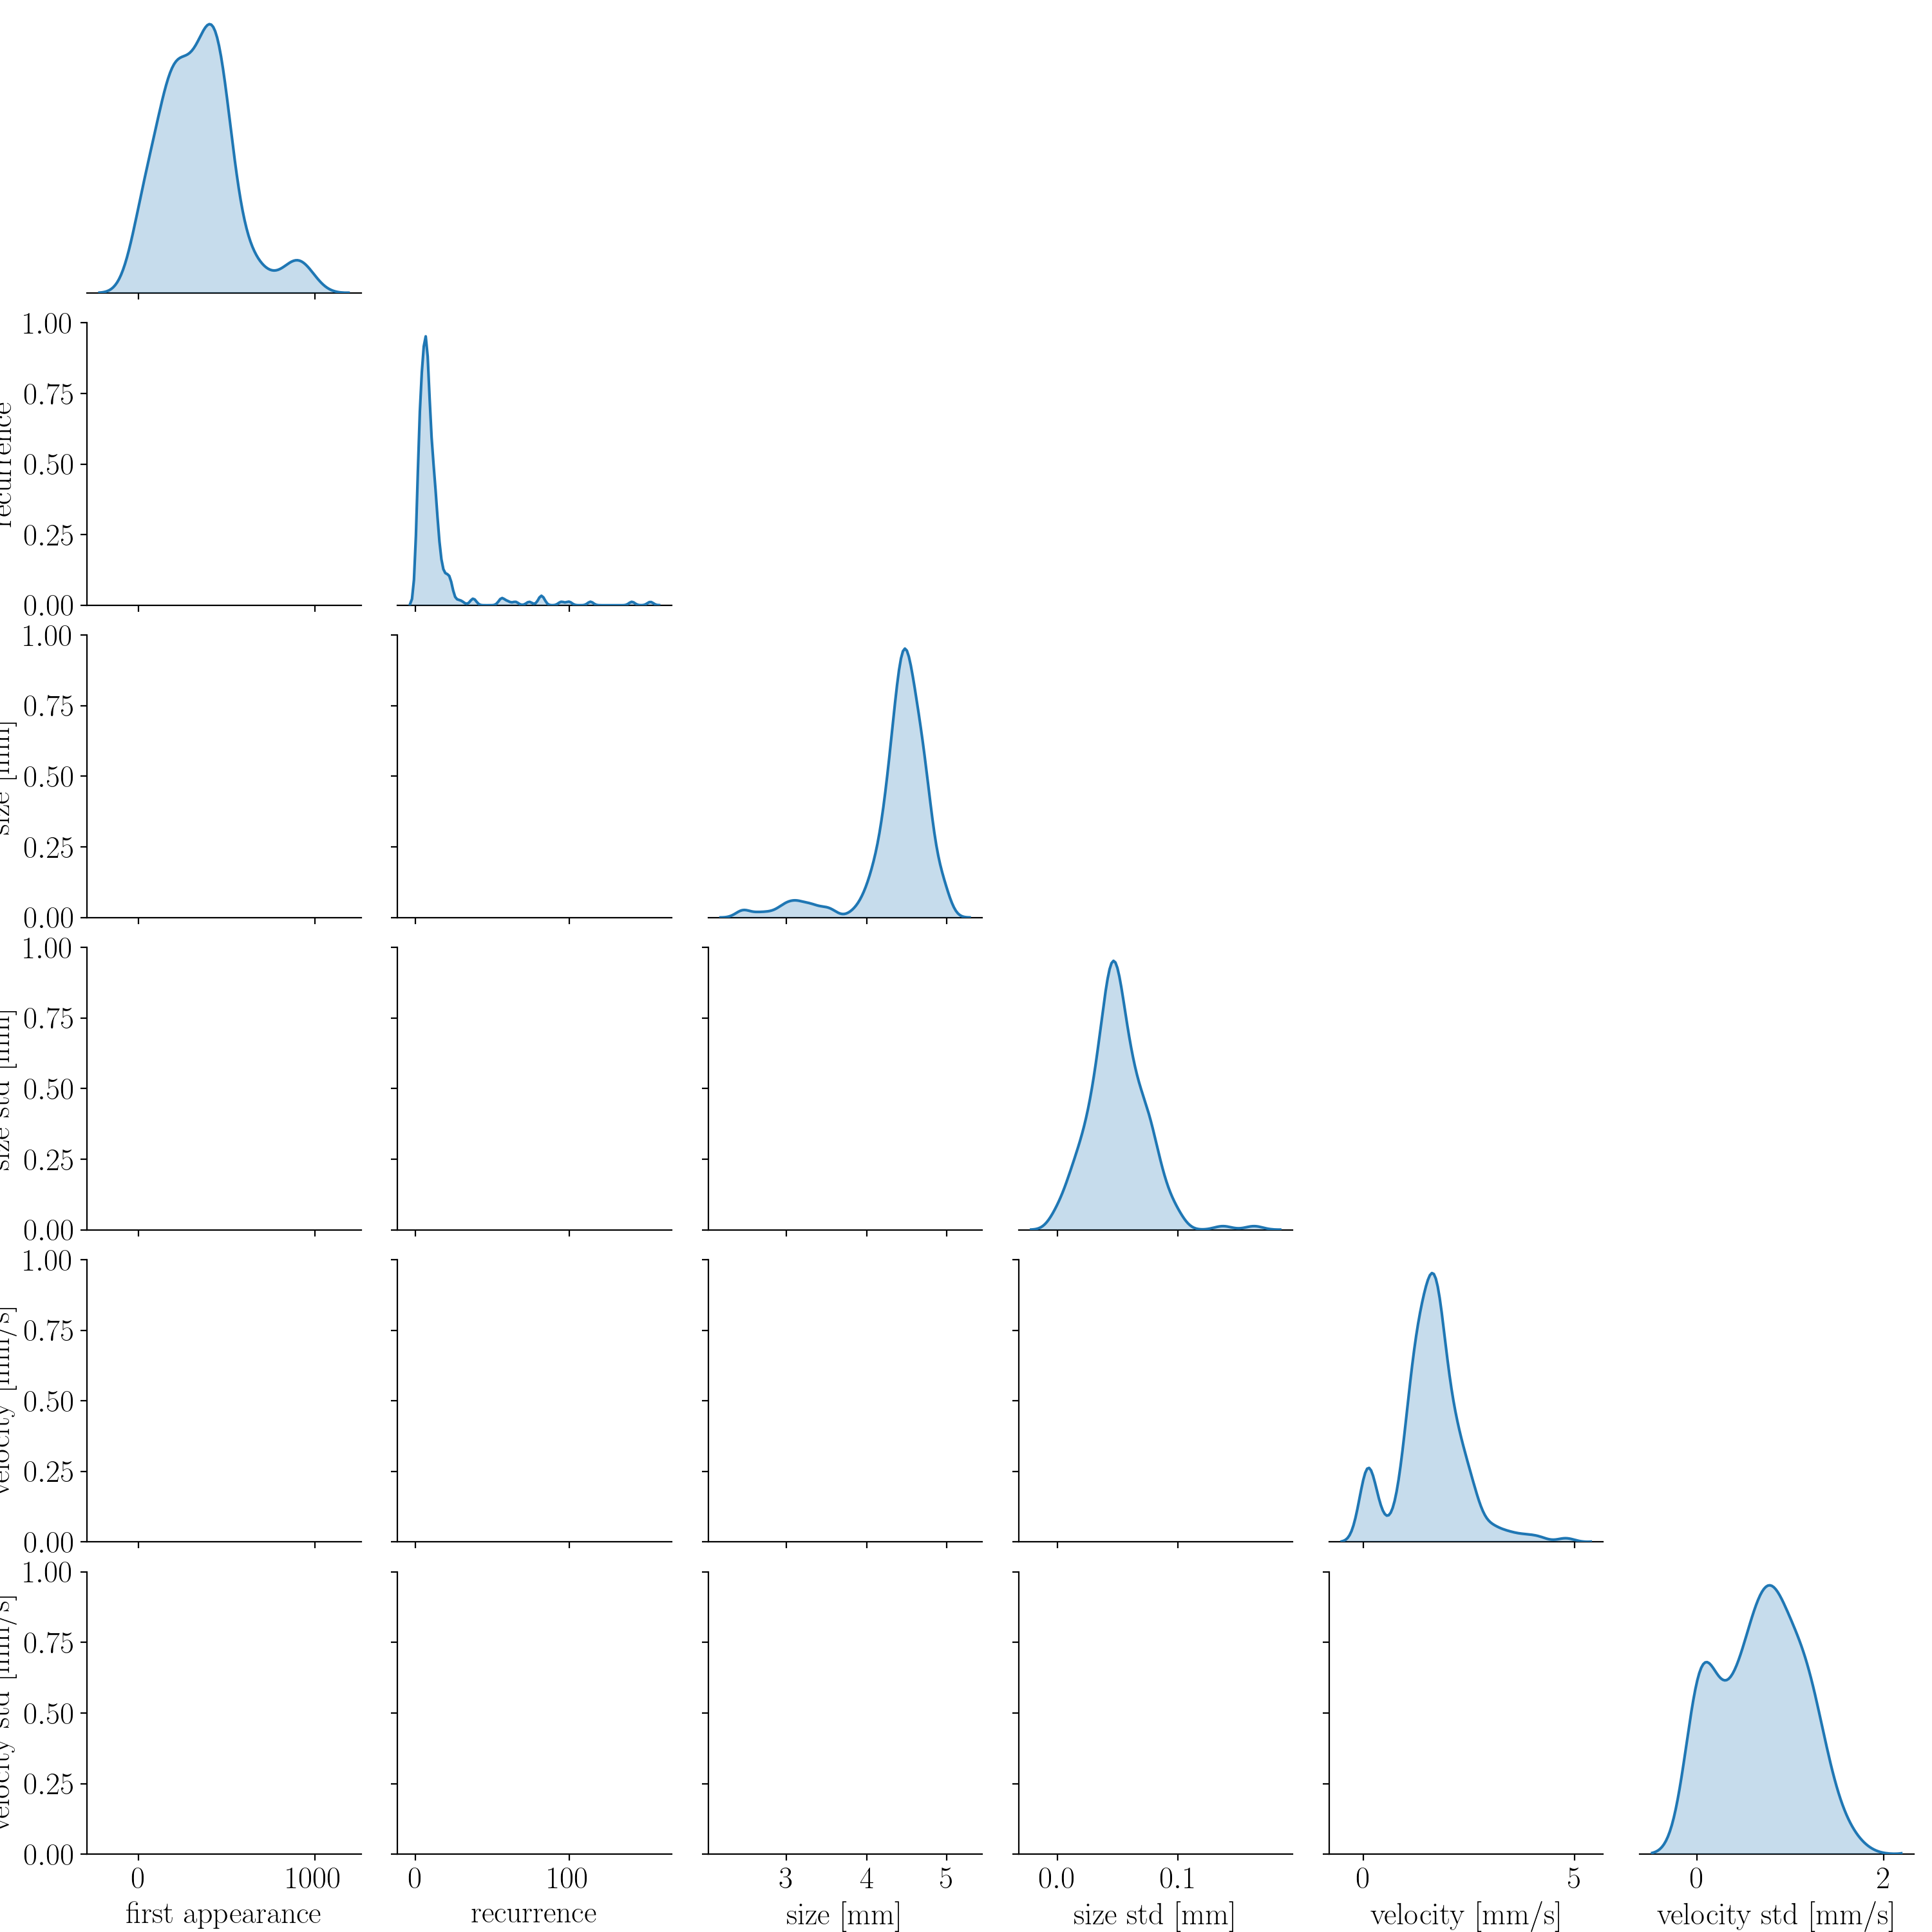

In [55]:
sns.pairplot(data=df, diag_kind="kde", kind='kde', corner=True)

<IPython.core.display.Javascript object>


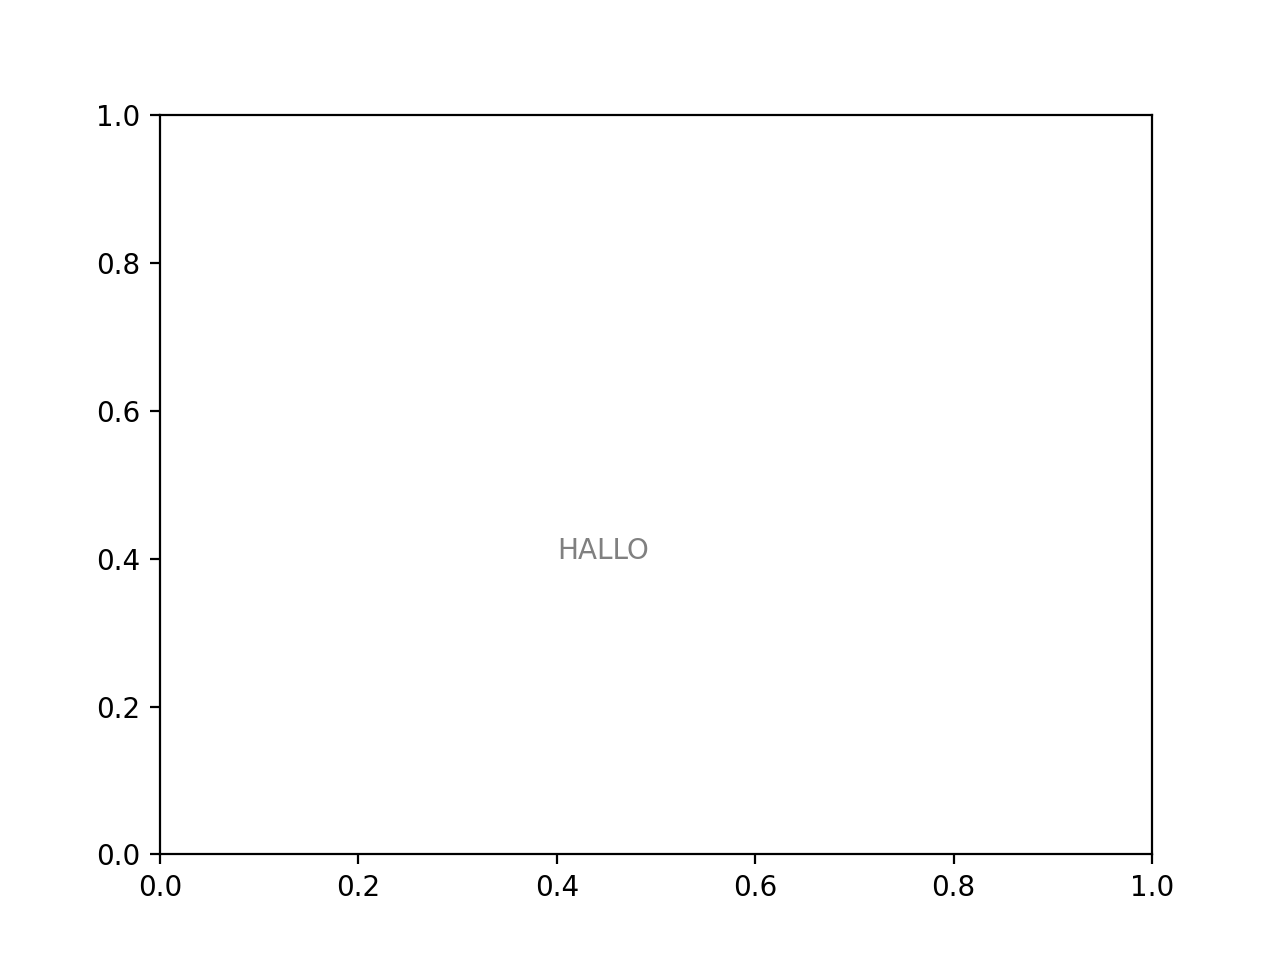

Text(0.4, 0.4, 'HALLO')

In [91]:
fig, ax = plt.subplots()
plt.axis([0,1,0,1])
ax.set_facecolor('1')
plt.text(0.4, 0.4, 'HALLO', c='0.5')